In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
from torch.optim import lr_scheduler
import numpy as np
import torchvision
import torch.utils.data as data
from torch.utils.data.sampler import WeightedRandomSampler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import cv2
import torch.nn.functional as F

%matplotlib inline
plt.ion()

In [2]:
class CubDataset(data.Dataset):
    def __init__(self,
                 root='/datastore/wait_to_review/zhouyang/data/CUB_200_2011/',
                 transform=None,
                 test=False
                 ):
        self.root = root
        self.transform = transform
        self.x = []
        self.y = []
        self.load_data_list(test)

    def load_data_list(self, test):
        images = open(os.path.join(self.root, 'images.txt')).readlines()
        labels = open(os.path.join(self.root, 'image_class_labels.txt')).readlines()
        with open(os.path.join(self.root, 'train_test_split.txt')) as f:
            for line in f.readlines():
                lines = line.strip().split(' ')
                if test and lines[1]=='0':
                    self.x.append(os.path.join(self.root, 'images', images[int(lines[0])-1].strip().split(' ')[1]))
                    self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
                if not test and lines[1]=='1':
                    self.x.append(os.path.join(self.root, 'images', images[int(lines[0])-1].strip().split(' ')[1]))
#                     self.x.append(os.path.join(self.root, 'images_guass_noise', images[int(lines[0])-1].strip().split(' ')[1]))
#                     self.x.append(os.path.join(self.root, 'images_s_p', images[int(lines[0])-1].strip().split(' ')[1]))
#                     self.x.append(os.path.join(self.root, 'images_poisson', images[int(lines[0])-1].strip().split(' ')[1]))
                    self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
#                     self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
#                     self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
#                     self.y.append(int(labels[int(lines[0])-1].strip().split(' ')[1])-1)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, item):
        filepath = self.x[item]
        label = self.y[item]

        # image = Image.open(filepath)
        image = cv2.imread(filepath)
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [3]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(512),
    transforms.RandomHorizontalFlip(0.5),
#     transforms.RandomVerticalFlip(0.5),
    transforms.RandomCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#     transforms.Normalize([0.485, 0.465, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(448),
    transforms.CenterCrop(448),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# paper fast-MPN-COV
# train_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(448),
#     transforms.CenterCrop(448),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])
# val_transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(448),
#     transforms.CenterCrop(448),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
# ])

batch_size = 16

trainset = CubDataset(transform=train_transform)
testset = CubDataset(transform=test_transform, test=True)


trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

torch.Size([48, 3, 448, 448])


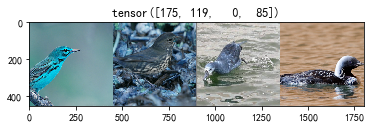

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.465, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    inp = inp[..., ::-1]
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(trainloader))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title=str(classes[:4]))

In [9]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class STN(nn.Module):

    def __init__(self):
        super(STN, self).__init__()
        self.conv = conv1x1(512, 128)
        self.fc_loc = nn.Sequential(
            nn.Linear(128*14*14, 64),
            nn.Tanh(),
            nn.Linear(64, 6),
            nn.Tanh()
        )
        
#         self.fc_loc[2].weight.data.zero_()
#         self.fc_loc[2].bias.data.copy_(torch.tensor([0, 0], dtype=torch.float))

    def forward(self, feature, x, crop):
        feature = self.conv(feature)
        feature = feature.view(-1, 128*14*14)
        theta = self.fc_loc(feature)

        mask = torch.tensor([[1, 0, 0, 0, 0, 0], 
                             [0, 0, 0, 0, 0, 0], 
                             [0, 0, 1, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0],
                             [0, 0, 0, 0, 0, 1]], dtype=torch.float).cuda()
        theta = torch.mm(theta, mask)
        theta = theta.view(-1, 2, 3)
        return theta, x


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, p=0):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # [64, 112, 112]
        self.layer1 = self._make_layer(block, 64, layers[0])
        # [64, 112, 112]
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # [128, 56, 56]
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # [256, 28, 28]
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # [512, 14, 14]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x

        
class ResNetStn(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, p=0, is_train=False):
        super(ResNetStn, self).__init__()
        self.is_train = is_train
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # [64, 112, 112]
        self.layer1 = self._make_layer(block, 64, layers[0])
        # [64, 112, 112]
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # [128, 56, 56]
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # [256, 28, 28]
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # [512, 14, 14]
        self.conv = conv1x1(512 * block.expansion, 128)
        self.fc_loc = nn.Sequential(
            nn.Linear(128*14*14, 64),
            nn.Tanh(),
            nn.Linear(64, 6),
            nn.Tanh()
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
        self.avgpool2 = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout2 = nn.Dropout(p)
        self.fc2 = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        feature = self.conv1(x)
        feature = self.bn1(feature)
        feature = self.relu(feature)
        feature = self.maxpool(feature)

        feature = self.layer1(feature)
        feature = self.layer2(feature)
        feature = self.layer3(feature)
        feature = self.layer4(feature)
        x1 = self.conv(feature)
        theta = self.fc_loc(x1.view(-1, 128*14*14))

        mask = torch.tensor([[1, 0, 0, 0, 0, 0], 
                             [0, 0, 0, 0, 0, 0], 
                             [0, 0, 1, 0, 0, 0],
                             [0, 0, 0, 0, 0, 0],
                             [0, 0, 0, 0, 1, 0],
                             [0, 0, 0, 0, 0, 1]], dtype=torch.float).cuda()
        theta = torch.mm(theta, mask)
        theta = theta.view(-1, 2, 3)
        
        grid = F.affine_grid(theta, feature.size())
        x1 = F.grid_sample(feature, grid)

        x1 = self.avgpool(x1)
        x1 = x1.view(x1.size(0), -1)
        x1 = self.dropout(x1)
        x1 = self.fc(x1)
        
        
        x2 = self.avgpool2(feature)
        x2 = x2.view(x2.size(0), -1)
        x2 = self.dropout2(x2)
        x2 = self.fc2(x2)

        return x1, x2


class ResNetMultiStn(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False, p=0, parallel=[0.9, 0.7, 0.5]):
        super(ResNetMultiStn, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # [64, 112, 112]
        self.layer1 = self._make_layer(block, 64, layers[0])
        # [64, 112, 112]
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        # [128, 56, 56]
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        # [256, 28, 28]
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # [512, 14, 14]
        self.stn_fc = StnFc975(parallel, 512 * block.expansion, num_classes)
#         self.stn_fc = StnFc8642(parallel, 512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.stn_fc(x)

        return x


class StnFc975(nn.Module):
    
    def __init__(self, parallel, in_feature, out_feature):
        super(StnFc975, self).__init__()
        self.parallel = parallel
        self.out_feature = out_feature
        self.stn = BasicStn(parallel, in_feature)
        self.fc1 = BasicFc(in_feature, out_feature)
        self.fc2 = BasicFc(in_feature, out_feature)
        self.fc3 = BasicFc(in_feature, out_feature)
        self.fc4 = BasicFc(in_feature, out_feature)
            
    def forward(self, feature):
        x = self.fc1(feature)
        thetas = self.stn(feature)
        i = 0
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc2(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc3(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc4(xs)
        
        return x
    
    
class StnFc925(nn.Module):
    
    def __init__(self, parallel, in_feature, out_feature):
        super(StnFc925, self).__init__()
        self.parallel = parallel
        self.out_feature = out_feature
        self.stn = BasicStn(parallel, in_feature)
        self.fc1 = BasicFc(in_feature, out_feature)
        self.fc2 = BasicFc(in_feature, out_feature)
        self.fc3 = BasicFc(in_feature, out_feature)
        self.fc4 = BasicFc(in_feature, out_feature)
        self.fc5 = BasicFc(in_feature, out_feature)
        self.fc6 = BasicFc(in_feature, out_feature)
            
    def forward(self, feature):
        x = self.fc1(feature)
        thetas = self.stn(feature)
        i = 0
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc2(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc3(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc4(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc5(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc6(xs)
        
        return x
    

class StnFc921(nn.Module):
    
    def __init__(self, parallel, in_feature, out_feature):
        super(StnFc925, self).__init__()
        self.parallel = parallel
        self.out_feature = out_feature
        self.stn = BasicStn(parallel, in_feature)
        self.fc1 = BasicFc(in_feature, out_feature)
        self.fc2 = BasicFc(in_feature, out_feature)
        self.fc3 = BasicFc(in_feature, out_feature)
        self.fc4 = BasicFc(in_feature, out_feature)
        self.fc5 = BasicFc(in_feature, out_feature)
        self.fc6 = BasicFc(in_feature, out_feature)
            
    def forward(self, feature):
        x = self.fc1(feature)
        thetas = self.stn(feature)
        i = 0
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc2(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc3(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc4(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc5(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc6(xs)
        
        return x
    
    
class StnFc8642(nn.Module):
    
    def __init__(self, parallel, in_feature, out_feature):
        super(StnFc8642, self).__init__()
        self.parallel = parallel
        self.out_feature = out_feature
        self.stn = BasicStn(parallel, in_feature)
        self.fc1 = BasicFc(in_feature, out_feature)
        self.fc2 = BasicFc(in_feature, out_feature)
        self.fc3 = BasicFc(in_feature, out_feature)
        self.fc4 = BasicFc(in_feature, out_feature)
        self.fc5 = BasicFc(in_feature, out_feature)
            
    def forward(self, feature):
        x = self.fc1(feature)
        thetas = self.stn(feature)
        i = 0
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc2(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc3(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc4(xs)
        i += 1
        
        theta = thetas[:, (i)*2:(i+1)*2]
        theta = theta.view(-1, 2, 1)
        crop_matrix = torch.tensor([[self.parallel[i], 0], [0, self.parallel[i]]], dtype=torch.float).cuda()
        crop_matrix = crop_matrix.repeat(theta.size(0), 1).reshape(theta.size(0), 2, 2)
        theta = torch.cat((crop_matrix, theta), dim=2)
        grid = F.affine_grid(theta, feature.size())
        xs = F.grid_sample(feature, grid)
        x += self.fc5(xs)
        
        return x

    

class BasicStn(nn.Module):

    def __init__(self, parallel, in_feature, **kwargs):
        super(BasicStn, self).__init__()
        self.conv = conv1x1(in_feature, 128)
        self.fc_loc = nn.Sequential(
            nn.Linear(128*14*14, 64),
            nn.Tanh(),
            nn.Linear(64, 2*len(parallel)),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 128*14*14)
        x = self.fc_loc(x)
        return x 
    
    
class BasicFc(nn.Module):

    def __init__(self, in_feature, out_feature, p=0, **kwargs):
        super(BasicFc, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(in_feature, out_feature)

    def forward(self, x):
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x 

        
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet18'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet50'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model

def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet101'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model


def resnet_stn18(pretrained=False, checkpoint='', **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetStn(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        if checkpoint != '':
            pretrained_dict = torch.load(checkpoint)
        else:
            pretrained_dict = model_zoo.load_url(model_urls['resnet18'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model


def resnet_stn50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetStn(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet50'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model

def resnet_multi_stn50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetMultiStn(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet50'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model

def resnet_multi_stn101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNetMultiStn(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model_dict = model.state_dict()
        pretrained_dict = model_zoo.load_url(model_urls['resnet101'])
        model_dict.update(
            {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
        model.load_state_dict(model_dict)
    return model

In [11]:
def train(model, criterion, optimizer, schedler, epochs, train_log='train_log', test_log='test_log', saved_model='model'):
    best_acc = 0.0
    for epoch in range(epochs):
        logs = open(train_log, 'a')
        model.train()
        running_corrects = 0
        running_loss = 0.0
        schedler.step()
        for i, (images, labels) in enumerate(trainloader):
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)

            if i % 10 == 0:
                print('Epoch: {}/{}, Iter: {}/{:.0f}, Loss: {:.4f}'
                     .format(epoch, epochs, i, trainset.__len__()/batch_size+1, loss.item()))
        epoch_loss = running_loss / trainset.__len__()
        epoch_acc = running_corrects.double() / trainset.__len__()

        log = 'Epoch: {}/{}, Loss: {:.4f} Acc: {}/{}, {:.4f}'.format(epoch, 
                                                              epochs,
                                                              epoch_loss, 
                                                              running_corrects, trainset.__len__(), epoch_acc)
        print(log)
        logs.write(log+'\n')
        test_acc = validate(model, test_log=test_log)
        torch.save(model.state_dict(), '{}_latest.pkl'.format(saved_model))
        if best_acc < test_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), '{}_best.pkl'.format(saved_model))

In [7]:
def validate(model, crop=0, test_log=''):
    if test_log != '':
        logs = open(test_log, 'a')
    model.eval()
    with torch.no_grad():
        running_corrects = 0
        running_loss = 0.0
        for i, (images, labels) in enumerate(testloader):
            images = images.cuda()
            labels = labels.cuda()

            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * images.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / testset.__len__()
        epoch_acc = running_corrects.double() / testset.__len__()
        log = 'Test Loss: {:.4f} Acc: {}/{}, {:.4f}'.format(epoch_loss, 
                                                       running_corrects, testset.__len__(), epoch_acc)
        print(log)
        if test_log != '':
            logs.write(log+'\n')
        return epoch_acc

In [ ]:
# train fc2
# resnet 50 with dropout(p=0.5) img(448, 448) init by ImageNet
model = resnet_stn50(pretrained=True, num_classes=200, p=0.5)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 120], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
if not os.path.exists('checkpoints'):
    os.mkdir('checkpoints')
train_log = 'logs/train_resnet_50_embeding_stn_and_origin'
test_log = 'logs/test_resnet_50_embeding_stn_and_origin'
saved_model = 'resnet_50_embeding_stn_and_origin'
train(model, criterion, optimizer, exp_lr_schedler, epochs=130, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/129, Process: 0/375, Loss1: 5.5426, Loss2: 5.6755, Loss: 5.9252, 
Epoch: 0/129, Process: 10/375, Loss1: 5.3034, Loss2: 5.3702, Loss: 5.3796, 
Epoch: 0/129, Process: 20/375, Loss1: 5.3214, Loss2: 5.3496, Loss: 5.3844, 
Epoch: 0/129, Process: 30/375, Loss1: 5.2994, Loss2: 5.3902, Loss: 5.4019, 
Epoch: 0/129, Process: 40/375, Loss1: 5.3124, Loss2: 5.2324, Loss: 5.2614, 
Epoch: 0/129, Process: 50/375, Loss1: 5.2955, Loss2: 5.2462, Loss: 5.2573, 
Epoch: 0/129, Process: 60/375, Loss1: 5.3227, Loss2: 5.4424, Loss: 5.4855, 
Epoch: 0/129, Process: 70/375, Loss1: 5.3317, Loss2: 5.3509, Loss: 5.3976, 
Epoch: 0/129, Process: 80/375, Loss1: 5.2856, Loss2: 5.3316, Loss: 5.3331, 
Epoch: 0/129, Process: 90/375, Loss1: 5.3064, Loss2: 5.2967, Loss: 5.3124, 
Epoch: 0/129, Process: 100/375, Loss1: 5.3153, Loss2: 5.1996, Loss: 5.2300, 
Epoch: 0/129, Process: 110/375, Loss1: 5.2970, Loss2: 5.3113, Loss: 5.3230, 
Epoch: 0/129, Process: 120/375, Loss1: 5.4347, Loss2: 5.4318, Loss: 5.5817, 
Epoch: 0/1

Epoch: 2/129, Process: 240/375, Loss1: 2.7369, Loss2: 3.3423, Loss: 2.3952, 
Epoch: 2/129, Process: 250/375, Loss1: 3.2813, Loss2: 3.8801, Loss: 3.2899, 
Epoch: 2/129, Process: 260/375, Loss1: 2.5935, Loss2: 3.2578, Loss: 2.3276, 
Epoch: 2/129, Process: 270/375, Loss1: 2.9027, Loss2: 3.0906, Loss: 2.4570, 
Epoch: 2/129, Process: 280/375, Loss1: 3.0812, Loss2: 3.0143, Loss: 2.4273, 
Epoch: 2/129, Process: 290/375, Loss1: 2.4511, Loss2: 3.3344, Loss: 2.3767, 
Epoch: 2/129, Process: 300/375, Loss1: 2.6487, Loss2: 2.8661, Loss: 2.0968, 
Epoch: 2/129, Process: 310/375, Loss1: 2.4175, Loss2: 3.1640, Loss: 2.0612, 
Epoch: 2/129, Process: 320/375, Loss1: 2.1499, Loss2: 2.6851, Loss: 1.6677, 
Epoch: 2/129, Process: 330/375, Loss1: 2.3514, Loss2: 3.2521, Loss: 2.2400, 
Epoch: 2/129, Process: 340/375, Loss1: 2.8732, Loss2: 3.1812, Loss: 2.3987, 
Epoch: 2/129, Process: 350/375, Loss1: 3.3331, Loss2: 3.5586, Loss: 3.0413, 
Epoch: 2/129, Process: 360/375, Loss1: 3.0136, Loss2: 3.0240, Loss: 2.3924, 

Epoch: 5/129, Process: 60/375, Loss1: 2.5441, Loss2: 2.7818, Loss: 2.3219, 
Epoch: 5/129, Process: 70/375, Loss1: 2.5494, Loss2: 2.6450, Loss: 2.5209, 
Epoch: 5/129, Process: 80/375, Loss1: 2.2935, Loss2: 2.9594, Loss: 2.3856, 
Epoch: 5/129, Process: 90/375, Loss1: 2.3396, Loss2: 2.4569, Loss: 2.3125, 
Epoch: 5/129, Process: 100/375, Loss1: 1.7930, Loss2: 2.1456, Loss: 1.4954, 
Epoch: 5/129, Process: 110/375, Loss1: 1.8369, Loss2: 2.2705, Loss: 1.4382, 
Epoch: 5/129, Process: 120/375, Loss1: 2.2451, Loss2: 2.8706, Loss: 2.0524, 
Epoch: 5/129, Process: 130/375, Loss1: 2.2752, Loss2: 2.6695, Loss: 2.0044, 
Epoch: 5/129, Process: 140/375, Loss1: 2.6932, Loss2: 2.7040, Loss: 2.8002, 
Epoch: 5/129, Process: 150/375, Loss1: 1.6332, Loss2: 2.2255, Loss: 1.2874, 
Epoch: 5/129, Process: 160/375, Loss1: 1.6992, Loss2: 2.5627, Loss: 1.5390, 
Epoch: 5/129, Process: 170/375, Loss1: 2.0419, Loss2: 2.3399, Loss: 1.6060, 
Epoch: 5/129, Process: 180/375, Loss1: 1.9425, Loss2: 2.2006, Loss: 1.4028, 
Epo

Epoch: 7/129, Process: 300/375, Loss1: 1.1596, Loss2: 1.8576, Loss: 1.1979, 
Epoch: 7/129, Process: 310/375, Loss1: 1.7075, Loss2: 1.8487, Loss: 1.4041, 
Epoch: 7/129, Process: 320/375, Loss1: 1.4518, Loss2: 1.7074, Loss: 1.2589, 
Epoch: 7/129, Process: 330/375, Loss1: 1.1069, Loss2: 1.6372, Loss: 0.9084, 
Epoch: 7/129, Process: 340/375, Loss1: 1.2052, Loss2: 1.6164, Loss: 0.7679, 
Epoch: 7/129, Process: 350/375, Loss1: 1.2455, Loss2: 1.4398, Loss: 0.6476, 
Epoch: 7/129, Process: 360/375, Loss1: 1.6632, Loss2: 1.7494, Loss: 1.4831, 
Epoch: 7/129, Process: 370/375, Loss1: 1.4931, Loss2: 1.6985, Loss: 1.2797, 
Epoch: 7/129, Train Loss1: 1.6205, Train Loss2: 1.9777, Train Loss: 1.4543, Acc1: 3334/5994, 0.5562, Acc2: 3172/5994, 0.5292, Acc: 3504/5994, 0.5846, 
Test Loss1: 1.2620, Test Loss2: 1.5405, Test Loss: 1.2664, Acc1: 3739/5794, 0.6453, Acc2: 3568/5794, 0.6158, Acc: 3777/5794, 0.6519, 
Epoch: 8/129, Process: 0/375, Loss1: 1.6355, Loss2: 1.9656, Loss: 1.2763, 
Epoch: 8/129, Process: 1

Epoch: 10/129, Process: 120/375, Loss1: 0.9222, Loss2: 1.2659, Loss: 0.8113, 
Epoch: 10/129, Process: 130/375, Loss1: 1.1279, Loss2: 1.5204, Loss: 1.2362, 
Epoch: 10/129, Process: 140/375, Loss1: 1.0037, Loss2: 1.4583, Loss: 0.8928, 
Epoch: 10/129, Process: 150/375, Loss1: 0.7990, Loss2: 1.0616, Loss: 0.6692, 
Epoch: 10/129, Process: 160/375, Loss1: 0.3538, Loss2: 1.0752, Loss: 0.2202, 
Epoch: 10/129, Process: 170/375, Loss1: 0.9181, Loss2: 1.1627, Loss: 0.7845, 
Epoch: 10/129, Process: 180/375, Loss1: 1.1741, Loss2: 1.6194, Loss: 1.1308, 
Epoch: 10/129, Process: 190/375, Loss1: 1.0036, Loss2: 1.3282, Loss: 0.6861, 
Epoch: 10/129, Process: 200/375, Loss1: 0.9799, Loss2: 1.4053, Loss: 1.0380, 
Epoch: 10/129, Process: 210/375, Loss1: 0.8773, Loss2: 1.2041, Loss: 0.9442, 
Epoch: 10/129, Process: 220/375, Loss1: 1.8922, Loss2: 1.9180, Loss: 1.9744, 
Epoch: 10/129, Process: 230/375, Loss1: 1.7443, Loss2: 1.8281, Loss: 1.5950, 
Epoch: 10/129, Process: 240/375, Loss1: 1.7813, Loss2: 1.7499, L

Epoch: 12/129, Process: 340/375, Loss1: 0.9007, Loss2: 1.0892, Loss: 0.6179, 
Epoch: 12/129, Process: 350/375, Loss1: 0.8253, Loss2: 1.0437, Loss: 0.5312, 
Epoch: 12/129, Process: 360/375, Loss1: 0.5435, Loss2: 0.8984, Loss: 0.3632, 
Epoch: 12/129, Process: 370/375, Loss1: 1.1224, Loss2: 1.3109, Loss: 1.1826, 
Epoch: 12/129, Train Loss1: 0.9796, Train Loss2: 1.2154, Train Loss: 0.8571, Acc1: 4304/5994, 0.7181, Acc2: 4338/5994, 0.7237, Acc: 4520/5994, 0.7541, 
Test Loss1: 1.1159, Test Loss2: 1.2811, Test Loss: 1.2302, Acc1: 3958/5794, 0.6831, Acc2: 3920/5794, 0.6766, Acc: 4014/5794, 0.6928, 
Epoch: 13/129, Process: 0/375, Loss1: 1.3305, Loss2: 1.6854, Loss: 1.2140, 
Epoch: 13/129, Process: 10/375, Loss1: 0.4383, Loss2: 0.6986, Loss: 0.3329, 
Epoch: 13/129, Process: 20/375, Loss1: 0.8219, Loss2: 1.0190, Loss: 0.5266, 
Epoch: 13/129, Process: 30/375, Loss1: 0.9635, Loss2: 1.2568, Loss: 0.5888, 
Epoch: 13/129, Process: 40/375, Loss1: 0.6260, Loss2: 0.9570, Loss: 0.4723, 
Epoch: 13/129, Pro

Epoch: 15/129, Process: 150/375, Loss1: 0.6872, Loss2: 0.8563, Loss: 0.5674, 
Epoch: 15/129, Process: 160/375, Loss1: 0.4898, Loss2: 0.6470, Loss: 0.3434, 
Epoch: 15/129, Process: 170/375, Loss1: 0.4730, Loss2: 0.8257, Loss: 0.3200, 
Epoch: 15/129, Process: 180/375, Loss1: 0.5850, Loss2: 0.7780, Loss: 0.2861, 
Epoch: 15/129, Process: 190/375, Loss1: 0.8200, Loss2: 0.8362, Loss: 0.5416, 
Epoch: 15/129, Process: 200/375, Loss1: 0.0622, Loss2: 0.2537, Loss: 0.0025, 
Epoch: 15/129, Process: 210/375, Loss1: 1.0754, Loss2: 1.1312, Loss: 1.0001, 
Epoch: 15/129, Process: 220/375, Loss1: 0.3867, Loss2: 0.6272, Loss: 0.2091, 
Epoch: 15/129, Process: 230/375, Loss1: 0.9809, Loss2: 1.1968, Loss: 0.8633, 
Epoch: 15/129, Process: 240/375, Loss1: 0.1434, Loss2: 0.5565, Loss: 0.1099, 
Epoch: 15/129, Process: 250/375, Loss1: 0.7381, Loss2: 0.7825, Loss: 0.6970, 
Epoch: 15/129, Process: 260/375, Loss1: 1.1253, Loss2: 1.2845, Loss: 1.2892, 
Epoch: 15/129, Process: 270/375, Loss1: 0.1971, Loss2: 0.4811, L

Epoch: 17/129, Process: 370/375, Loss1: 0.6869, Loss2: 0.8959, Loss: 0.4697, 
Epoch: 17/129, Train Loss1: 0.5782, Train Loss2: 0.7329, Train Loss: 0.4865, Acc1: 4952/5994, 0.8262, Acc2: 4998/5994, 0.8338, Acc: 5100/5994, 0.8509, 
Test Loss1: 0.9247, Test Loss2: 0.9939, Test Loss: 1.0714, Acc1: 4337/5794, 0.7485, Acc2: 4278/5794, 0.7384, Acc: 4354/5794, 0.7515, 
Epoch: 18/129, Process: 0/375, Loss1: 0.4718, Loss2: 0.7018, Loss: 0.2521, 
Epoch: 18/129, Process: 10/375, Loss1: 0.1465, Loss2: 0.6373, Loss: 0.2244, 
Epoch: 18/129, Process: 20/375, Loss1: 0.5267, Loss2: 0.8177, Loss: 0.5630, 
Epoch: 18/129, Process: 30/375, Loss1: 0.3562, Loss2: 0.4618, Loss: 0.1497, 
Epoch: 18/129, Process: 40/375, Loss1: 0.8917, Loss2: 0.7546, Loss: 0.8073, 
Epoch: 18/129, Process: 50/375, Loss1: 0.5473, Loss2: 0.6233, Loss: 0.4037, 
Epoch: 18/129, Process: 60/375, Loss1: 0.9208, Loss2: 0.9085, Loss: 0.7812, 
Epoch: 18/129, Process: 70/375, Loss1: 0.7936, Loss2: 0.9379, Loss: 0.8206, 
Epoch: 18/129, Proces

Epoch: 20/129, Process: 180/375, Loss1: 0.2500, Loss2: 0.4161, Loss: 0.0692, 
Epoch: 20/129, Process: 190/375, Loss1: 0.1901, Loss2: 0.3128, Loss: 0.0574, 
Epoch: 20/129, Process: 200/375, Loss1: 0.3530, Loss2: 0.3253, Loss: 0.0584, 
Epoch: 20/129, Process: 210/375, Loss1: 0.6343, Loss2: 0.6649, Loss: 0.6563, 
Epoch: 20/129, Process: 220/375, Loss1: 0.7363, Loss2: 0.6905, Loss: 0.5298, 
Epoch: 20/129, Process: 230/375, Loss1: 0.4943, Loss2: 0.7372, Loss: 0.4553, 
Epoch: 20/129, Process: 240/375, Loss1: 0.1459, Loss2: 0.3862, Loss: 0.0777, 
Epoch: 20/129, Process: 250/375, Loss1: 0.2878, Loss2: 0.3840, Loss: 0.0893, 
Epoch: 20/129, Process: 260/375, Loss1: 0.2607, Loss2: 0.3978, Loss: 0.1412, 
Epoch: 20/129, Process: 270/375, Loss1: 0.2711, Loss2: 0.4644, Loss: 0.1520, 
Epoch: 20/129, Process: 280/375, Loss1: 0.9072, Loss2: 0.9325, Loss: 0.8162, 
Epoch: 20/129, Process: 290/375, Loss1: 0.1906, Loss2: 0.3490, Loss: 0.1229, 
Epoch: 20/129, Process: 300/375, Loss1: 0.4740, Loss2: 0.6678, L

Epoch: 23/129, Process: 0/375, Loss1: 0.1435, Loss2: 0.3151, Loss: 0.1493, 
Epoch: 23/129, Process: 10/375, Loss1: 0.3311, Loss2: 0.3349, Loss: 0.1326, 
Epoch: 23/129, Process: 20/375, Loss1: 0.0734, Loss2: 0.2531, Loss: 0.0105, 
Epoch: 23/129, Process: 30/375, Loss1: 0.2066, Loss2: 0.4459, Loss: 0.1449, 
Epoch: 23/129, Process: 40/375, Loss1: 0.2422, Loss2: 0.5093, Loss: 0.3227, 
Epoch: 23/129, Process: 50/375, Loss1: 0.0828, Loss2: 0.1771, Loss: 0.0107, 
Epoch: 23/129, Process: 60/375, Loss1: 0.3194, Loss2: 0.4584, Loss: 0.2826, 
Epoch: 23/129, Process: 70/375, Loss1: 0.2415, Loss2: 0.4168, Loss: 0.1695, 
Epoch: 23/129, Process: 80/375, Loss1: 0.0895, Loss2: 0.4069, Loss: 0.0198, 
Epoch: 23/129, Process: 90/375, Loss1: 0.1965, Loss2: 0.3334, Loss: 0.0960, 
Epoch: 23/129, Process: 100/375, Loss1: 0.4341, Loss2: 0.4750, Loss: 0.2209, 
Epoch: 23/129, Process: 110/375, Loss1: 0.1996, Loss2: 0.1819, Loss: 0.0239, 
Epoch: 23/129, Process: 120/375, Loss1: 0.3081, Loss2: 0.5919, Loss: 0.2373

Epoch: 25/129, Process: 230/375, Loss1: 0.2424, Loss2: 0.3829, Loss: 0.2102, 
Epoch: 25/129, Process: 240/375, Loss1: 0.0326, Loss2: 0.1110, Loss: 0.0013, 
Epoch: 25/129, Process: 250/375, Loss1: 0.0525, Loss2: 0.2401, Loss: 0.0048, 
Epoch: 25/129, Process: 260/375, Loss1: 0.1872, Loss2: 0.1921, Loss: 0.1809, 
Epoch: 25/129, Process: 270/375, Loss1: 0.2403, Loss2: 0.2723, Loss: 0.1634, 
Epoch: 25/129, Process: 280/375, Loss1: 0.1207, Loss2: 0.4011, Loss: 0.0350, 
Epoch: 25/129, Process: 290/375, Loss1: 0.3108, Loss2: 0.4033, Loss: 0.1610, 
Epoch: 25/129, Process: 300/375, Loss1: 0.0708, Loss2: 0.1725, Loss: 0.0069, 
Epoch: 25/129, Process: 310/375, Loss1: 0.2320, Loss2: 0.2662, Loss: 0.1941, 
Epoch: 25/129, Process: 320/375, Loss1: 0.1614, Loss2: 0.1418, Loss: 0.0073, 
Epoch: 25/129, Process: 330/375, Loss1: 0.2342, Loss2: 0.2990, Loss: 0.1639, 
Epoch: 25/129, Process: 340/375, Loss1: 0.4732, Loss2: 0.5849, Loss: 0.3502, 
Epoch: 25/129, Process: 350/375, Loss1: 0.2145, Loss2: 0.3683, L

Epoch: 28/129, Process: 40/375, Loss1: 0.0940, Loss2: 0.2187, Loss: 0.0294, 
Epoch: 28/129, Process: 50/375, Loss1: 0.3526, Loss2: 0.3164, Loss: 0.2893, 
Epoch: 28/129, Process: 60/375, Loss1: 0.0767, Loss2: 0.1648, Loss: 0.0108, 
Epoch: 28/129, Process: 70/375, Loss1: 0.5357, Loss2: 0.5043, Loss: 0.6242, 
Epoch: 28/129, Process: 80/375, Loss1: 0.0549, Loss2: 0.1181, Loss: 0.0050, 
Epoch: 28/129, Process: 90/375, Loss1: 0.1136, Loss2: 0.3192, Loss: 0.0146, 
Epoch: 28/129, Process: 100/375, Loss1: 0.4042, Loss2: 0.3729, Loss: 0.1732, 
Epoch: 28/129, Process: 110/375, Loss1: 0.4770, Loss2: 0.5876, Loss: 0.3760, 
Epoch: 28/129, Process: 120/375, Loss1: 0.3339, Loss2: 0.4571, Loss: 0.4789, 
Epoch: 28/129, Process: 130/375, Loss1: 0.1081, Loss2: 0.2570, Loss: 0.0760, 
Epoch: 28/129, Process: 140/375, Loss1: 0.7634, Loss2: 0.7115, Loss: 1.0627, 
Epoch: 28/129, Process: 150/375, Loss1: 0.3906, Loss2: 0.2838, Loss: 0.1183, 
Epoch: 28/129, Process: 160/375, Loss1: 0.0504, Loss2: 0.2431, Loss: 0

Epoch: 30/129, Process: 270/375, Loss1: 0.0129, Loss2: 0.0889, Loss: 0.0037, 
Epoch: 30/129, Process: 280/375, Loss1: 0.1224, Loss2: 0.2464, Loss: 0.0334, 
Epoch: 30/129, Process: 290/375, Loss1: 0.2861, Loss2: 0.2435, Loss: 0.2705, 
Epoch: 30/129, Process: 300/375, Loss1: 0.1692, Loss2: 0.2299, Loss: 0.0472, 
Epoch: 30/129, Process: 310/375, Loss1: 0.6313, Loss2: 0.4890, Loss: 0.7495, 
Epoch: 30/129, Process: 320/375, Loss1: 0.3363, Loss2: 0.4436, Loss: 0.3932, 
Epoch: 30/129, Process: 330/375, Loss1: 0.0136, Loss2: 0.2944, Loss: 0.0012, 
Epoch: 30/129, Process: 340/375, Loss1: 0.0442, Loss2: 0.1710, Loss: 0.0041, 
Epoch: 30/129, Process: 350/375, Loss1: 0.1477, Loss2: 0.3830, Loss: 0.0809, 
Epoch: 30/129, Process: 360/375, Loss1: 0.1031, Loss2: 0.2174, Loss: 0.0591, 
Epoch: 30/129, Process: 370/375, Loss1: 0.1347, Loss2: 0.3123, Loss: 0.1041, 
Epoch: 30/129, Train Loss1: 0.1467, Train Loss2: 0.2421, Train Loss: 0.0959, Acc1: 5739/5994, 0.9575, Acc2: 5752/5994, 0.9596, Acc: 5810/5994,

Epoch: 33/129, Process: 80/375, Loss1: 0.0218, Loss2: 0.2046, Loss: 0.0058, 
Epoch: 33/129, Process: 90/375, Loss1: 0.0548, Loss2: 0.1989, Loss: 0.0126, 
Epoch: 33/129, Process: 100/375, Loss1: 0.0263, Loss2: 0.1424, Loss: 0.0021, 
Epoch: 33/129, Process: 110/375, Loss1: 0.0780, Loss2: 0.2278, Loss: 0.0189, 
Epoch: 33/129, Process: 120/375, Loss1: 0.0393, Loss2: 0.1920, Loss: 0.0022, 
Epoch: 33/129, Process: 130/375, Loss1: 0.0278, Loss2: 0.1587, Loss: 0.0098, 
Epoch: 33/129, Process: 140/375, Loss1: 0.0811, Loss2: 0.1316, Loss: 0.0027, 
Epoch: 33/129, Process: 150/375, Loss1: 0.4168, Loss2: 0.2716, Loss: 0.4742, 
Epoch: 33/129, Process: 160/375, Loss1: 0.0897, Loss2: 0.1357, Loss: 0.0241, 
Epoch: 33/129, Process: 170/375, Loss1: 0.1216, Loss2: 0.3116, Loss: 0.0228, 
Epoch: 33/129, Process: 180/375, Loss1: 0.0478, Loss2: 0.1723, Loss: 0.0029, 
Epoch: 33/129, Process: 190/375, Loss1: 0.3374, Loss2: 0.3109, Loss: 0.1513, 
Epoch: 33/129, Process: 200/375, Loss1: 0.1779, Loss2: 0.3057, Los

Epoch: 35/129, Process: 310/375, Loss1: 0.0351, Loss2: 0.1791, Loss: 0.0100, 
Epoch: 35/129, Process: 320/375, Loss1: 0.0824, Loss2: 0.1263, Loss: 0.0348, 
Epoch: 35/129, Process: 330/375, Loss1: 0.0709, Loss2: 0.2919, Loss: 0.0194, 
Epoch: 35/129, Process: 340/375, Loss1: 0.0219, Loss2: 0.1209, Loss: 0.0032, 
Epoch: 35/129, Process: 350/375, Loss1: 0.2362, Loss2: 0.4615, Loss: 0.3436, 
Epoch: 35/129, Process: 360/375, Loss1: 0.0301, Loss2: 0.1644, Loss: 0.0080, 
Epoch: 35/129, Process: 370/375, Loss1: 0.1240, Loss2: 0.2515, Loss: 0.0439, 
Epoch: 35/129, Train Loss1: 0.1567, Train Loss2: 0.2424, Train Loss: 0.1083, Acc1: 5755/5994, 0.9601, Acc2: 5741/5994, 0.9578, Acc: 5806/5994, 0.9686, 
Test Loss1: 1.0603, Test Loss2: 0.8118, Test Loss: 1.4376, Acc1: 4527/5794, 0.7813, Acc2: 4553/5794, 0.7858, Acc: 4571/5794, 0.7889, 
Epoch: 36/129, Process: 0/375, Loss1: 0.4259, Loss2: 0.3809, Loss: 0.3377, 
Epoch: 36/129, Process: 10/375, Loss1: 0.0248, Loss2: 0.1230, Loss: 0.0008, 
Epoch: 36/129, 

Epoch: 38/129, Process: 120/375, Loss1: 0.4673, Loss2: 0.4778, Loss: 0.6529, 
Epoch: 38/129, Process: 130/375, Loss1: 0.2621, Loss2: 0.5273, Loss: 0.3127, 
Epoch: 38/129, Process: 140/375, Loss1: 0.4896, Loss2: 0.3825, Loss: 0.3432, 
Epoch: 38/129, Process: 150/375, Loss1: 0.2990, Loss2: 0.4489, Loss: 0.1470, 
Epoch: 38/129, Process: 160/375, Loss1: 0.0302, Loss2: 0.1068, Loss: 0.0016, 
Epoch: 38/129, Process: 170/375, Loss1: 0.0111, Loss2: 0.0905, Loss: 0.0009, 
Epoch: 38/129, Process: 180/375, Loss1: 0.2055, Loss2: 0.2351, Loss: 0.2376, 
Epoch: 38/129, Process: 190/375, Loss1: 0.2347, Loss2: 0.2089, Loss: 0.0355, 
Epoch: 38/129, Process: 200/375, Loss1: 0.1838, Loss2: 0.2648, Loss: 0.2166, 
Epoch: 38/129, Process: 210/375, Loss1: 0.3619, Loss2: 0.5927, Loss: 0.5017, 
Epoch: 38/129, Process: 220/375, Loss1: 0.0557, Loss2: 0.0957, Loss: 0.0089, 
Epoch: 38/129, Process: 230/375, Loss1: 0.1029, Loss2: 0.2429, Loss: 0.0061, 
Epoch: 38/129, Process: 240/375, Loss1: 0.0976, Loss2: 0.2358, L

Epoch: 40/129, Process: 340/375, Loss1: 0.0312, Loss2: 0.0735, Loss: 0.0008, 
Epoch: 40/129, Process: 350/375, Loss1: 0.0090, Loss2: 0.0858, Loss: 0.0002, 
Epoch: 40/129, Process: 360/375, Loss1: 0.0586, Loss2: 0.2361, Loss: 0.0567, 
Epoch: 40/129, Process: 370/375, Loss1: 0.0087, Loss2: 0.0874, Loss: 0.0002, 
Epoch: 40/129, Train Loss1: 0.0628, Train Loss2: 0.1331, Train Loss: 0.0367, Acc1: 5890/5994, 0.9826, Acc2: 5887/5994, 0.9821, Acc: 5921/5994, 0.9878, 
Test Loss1: 1.0048, Test Loss2: 0.7614, Test Loss: 1.4059, Acc1: 4616/5794, 0.7967, Acc2: 4623/5794, 0.7979, Acc: 4654/5794, 0.8032, 
Epoch: 41/129, Process: 0/375, Loss1: 0.1289, Loss2: 0.2417, Loss: 0.1839, 
Epoch: 41/129, Process: 10/375, Loss1: 0.0121, Loss2: 0.1429, Loss: 0.0068, 
Epoch: 41/129, Process: 20/375, Loss1: 0.1395, Loss2: 0.1204, Loss: 0.0841, 
Epoch: 41/129, Process: 30/375, Loss1: 0.1010, Loss2: 0.1281, Loss: 0.0126, 
Epoch: 41/129, Process: 40/375, Loss1: 0.0088, Loss2: 0.0858, Loss: 0.0004, 
Epoch: 41/129, Pro

Epoch: 43/129, Process: 150/375, Loss1: 0.0647, Loss2: 0.1925, Loss: 0.0484, 
Epoch: 43/129, Process: 160/375, Loss1: 0.2146, Loss2: 0.1744, Loss: 0.1050, 
Epoch: 43/129, Process: 170/375, Loss1: 0.3089, Loss2: 0.3162, Loss: 0.2209, 
Epoch: 43/129, Process: 180/375, Loss1: 0.0162, Loss2: 0.1300, Loss: 0.0017, 
Epoch: 43/129, Process: 190/375, Loss1: 0.2013, Loss2: 0.1570, Loss: 0.0906, 
Epoch: 43/129, Process: 200/375, Loss1: 0.1030, Loss2: 0.1055, Loss: 0.0247, 
Epoch: 43/129, Process: 210/375, Loss1: 0.1810, Loss2: 0.2863, Loss: 0.1009, 
Epoch: 43/129, Process: 220/375, Loss1: 0.7402, Loss2: 1.0904, Loss: 1.0652, 
Epoch: 43/129, Process: 230/375, Loss1: 0.7718, Loss2: 0.8634, Loss: 0.7918, 
Epoch: 43/129, Process: 240/375, Loss1: 0.1893, Loss2: 0.3050, Loss: 0.0583, 
Epoch: 43/129, Process: 250/375, Loss1: 0.2233, Loss2: 0.4072, Loss: 0.1365, 
Epoch: 43/129, Process: 260/375, Loss1: 0.2028, Loss2: 0.3237, Loss: 0.2550, 
Epoch: 43/129, Process: 270/375, Loss1: 0.1355, Loss2: 0.2886, L

Epoch: 45/129, Process: 370/375, Loss1: 0.0626, Loss2: 0.1612, Loss: 0.0208, 
Epoch: 45/129, Train Loss1: 0.2744, Train Loss2: 0.3425, Train Loss: 0.2013, Acc1: 5526/5994, 0.9219, Acc2: 5565/5994, 0.9284, Acc: 5633/5994, 0.9398, 
Test Loss1: 1.0776, Test Loss2: 0.8894, Test Loss: 1.5420, Acc1: 4435/5794, 0.7654, Acc2: 4449/5794, 0.7679, Acc: 4479/5794, 0.7730, 
Epoch: 46/129, Process: 0/375, Loss1: 0.1337, Loss2: 0.3065, Loss: 0.0418, 
Epoch: 46/129, Process: 10/375, Loss1: 0.0829, Loss2: 0.1682, Loss: 0.0039, 
Epoch: 46/129, Process: 20/375, Loss1: 0.0386, Loss2: 0.1032, Loss: 0.0047, 
Epoch: 46/129, Process: 30/375, Loss1: 0.1674, Loss2: 0.3310, Loss: 0.0586, 
Epoch: 46/129, Process: 40/375, Loss1: 0.3062, Loss2: 0.1564, Loss: 0.0963, 
Epoch: 46/129, Process: 50/375, Loss1: 0.0168, Loss2: 0.1077, Loss: 0.0014, 
Epoch: 46/129, Process: 60/375, Loss1: 0.2651, Loss2: 0.3305, Loss: 0.0964, 
Epoch: 46/129, Process: 70/375, Loss1: 0.5143, Loss2: 0.6009, Loss: 0.4477, 
Epoch: 46/129, Proces

Epoch: 48/129, Process: 180/375, Loss1: 0.1070, Loss2: 0.1443, Loss: 0.0293, 
Epoch: 48/129, Process: 190/375, Loss1: 0.1151, Loss2: 0.2000, Loss: 0.0260, 
Epoch: 48/129, Process: 200/375, Loss1: 0.0245, Loss2: 0.0594, Loss: 0.0003, 
Epoch: 48/129, Process: 210/375, Loss1: 0.0979, Loss2: 0.0754, Loss: 0.0491, 
Epoch: 48/129, Process: 220/375, Loss1: 0.0583, Loss2: 0.0622, Loss: 0.0056, 
Epoch: 48/129, Process: 230/375, Loss1: 0.0343, Loss2: 0.2270, Loss: 0.0113, 
Epoch: 48/129, Process: 240/375, Loss1: 0.2080, Loss2: 0.2298, Loss: 0.0826, 
Epoch: 48/129, Process: 250/375, Loss1: 0.0026, Loss2: 0.0416, Loss: 0.0001, 
Epoch: 48/129, Process: 260/375, Loss1: 2.0793, Loss2: 1.9913, Loss: 2.1040, 
Epoch: 48/129, Process: 270/375, Loss1: 2.6150, Loss2: 2.8519, Loss: 2.9306, 
Epoch: 48/129, Process: 280/375, Loss1: 2.0678, Loss2: 1.8551, Loss: 2.1631, 
Epoch: 48/129, Process: 290/375, Loss1: 2.3019, Loss2: 2.2651, Loss: 2.7537, 
Epoch: 48/129, Process: 300/375, Loss1: 1.2933, Loss2: 0.9481, L

Epoch: 51/129, Process: 0/375, Loss1: 0.2785, Loss2: 0.2992, Loss: 0.4135, 
Epoch: 51/129, Process: 10/375, Loss1: 0.1487, Loss2: 0.1377, Loss: 0.0417, 
Epoch: 51/129, Process: 20/375, Loss1: 0.0455, Loss2: 0.1093, Loss: 0.0013, 
Epoch: 51/129, Process: 30/375, Loss1: 0.1961, Loss2: 0.2758, Loss: 0.2843, 
Epoch: 51/129, Process: 40/375, Loss1: 0.2132, Loss2: 0.3059, Loss: 0.1665, 
Epoch: 51/129, Process: 50/375, Loss1: 0.1121, Loss2: 0.1589, Loss: 0.0196, 
Epoch: 51/129, Process: 60/375, Loss1: 0.2055, Loss2: 0.2445, Loss: 0.1834, 
Epoch: 51/129, Process: 70/375, Loss1: 0.0158, Loss2: 0.2055, Loss: 0.0161, 
Epoch: 51/129, Process: 80/375, Loss1: 0.4456, Loss2: 0.2123, Loss: 0.4581, 
Epoch: 51/129, Process: 90/375, Loss1: 0.2245, Loss2: 0.2404, Loss: 0.0924, 
Epoch: 51/129, Process: 100/375, Loss1: 0.1692, Loss2: 0.2257, Loss: 0.1002, 
Epoch: 51/129, Process: 110/375, Loss1: 0.7146, Loss2: 0.5747, Loss: 0.5267, 
Epoch: 51/129, Process: 120/375, Loss1: 0.1134, Loss2: 0.2381, Loss: 0.0219

Epoch: 53/129, Process: 230/375, Loss1: 0.0334, Loss2: 0.0748, Loss: 0.0067, 
Epoch: 53/129, Process: 240/375, Loss1: 0.1453, Loss2: 0.1306, Loss: 0.0354, 
Epoch: 53/129, Process: 250/375, Loss1: 0.0973, Loss2: 0.2436, Loss: 0.0737, 
Epoch: 53/129, Process: 260/375, Loss1: 0.0672, Loss2: 0.1736, Loss: 0.0116, 
Epoch: 53/129, Process: 270/375, Loss1: 0.0702, Loss2: 0.1496, Loss: 0.0127, 
Epoch: 53/129, Process: 280/375, Loss1: 0.0909, Loss2: 0.1129, Loss: 0.0174, 
Epoch: 53/129, Process: 290/375, Loss1: 0.1000, Loss2: 0.1277, Loss: 0.0241, 
Epoch: 53/129, Process: 300/375, Loss1: 0.3620, Loss2: 0.4726, Loss: 0.4574, 
Epoch: 53/129, Process: 310/375, Loss1: 0.2207, Loss2: 0.3169, Loss: 0.2313, 
Epoch: 53/129, Process: 320/375, Loss1: 0.1395, Loss2: 0.0970, Loss: 0.0234, 
Epoch: 53/129, Process: 330/375, Loss1: 0.3583, Loss2: 0.4411, Loss: 0.2841, 
Epoch: 53/129, Process: 340/375, Loss1: 0.3433, Loss2: 0.2814, Loss: 0.0996, 
Epoch: 53/129, Process: 350/375, Loss1: 0.0613, Loss2: 0.0891, L

Epoch: 56/129, Process: 40/375, Loss1: 0.1466, Loss2: 0.2335, Loss: 0.0781, 
Epoch: 56/129, Process: 320/375, Loss1: 0.0257, Loss2: 0.1612, Loss: 0.0188, 
Epoch: 56/129, Process: 330/375, Loss1: 0.0658, Loss2: 0.1651, Loss: 0.0258, 
Epoch: 56/129, Process: 340/375, Loss1: 0.0628, Loss2: 0.1518, Loss: 0.0155, 
Epoch: 56/129, Process: 350/375, Loss1: 0.0670, Loss2: 0.1249, Loss: 0.0108, 
Epoch: 56/129, Process: 360/375, Loss1: 0.0116, Loss2: 0.0418, Loss: 0.0002, 
Epoch: 56/129, Process: 370/375, Loss1: 0.0898, Loss2: 0.2232, Loss: 0.0265, 
Epoch: 56/129, Train Loss1: 0.1373, Train Loss2: 0.1958, Train Loss: 0.0890, Acc1: 5762/5994, 0.9613, Acc2: 5783/5994, 0.9648, Acc: 5830/5994, 0.9726, 
Test Loss1: 1.0747, Test Loss2: 0.8840, Test Loss: 1.5563, Acc1: 4492/5794, 0.7753, Acc2: 4515/5794, 0.7793, Acc: 4523/5794, 0.7806, 
Epoch: 57/129, Process: 0/375, Loss1: 0.0844, Loss2: 0.1342, Loss: 0.0166, 
Epoch: 57/129, Process: 10/375, Loss1: 0.0391, Loss2: 0.1381, Loss: 0.0057, 
Epoch: 57/129, P

In [ ]:
# 接下来可以做，stn输出多个theta，使用多个crop size融合
# 尝试删除stn最后一层tanh
# 基于最好的resnet训练一个stn做融合
# triplet loss

In [11]:
model = resnet_multi_stn50(pretrained=True, num_classes=200, p=0)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi975_stn50'
test_log = 'logs/test_resnet_multi975_stn50'
saved_model = 'resnet_multi975_stn50'
train(model, criterion, optimizer, exp_lr_schedler, epochs=180, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/180, Iter: 0/376, Loss: 5.4601
Epoch: 0/180, Iter: 10/376, Loss: 5.2953
Epoch: 0/180, Iter: 20/376, Loss: 5.3382
Epoch: 0/180, Iter: 30/376, Loss: 5.4575
Epoch: 0/180, Iter: 40/376, Loss: 5.2967
Epoch: 0/180, Iter: 50/376, Loss: 5.5060
Epoch: 0/180, Iter: 60/376, Loss: 5.2977
Epoch: 0/180, Iter: 70/376, Loss: 5.0719
Epoch: 0/180, Iter: 80/376, Loss: 5.4486
Epoch: 0/180, Iter: 90/376, Loss: 5.1421
Epoch: 0/180, Iter: 100/376, Loss: 5.2841
Epoch: 0/180, Iter: 110/376, Loss: 5.1830
Epoch: 0/180, Iter: 120/376, Loss: 5.4098
Epoch: 0/180, Iter: 130/376, Loss: 4.9376
Epoch: 0/180, Iter: 140/376, Loss: 5.1230
Epoch: 0/180, Iter: 150/376, Loss: 5.2869
Epoch: 0/180, Iter: 160/376, Loss: 5.3693
Epoch: 0/180, Iter: 170/376, Loss: 5.0843
Epoch: 0/180, Iter: 180/376, Loss: 5.1294
Epoch: 0/180, Iter: 190/376, Loss: 4.9817
Epoch: 0/180, Iter: 200/376, Loss: 5.1452
Epoch: 0/180, Iter: 210/376, Loss: 5.1912
Epoch: 0/180, Iter: 220/376, Loss: 4.8318
Epoch: 0/180, Iter: 230/376, Loss: 5.0182
Epo

Epoch: 4/180, Iter: 360/376, Loss: 0.7657
Epoch: 4/180, Iter: 370/376, Loss: 0.4216
Epoch: 4/180, Loss: 0.7147 Acc: 4798/5994, 0.8005
Test Loss: 0.9755 Acc: 4208/5794, 0.7263
Epoch: 5/180, Iter: 0/376, Loss: 0.3803
Epoch: 5/180, Iter: 10/376, Loss: 0.6688
Epoch: 5/180, Iter: 20/376, Loss: 0.9378
Epoch: 5/180, Iter: 30/376, Loss: 0.6604
Epoch: 5/180, Iter: 40/376, Loss: 0.3284
Epoch: 5/180, Iter: 50/376, Loss: 0.2207
Epoch: 5/180, Iter: 60/376, Loss: 0.2866
Epoch: 5/180, Iter: 70/376, Loss: 0.4146
Epoch: 5/180, Iter: 80/376, Loss: 0.5902
Epoch: 5/180, Iter: 90/376, Loss: 0.4730
Epoch: 5/180, Iter: 100/376, Loss: 0.5499
Epoch: 5/180, Iter: 110/376, Loss: 0.5151
Epoch: 5/180, Iter: 120/376, Loss: 1.0351
Epoch: 5/180, Iter: 130/376, Loss: 0.7298
Epoch: 5/180, Iter: 140/376, Loss: 0.2339
Epoch: 5/180, Iter: 150/376, Loss: 0.7713
Test Loss: 0.9672 Acc: 4314/5794, 0.7446
Epoch: 6/180, Iter: 0/376, Loss: 0.4902
Epoch: 6/180, Iter: 10/376, Loss: 0.3776
Epoch: 6/180, Iter: 20/376, Loss: 0.2777
E

Epoch: 10/180, Iter: 150/376, Loss: 0.0851
Epoch: 10/180, Iter: 160/376, Loss: 0.2845
Epoch: 10/180, Iter: 170/376, Loss: 0.0490
Epoch: 10/180, Iter: 180/376, Loss: 0.2713
Epoch: 10/180, Iter: 190/376, Loss: 0.1580
Epoch: 10/180, Iter: 200/376, Loss: 0.1528
Epoch: 10/180, Iter: 210/376, Loss: 0.0902
Epoch: 10/180, Iter: 220/376, Loss: 0.2641
Epoch: 10/180, Iter: 230/376, Loss: 0.1010
Epoch: 10/180, Iter: 240/376, Loss: 0.0774
Epoch: 10/180, Iter: 250/376, Loss: 0.1541
Epoch: 10/180, Iter: 260/376, Loss: 0.4813
Epoch: 10/180, Iter: 270/376, Loss: 0.2597
Epoch: 10/180, Iter: 280/376, Loss: 0.0603
Epoch: 10/180, Iter: 290/376, Loss: 0.3183
Epoch: 10/180, Iter: 300/376, Loss: 0.6448
Epoch: 10/180, Iter: 310/376, Loss: 0.2066
Epoch: 10/180, Iter: 320/376, Loss: 0.1751
Epoch: 10/180, Iter: 330/376, Loss: 0.2504
Epoch: 10/180, Iter: 340/376, Loss: 0.2824
Epoch: 10/180, Iter: 350/376, Loss: 0.0884
Epoch: 10/180, Iter: 360/376, Loss: 0.4747
Epoch: 10/180, Iter: 370/376, Loss: 0.0806
Epoch: 10/1

Epoch: 15/180, Iter: 70/376, Loss: 0.0379
Epoch: 15/180, Iter: 80/376, Loss: 0.0118
Epoch: 15/180, Iter: 90/376, Loss: 0.0321
Epoch: 15/180, Iter: 100/376, Loss: 0.0298
Epoch: 15/180, Iter: 110/376, Loss: 0.1629
Epoch: 15/180, Iter: 120/376, Loss: 0.1351
Epoch: 15/180, Iter: 130/376, Loss: 0.0403
Epoch: 15/180, Iter: 140/376, Loss: 0.0416
Epoch: 15/180, Iter: 150/376, Loss: 0.0102
Epoch: 15/180, Iter: 160/376, Loss: 0.3635
Epoch: 15/180, Iter: 170/376, Loss: 0.0443
Epoch: 15/180, Iter: 180/376, Loss: 0.0787
Epoch: 15/180, Iter: 190/376, Loss: 0.1369
Epoch: 15/180, Iter: 200/376, Loss: 0.0214
Epoch: 15/180, Iter: 210/376, Loss: 0.2353
Epoch: 15/180, Iter: 220/376, Loss: 0.0271
Epoch: 15/180, Iter: 230/376, Loss: 0.0090
Epoch: 15/180, Iter: 240/376, Loss: 0.0980
Epoch: 15/180, Iter: 250/376, Loss: 0.1840
Epoch: 15/180, Iter: 260/376, Loss: 0.1320
Epoch: 15/180, Iter: 270/376, Loss: 0.3045
Epoch: 15/180, Iter: 280/376, Loss: 0.0505
Epoch: 15/180, Iter: 290/376, Loss: 0.0273
Epoch: 15/180,

Test Loss: 0.7771 Acc: 4725/5794, 0.8155
Epoch: 20/180, Iter: 0/376, Loss: 0.0088
Epoch: 20/180, Iter: 10/376, Loss: 0.0120
Epoch: 20/180, Iter: 20/376, Loss: 0.0359
Epoch: 20/180, Iter: 30/376, Loss: 0.0601
Epoch: 20/180, Iter: 40/376, Loss: 0.0555
Epoch: 20/180, Iter: 50/376, Loss: 0.0380
Epoch: 20/180, Iter: 60/376, Loss: 0.0205
Epoch: 20/180, Iter: 70/376, Loss: 0.0259
Epoch: 20/180, Iter: 80/376, Loss: 0.0061
Epoch: 20/180, Iter: 90/376, Loss: 0.0176
Epoch: 20/180, Iter: 100/376, Loss: 0.0366
Epoch: 20/180, Iter: 110/376, Loss: 0.0203
Epoch: 20/180, Iter: 120/376, Loss: 0.0164
Epoch: 20/180, Iter: 130/376, Loss: 0.0558
Epoch: 20/180, Iter: 140/376, Loss: 0.0431
Epoch: 20/180, Iter: 150/376, Loss: 0.2144
Epoch: 20/180, Iter: 160/376, Loss: 0.0087
Epoch: 20/180, Iter: 170/376, Loss: 0.0058
Epoch: 20/180, Iter: 180/376, Loss: 0.0278
Epoch: 20/180, Iter: 190/376, Loss: 0.3024
Epoch: 20/180, Iter: 200/376, Loss: 0.0677
Epoch: 20/180, Iter: 210/376, Loss: 0.0537
Epoch: 20/180, Iter: 220

Epoch: 24/180, Iter: 310/376, Loss: 0.0088
Epoch: 24/180, Iter: 320/376, Loss: 0.0859
Epoch: 24/180, Iter: 330/376, Loss: 0.0122
Epoch: 24/180, Iter: 340/376, Loss: 0.0484
Epoch: 24/180, Iter: 350/376, Loss: 0.1165
Epoch: 24/180, Iter: 360/376, Loss: 0.1643
Epoch: 24/180, Iter: 370/376, Loss: 0.0784
Epoch: 24/180, Loss: 0.0390 Acc: 5962/5994, 0.9947
Test Loss: 0.7779 Acc: 4758/5794, 0.8212
Epoch: 25/180, Iter: 0/376, Loss: 0.0334
Epoch: 25/180, Iter: 10/376, Loss: 0.0109
Epoch: 25/180, Iter: 20/376, Loss: 0.0130
Epoch: 25/180, Iter: 30/376, Loss: 0.0448
Epoch: 25/180, Iter: 40/376, Loss: 0.0633
Epoch: 25/180, Iter: 50/376, Loss: 0.0353
Epoch: 25/180, Iter: 60/376, Loss: 0.0163
Epoch: 25/180, Iter: 70/376, Loss: 0.0086
Epoch: 25/180, Iter: 80/376, Loss: 0.0195
Epoch: 25/180, Iter: 90/376, Loss: 0.0045
Epoch: 25/180, Iter: 100/376, Loss: 0.0048
Epoch: 25/180, Iter: 110/376, Loss: 0.0073
Epoch: 25/180, Iter: 120/376, Loss: 0.0333
Epoch: 25/180, Iter: 130/376, Loss: 0.0220
Epoch: 25/180, I

Epoch: 29/180, Iter: 230/376, Loss: 0.0072
Epoch: 29/180, Iter: 240/376, Loss: 0.0047
Epoch: 29/180, Iter: 250/376, Loss: 0.0052
Epoch: 29/180, Iter: 260/376, Loss: 0.0108
Epoch: 29/180, Iter: 270/376, Loss: 0.0065
Epoch: 29/180, Iter: 280/376, Loss: 0.0022
Epoch: 29/180, Iter: 290/376, Loss: 0.0033
Epoch: 29/180, Iter: 300/376, Loss: 0.0459
Epoch: 29/180, Iter: 310/376, Loss: 0.1676
Epoch: 29/180, Iter: 320/376, Loss: 0.0506
Epoch: 29/180, Iter: 330/376, Loss: 0.0026
Epoch: 29/180, Iter: 340/376, Loss: 0.0266
Epoch: 29/180, Iter: 350/376, Loss: 0.0058
Epoch: 29/180, Iter: 360/376, Loss: 0.0192
Epoch: 29/180, Iter: 370/376, Loss: 0.0067
Epoch: 29/180, Loss: 0.0189 Acc: 5980/5994, 0.9977
Test Loss: 0.7872 Acc: 4773/5794, 0.8238
Epoch: 30/180, Iter: 0/376, Loss: 0.0032
Epoch: 30/180, Iter: 10/376, Loss: 0.1967
Epoch: 30/180, Iter: 20/376, Loss: 0.0035
Epoch: 30/180, Iter: 30/376, Loss: 0.0669
Epoch: 30/180, Iter: 40/376, Loss: 0.0117
Epoch: 30/180, Iter: 50/376, Loss: 0.0031
Epoch: 30/18

Epoch: 34/180, Iter: 150/376, Loss: 0.0105
Epoch: 34/180, Iter: 160/376, Loss: 0.0042
Epoch: 34/180, Iter: 170/376, Loss: 0.0047
Epoch: 34/180, Iter: 180/376, Loss: 0.0038
Epoch: 34/180, Iter: 190/376, Loss: 0.0030
Epoch: 34/180, Iter: 200/376, Loss: 0.0089
Epoch: 34/180, Iter: 210/376, Loss: 0.0076
Epoch: 34/180, Iter: 220/376, Loss: 0.2349
Epoch: 34/180, Iter: 230/376, Loss: 0.0091
Epoch: 34/180, Iter: 240/376, Loss: 0.0099
Epoch: 34/180, Iter: 250/376, Loss: 0.0133
Epoch: 34/180, Iter: 260/376, Loss: 0.0040
Epoch: 34/180, Iter: 270/376, Loss: 0.0206
Epoch: 34/180, Iter: 280/376, Loss: 0.0732
Epoch: 34/180, Iter: 290/376, Loss: 0.0121
Epoch: 34/180, Iter: 300/376, Loss: 0.0101
Epoch: 34/180, Iter: 310/376, Loss: 0.0206
Epoch: 34/180, Iter: 320/376, Loss: 0.0030
Epoch: 34/180, Iter: 330/376, Loss: 0.0056
Epoch: 34/180, Iter: 340/376, Loss: 0.0060
Epoch: 34/180, Iter: 350/376, Loss: 0.0085
Epoch: 34/180, Iter: 360/376, Loss: 0.0033
Epoch: 34/180, Iter: 370/376, Loss: 0.0032
Epoch: 34/1

Epoch: 39/180, Iter: 70/376, Loss: 0.0131
Epoch: 39/180, Iter: 80/376, Loss: 0.0051
Epoch: 39/180, Iter: 90/376, Loss: 0.0023
Epoch: 39/180, Iter: 100/376, Loss: 0.0065
Epoch: 39/180, Iter: 110/376, Loss: 0.0021
Epoch: 39/180, Iter: 120/376, Loss: 0.1399
Epoch: 39/180, Iter: 130/376, Loss: 0.0057
Epoch: 39/180, Iter: 140/376, Loss: 0.0023
Epoch: 39/180, Iter: 150/376, Loss: 0.0031
Epoch: 39/180, Iter: 160/376, Loss: 0.0033
Epoch: 39/180, Iter: 170/376, Loss: 0.0179
Epoch: 39/180, Iter: 180/376, Loss: 0.0025
Epoch: 39/180, Iter: 190/376, Loss: 0.0040
Epoch: 39/180, Iter: 200/376, Loss: 0.0033
Epoch: 39/180, Iter: 210/376, Loss: 0.0041
Epoch: 39/180, Iter: 220/376, Loss: 0.0094
Epoch: 39/180, Iter: 230/376, Loss: 0.0047
Epoch: 39/180, Iter: 240/376, Loss: 0.0125
Epoch: 39/180, Iter: 250/376, Loss: 0.0039
Epoch: 39/180, Iter: 260/376, Loss: 0.0050
Epoch: 39/180, Iter: 270/376, Loss: 0.0048
Epoch: 39/180, Iter: 280/376, Loss: 0.0026
Epoch: 39/180, Iter: 290/376, Loss: 0.0041
Epoch: 39/180,

Test Loss: 0.7780 Acc: 4803/5794, 0.8290
Epoch: 44/180, Iter: 0/376, Loss: 0.0037
Epoch: 44/180, Iter: 10/376, Loss: 0.0051
Epoch: 44/180, Iter: 20/376, Loss: 0.0233
Epoch: 44/180, Iter: 30/376, Loss: 0.0013
Epoch: 44/180, Iter: 40/376, Loss: 0.0019
Epoch: 44/180, Iter: 50/376, Loss: 0.0163
Epoch: 44/180, Iter: 60/376, Loss: 0.0030
Epoch: 44/180, Iter: 70/376, Loss: 0.0044
Epoch: 44/180, Iter: 80/376, Loss: 0.0083
Epoch: 44/180, Iter: 90/376, Loss: 0.0021
Epoch: 44/180, Iter: 100/376, Loss: 0.0023
Epoch: 44/180, Iter: 110/376, Loss: 0.0026
Epoch: 44/180, Iter: 120/376, Loss: 0.0018
Epoch: 44/180, Iter: 130/376, Loss: 0.0008
Epoch: 44/180, Iter: 140/376, Loss: 0.0034
Epoch: 44/180, Iter: 150/376, Loss: 0.0164
Epoch: 44/180, Iter: 160/376, Loss: 0.3112
Epoch: 44/180, Iter: 170/376, Loss: 0.0022
Epoch: 44/180, Iter: 180/376, Loss: 0.0018
Epoch: 44/180, Iter: 190/376, Loss: 0.0032
Epoch: 44/180, Iter: 200/376, Loss: 0.0022
Epoch: 44/180, Iter: 210/376, Loss: 0.0035
Epoch: 44/180, Iter: 220

Epoch: 48/180, Iter: 310/376, Loss: 0.0020
Epoch: 48/180, Iter: 320/376, Loss: 0.0196
Epoch: 48/180, Iter: 330/376, Loss: 0.0065
Epoch: 48/180, Iter: 340/376, Loss: 0.0064
Epoch: 48/180, Iter: 350/376, Loss: 0.0036
Epoch: 48/180, Iter: 360/376, Loss: 0.0154
Epoch: 48/180, Iter: 370/376, Loss: 0.0058
Epoch: 48/180, Loss: 0.0067 Acc: 5992/5994, 0.9997
Test Loss: 0.7728 Acc: 4826/5794, 0.8329
Epoch: 49/180, Iter: 0/376, Loss: 0.0086
Epoch: 49/180, Iter: 10/376, Loss: 0.0016
Epoch: 49/180, Iter: 20/376, Loss: 0.0318
Epoch: 49/180, Iter: 30/376, Loss: 0.0077
Epoch: 49/180, Iter: 40/376, Loss: 0.0011
Epoch: 49/180, Iter: 50/376, Loss: 0.0013
Epoch: 49/180, Iter: 60/376, Loss: 0.0026
Epoch: 49/180, Iter: 70/376, Loss: 0.0174
Epoch: 49/180, Iter: 80/376, Loss: 0.0009
Epoch: 49/180, Iter: 90/376, Loss: 0.0038
Epoch: 49/180, Iter: 100/376, Loss: 0.0054
Epoch: 49/180, Iter: 110/376, Loss: 0.0043
Epoch: 49/180, Iter: 120/376, Loss: 0.0015
Epoch: 49/180, Iter: 130/376, Loss: 0.0035
Epoch: 49/180, I

Epoch: 53/180, Iter: 230/376, Loss: 0.0020
Epoch: 53/180, Iter: 240/376, Loss: 0.0034
Epoch: 53/180, Iter: 250/376, Loss: 0.0018
Epoch: 53/180, Iter: 260/376, Loss: 0.0029
Epoch: 53/180, Iter: 270/376, Loss: 0.0019
Epoch: 53/180, Iter: 280/376, Loss: 0.0051
Epoch: 53/180, Iter: 290/376, Loss: 0.0008
Epoch: 53/180, Iter: 300/376, Loss: 0.0015
Epoch: 53/180, Iter: 310/376, Loss: 0.0015
Epoch: 53/180, Iter: 320/376, Loss: 0.0005
Epoch: 53/180, Iter: 330/376, Loss: 0.0024
Epoch: 53/180, Iter: 340/376, Loss: 0.0031
Epoch: 53/180, Iter: 350/376, Loss: 0.0024
Epoch: 53/180, Iter: 360/376, Loss: 0.0010
Epoch: 53/180, Iter: 370/376, Loss: 0.0017
Epoch: 53/180, Loss: 0.0070 Acc: 5989/5994, 0.9992
Test Loss: 0.7648 Acc: 4841/5794, 0.8355
Epoch: 54/180, Iter: 0/376, Loss: 0.0087
Epoch: 54/180, Iter: 10/376, Loss: 0.0014
Epoch: 54/180, Iter: 20/376, Loss: 0.0011
Epoch: 54/180, Iter: 30/376, Loss: 0.0014
Epoch: 54/180, Iter: 40/376, Loss: 0.0007
Epoch: 54/180, Iter: 50/376, Loss: 0.0026
Epoch: 54/18

Epoch: 58/180, Iter: 150/376, Loss: 0.0017
Epoch: 58/180, Iter: 160/376, Loss: 0.0026
Epoch: 58/180, Iter: 170/376, Loss: 0.0013
Epoch: 58/180, Iter: 180/376, Loss: 0.0033
Epoch: 58/180, Iter: 190/376, Loss: 0.0032
Epoch: 58/180, Iter: 200/376, Loss: 0.0010
Epoch: 58/180, Iter: 210/376, Loss: 0.0034
Epoch: 58/180, Iter: 220/376, Loss: 0.0112
Epoch: 58/180, Iter: 230/376, Loss: 0.0053
Epoch: 58/180, Iter: 240/376, Loss: 0.0026
Epoch: 58/180, Iter: 250/376, Loss: 0.0007
Epoch: 58/180, Iter: 260/376, Loss: 0.0023
Epoch: 58/180, Iter: 270/376, Loss: 0.0007
Epoch: 58/180, Iter: 280/376, Loss: 0.0049
Epoch: 58/180, Iter: 290/376, Loss: 0.0016
Epoch: 58/180, Iter: 300/376, Loss: 0.0037
Epoch: 58/180, Iter: 310/376, Loss: 0.0025
Epoch: 58/180, Iter: 320/376, Loss: 0.0037
Epoch: 58/180, Iter: 330/376, Loss: 0.0016
Epoch: 58/180, Iter: 340/376, Loss: 0.0033
Epoch: 58/180, Iter: 350/376, Loss: 0.0051
Epoch: 58/180, Iter: 360/376, Loss: 0.0010
Epoch: 58/180, Iter: 370/376, Loss: 0.0023
Epoch: 58/1

Epoch: 63/180, Iter: 70/376, Loss: 0.0058
Epoch: 63/180, Iter: 80/376, Loss: 0.0007
Epoch: 63/180, Iter: 90/376, Loss: 0.0021
Epoch: 63/180, Iter: 100/376, Loss: 0.0028
Epoch: 63/180, Iter: 110/376, Loss: 0.0061
Epoch: 63/180, Iter: 120/376, Loss: 0.0031
Epoch: 63/180, Iter: 130/376, Loss: 0.0391
Epoch: 63/180, Iter: 140/376, Loss: 0.0039
Epoch: 63/180, Iter: 150/376, Loss: 0.0128
Epoch: 63/180, Iter: 160/376, Loss: 0.0017
Epoch: 63/180, Iter: 170/376, Loss: 0.0137
Epoch: 63/180, Iter: 180/376, Loss: 0.0007
Epoch: 63/180, Iter: 190/376, Loss: 0.0037
Epoch: 63/180, Iter: 200/376, Loss: 0.0028
Epoch: 63/180, Iter: 210/376, Loss: 0.0034
Epoch: 63/180, Iter: 220/376, Loss: 0.0028
Epoch: 63/180, Iter: 230/376, Loss: 0.0028
Epoch: 63/180, Iter: 240/376, Loss: 0.0306
Epoch: 63/180, Iter: 250/376, Loss: 0.0017
Epoch: 63/180, Iter: 260/376, Loss: 0.0024
Epoch: 63/180, Iter: 270/376, Loss: 0.0012
Epoch: 63/180, Iter: 280/376, Loss: 0.0025
Epoch: 63/180, Iter: 290/376, Loss: 0.0015
Epoch: 63/180,

Test Loss: 0.8177 Acc: 4778/5794, 0.8246
Epoch: 68/180, Iter: 0/376, Loss: 0.0067
Epoch: 68/180, Iter: 10/376, Loss: 0.0020
Epoch: 68/180, Iter: 20/376, Loss: 0.0029
Epoch: 68/180, Iter: 30/376, Loss: 0.0031
Epoch: 68/180, Iter: 40/376, Loss: 0.0146
Epoch: 68/180, Iter: 50/376, Loss: 0.0058
Epoch: 68/180, Iter: 60/376, Loss: 0.0012
Epoch: 68/180, Iter: 70/376, Loss: 0.0015
Epoch: 68/180, Iter: 80/376, Loss: 0.0034
Epoch: 68/180, Iter: 90/376, Loss: 0.0061
Epoch: 68/180, Iter: 100/376, Loss: 0.0007
Epoch: 68/180, Iter: 110/376, Loss: 0.0006
Epoch: 68/180, Iter: 120/376, Loss: 0.0015
Epoch: 68/180, Iter: 130/376, Loss: 0.0011
Epoch: 68/180, Iter: 140/376, Loss: 0.0037
Epoch: 68/180, Iter: 150/376, Loss: 0.0257
Epoch: 68/180, Iter: 160/376, Loss: 0.0029
Epoch: 68/180, Iter: 170/376, Loss: 0.0016
Epoch: 68/180, Iter: 180/376, Loss: 0.0044
Epoch: 68/180, Iter: 190/376, Loss: 0.0065
Epoch: 68/180, Iter: 200/376, Loss: 0.0015
Epoch: 68/180, Iter: 210/376, Loss: 0.0004
Epoch: 68/180, Iter: 220

Epoch: 72/180, Iter: 310/376, Loss: 0.0043
Epoch: 72/180, Iter: 320/376, Loss: 0.0006
Epoch: 72/180, Iter: 330/376, Loss: 0.0010
Epoch: 72/180, Iter: 340/376, Loss: 0.0063
Epoch: 72/180, Iter: 350/376, Loss: 0.0023
Epoch: 72/180, Iter: 360/376, Loss: 0.0119
Epoch: 72/180, Iter: 370/376, Loss: 0.0104
Epoch: 72/180, Loss: 0.0030 Acc: 5994/5994, 1.0000
Test Loss: 0.7774 Acc: 4841/5794, 0.8355
Epoch: 73/180, Iter: 0/376, Loss: 0.0006
Epoch: 73/180, Iter: 10/376, Loss: 0.0007
Epoch: 73/180, Iter: 20/376, Loss: 0.0023
Epoch: 73/180, Iter: 30/376, Loss: 0.0007
Epoch: 73/180, Iter: 40/376, Loss: 0.0028
Epoch: 73/180, Iter: 50/376, Loss: 0.0004
Epoch: 73/180, Iter: 60/376, Loss: 0.0036
Epoch: 73/180, Iter: 70/376, Loss: 0.0019
Epoch: 73/180, Iter: 80/376, Loss: 0.0024
Epoch: 73/180, Iter: 90/376, Loss: 0.0011
Epoch: 73/180, Iter: 100/376, Loss: 0.0035
Epoch: 73/180, Iter: 110/376, Loss: 0.0030
Epoch: 73/180, Iter: 120/376, Loss: 0.0004
Epoch: 73/180, Iter: 130/376, Loss: 0.0016
Epoch: 73/180, I

Epoch: 77/180, Iter: 230/376, Loss: 0.0021
Epoch: 77/180, Iter: 240/376, Loss: 0.0007
Epoch: 77/180, Iter: 250/376, Loss: 0.0037
Epoch: 77/180, Iter: 260/376, Loss: 0.0025
Epoch: 77/180, Iter: 270/376, Loss: 0.0010
Epoch: 77/180, Iter: 280/376, Loss: 0.0037
Epoch: 77/180, Iter: 290/376, Loss: 0.0013
Epoch: 77/180, Iter: 300/376, Loss: 0.0019
Epoch: 77/180, Iter: 310/376, Loss: 0.0057
Epoch: 77/180, Iter: 320/376, Loss: 0.0053
Epoch: 77/180, Iter: 330/376, Loss: 0.0021
Epoch: 77/180, Iter: 340/376, Loss: 0.0018
Epoch: 77/180, Iter: 350/376, Loss: 0.0010
Epoch: 77/180, Iter: 360/376, Loss: 0.0041
Epoch: 77/180, Iter: 370/376, Loss: 0.0006
Epoch: 77/180, Loss: 0.0033 Acc: 5992/5994, 0.9997
Test Loss: 0.7895 Acc: 4819/5794, 0.8317
Epoch: 78/180, Iter: 0/376, Loss: 0.0038
Epoch: 78/180, Iter: 10/376, Loss: 0.0013
Epoch: 78/180, Iter: 20/376, Loss: 0.0031
Epoch: 78/180, Iter: 30/376, Loss: 0.0014
Epoch: 78/180, Iter: 40/376, Loss: 0.0013
Epoch: 78/180, Iter: 50/376, Loss: 0.0009
Epoch: 78/18

Epoch: 82/180, Iter: 150/376, Loss: 0.0028
Epoch: 82/180, Iter: 160/376, Loss: 0.0007
Epoch: 82/180, Iter: 170/376, Loss: 0.0013
Epoch: 82/180, Iter: 180/376, Loss: 0.0007
Epoch: 82/180, Iter: 190/376, Loss: 0.0012
Epoch: 82/180, Iter: 200/376, Loss: 0.0078
Epoch: 82/180, Iter: 210/376, Loss: 0.0013
Epoch: 82/180, Iter: 220/376, Loss: 0.0015
Epoch: 82/180, Iter: 230/376, Loss: 0.0015
Epoch: 82/180, Iter: 240/376, Loss: 0.0014
Epoch: 82/180, Iter: 250/376, Loss: 0.0010
Epoch: 82/180, Iter: 260/376, Loss: 0.0009
Epoch: 82/180, Iter: 270/376, Loss: 0.0007
Epoch: 82/180, Iter: 280/376, Loss: 0.0012
Epoch: 82/180, Iter: 290/376, Loss: 0.0009
Epoch: 82/180, Iter: 300/376, Loss: 0.0107
Epoch: 82/180, Iter: 310/376, Loss: 0.0047
Epoch: 82/180, Iter: 320/376, Loss: 0.0018
Epoch: 82/180, Iter: 330/376, Loss: 0.0059
Epoch: 82/180, Iter: 340/376, Loss: 0.0005
Epoch: 82/180, Iter: 350/376, Loss: 0.0004
Epoch: 82/180, Iter: 360/376, Loss: 0.0046
Epoch: 82/180, Iter: 370/376, Loss: 0.0026
Epoch: 82/1

Epoch: 87/180, Iter: 70/376, Loss: 0.0023
Epoch: 87/180, Iter: 80/376, Loss: 0.0018
Epoch: 87/180, Iter: 90/376, Loss: 0.0009
Epoch: 87/180, Iter: 100/376, Loss: 0.0013
Epoch: 87/180, Iter: 110/376, Loss: 0.0006
Epoch: 87/180, Iter: 120/376, Loss: 0.0020
Epoch: 87/180, Iter: 130/376, Loss: 0.0019
Epoch: 87/180, Iter: 140/376, Loss: 0.0007
Epoch: 87/180, Iter: 150/376, Loss: 0.0020
Epoch: 87/180, Iter: 160/376, Loss: 0.0023
Epoch: 87/180, Iter: 170/376, Loss: 0.0006
Epoch: 87/180, Iter: 180/376, Loss: 0.0009
Epoch: 87/180, Iter: 190/376, Loss: 0.0016
Epoch: 87/180, Iter: 200/376, Loss: 0.0011
Epoch: 87/180, Iter: 210/376, Loss: 0.0005
Epoch: 87/180, Iter: 220/376, Loss: 0.0006
Epoch: 87/180, Iter: 230/376, Loss: 0.0020
Epoch: 87/180, Iter: 240/376, Loss: 0.0007
Epoch: 87/180, Iter: 250/376, Loss: 0.0005
Epoch: 87/180, Iter: 260/376, Loss: 0.0021
Epoch: 87/180, Iter: 270/376, Loss: 0.0003
Epoch: 87/180, Iter: 280/376, Loss: 0.0040
Epoch: 87/180, Iter: 290/376, Loss: 0.0012
Epoch: 87/180,

Test Loss: 0.7954 Acc: 4822/5794, 0.8322
Epoch: 92/180, Iter: 0/376, Loss: 0.0016
Epoch: 92/180, Iter: 10/376, Loss: 0.0008
Epoch: 92/180, Iter: 20/376, Loss: 0.0008
Epoch: 92/180, Iter: 30/376, Loss: 0.0006
Epoch: 92/180, Iter: 40/376, Loss: 0.0046
Epoch: 92/180, Iter: 50/376, Loss: 0.0007
Epoch: 92/180, Iter: 60/376, Loss: 0.0035
Epoch: 92/180, Iter: 70/376, Loss: 0.0009
Epoch: 92/180, Iter: 80/376, Loss: 0.0005
Epoch: 92/180, Iter: 90/376, Loss: 0.0022
Epoch: 92/180, Iter: 100/376, Loss: 0.0007
Epoch: 92/180, Iter: 110/376, Loss: 0.0004
Epoch: 92/180, Iter: 120/376, Loss: 0.0014
Epoch: 92/180, Iter: 130/376, Loss: 0.0005
Epoch: 92/180, Iter: 140/376, Loss: 0.0013
Epoch: 92/180, Iter: 150/376, Loss: 0.0005
Epoch: 92/180, Iter: 160/376, Loss: 0.0017
Epoch: 92/180, Iter: 170/376, Loss: 0.0007
Epoch: 92/180, Iter: 180/376, Loss: 0.0013
Epoch: 92/180, Iter: 190/376, Loss: 0.0031
Epoch: 92/180, Iter: 200/376, Loss: 0.0014
Epoch: 92/180, Iter: 210/376, Loss: 0.0270
Epoch: 92/180, Iter: 220

Epoch: 96/180, Iter: 310/376, Loss: 0.0006
Epoch: 96/180, Iter: 320/376, Loss: 0.0008
Epoch: 96/180, Iter: 330/376, Loss: 0.0045
Epoch: 96/180, Iter: 340/376, Loss: 0.0064
Epoch: 96/180, Iter: 350/376, Loss: 0.0015
Epoch: 96/180, Iter: 360/376, Loss: 0.0005
Epoch: 96/180, Iter: 370/376, Loss: 0.0003
Epoch: 96/180, Loss: 0.0026 Acc: 5992/5994, 0.9997
Test Loss: 0.7932 Acc: 4816/5794, 0.8312
Epoch: 97/180, Iter: 0/376, Loss: 0.0033
Epoch: 97/180, Iter: 10/376, Loss: 0.0028
Epoch: 97/180, Iter: 20/376, Loss: 0.0013
Epoch: 97/180, Iter: 30/376, Loss: 0.0037
Epoch: 97/180, Iter: 40/376, Loss: 0.0043
Epoch: 97/180, Iter: 50/376, Loss: 0.0007
Epoch: 97/180, Iter: 60/376, Loss: 0.0020
Epoch: 97/180, Iter: 70/376, Loss: 0.0015
Epoch: 97/180, Iter: 80/376, Loss: 0.0020
Epoch: 97/180, Iter: 90/376, Loss: 0.0004
Epoch: 97/180, Iter: 100/376, Loss: 0.0008
Epoch: 97/180, Iter: 110/376, Loss: 0.0007
Epoch: 97/180, Iter: 120/376, Loss: 0.0012
Epoch: 97/180, Iter: 130/376, Loss: 0.0004
Epoch: 97/180, I

Epoch: 101/180, Iter: 210/376, Loss: 0.0008
Epoch: 101/180, Iter: 220/376, Loss: 0.0008
Epoch: 101/180, Iter: 230/376, Loss: 0.0009
Epoch: 101/180, Iter: 240/376, Loss: 0.0014
Epoch: 101/180, Iter: 250/376, Loss: 0.0006
Epoch: 101/180, Iter: 260/376, Loss: 0.0008
Epoch: 101/180, Iter: 270/376, Loss: 0.0044
Epoch: 101/180, Iter: 280/376, Loss: 0.0004
Epoch: 101/180, Iter: 290/376, Loss: 0.0006
Epoch: 101/180, Iter: 300/376, Loss: 0.0002
Epoch: 101/180, Iter: 310/376, Loss: 0.0006
Epoch: 101/180, Iter: 320/376, Loss: 0.0028
Epoch: 101/180, Iter: 330/376, Loss: 0.0010
Epoch: 101/180, Iter: 340/376, Loss: 0.0005
Epoch: 101/180, Iter: 350/376, Loss: 0.0019
Epoch: 101/180, Iter: 360/376, Loss: 0.0009
Epoch: 101/180, Iter: 370/376, Loss: 0.0032
Epoch: 101/180, Loss: 0.0019 Acc: 5994/5994, 1.0000
Test Loss: 0.7922 Acc: 4838/5794, 0.8350
Epoch: 102/180, Iter: 0/376, Loss: 0.0004
Epoch: 102/180, Iter: 10/376, Loss: 0.0005
Epoch: 102/180, Iter: 20/376, Loss: 0.0009
Epoch: 102/180, Iter: 30/376, L

Epoch: 106/180, Iter: 80/376, Loss: 0.0007
Epoch: 106/180, Iter: 90/376, Loss: 0.0016
Epoch: 106/180, Iter: 100/376, Loss: 0.0009
Epoch: 106/180, Iter: 110/376, Loss: 0.0262
Epoch: 106/180, Iter: 120/376, Loss: 0.0031
Epoch: 106/180, Iter: 130/376, Loss: 0.0008
Epoch: 106/180, Iter: 140/376, Loss: 0.0004
Epoch: 106/180, Iter: 150/376, Loss: 0.0131
Epoch: 106/180, Iter: 160/376, Loss: 0.0007
Epoch: 106/180, Iter: 170/376, Loss: 0.0029
Epoch: 106/180, Iter: 180/376, Loss: 0.0023
Epoch: 106/180, Iter: 190/376, Loss: 0.0003
Epoch: 106/180, Iter: 200/376, Loss: 0.0004
Epoch: 106/180, Iter: 210/376, Loss: 0.0005
Epoch: 106/180, Iter: 220/376, Loss: 0.0022
Epoch: 106/180, Iter: 230/376, Loss: 0.0005
Epoch: 106/180, Iter: 240/376, Loss: 0.0009
Epoch: 106/180, Iter: 250/376, Loss: 0.0006
Epoch: 106/180, Iter: 260/376, Loss: 0.0008
Epoch: 106/180, Iter: 270/376, Loss: 0.0076
Epoch: 106/180, Iter: 280/376, Loss: 0.0003
Epoch: 106/180, Iter: 290/376, Loss: 0.0005
Epoch: 106/180, Iter: 300/376, Los

Epoch: 110/180, Iter: 350/376, Loss: 0.0011
Epoch: 110/180, Iter: 360/376, Loss: 0.0068
Epoch: 110/180, Iter: 370/376, Loss: 0.0005
Epoch: 110/180, Loss: 0.0019 Acc: 5994/5994, 1.0000
Test Loss: 0.7874 Acc: 4844/5794, 0.8360
Epoch: 111/180, Iter: 0/376, Loss: 0.0117
Epoch: 111/180, Iter: 10/376, Loss: 0.0018
Epoch: 111/180, Iter: 20/376, Loss: 0.0013
Epoch: 111/180, Iter: 30/376, Loss: 0.0009
Epoch: 111/180, Iter: 40/376, Loss: 0.0006
Epoch: 111/180, Iter: 50/376, Loss: 0.0007
Epoch: 111/180, Iter: 60/376, Loss: 0.0037
Epoch: 111/180, Iter: 70/376, Loss: 0.0006
Epoch: 111/180, Iter: 80/376, Loss: 0.0020
Epoch: 111/180, Iter: 90/376, Loss: 0.0010
Epoch: 111/180, Iter: 100/376, Loss: 0.0046
Epoch: 111/180, Iter: 110/376, Loss: 0.0005
Epoch: 111/180, Iter: 120/376, Loss: 0.0019
Epoch: 111/180, Iter: 130/376, Loss: 0.0014
Epoch: 111/180, Iter: 140/376, Loss: 0.0031
Epoch: 111/180, Iter: 150/376, Loss: 0.0006
Epoch: 111/180, Iter: 160/376, Loss: 0.0006
Epoch: 111/180, Iter: 170/376, Loss: 0

Epoch: 115/180, Iter: 220/376, Loss: 0.0007
Epoch: 115/180, Iter: 230/376, Loss: 0.0011
Epoch: 115/180, Iter: 240/376, Loss: 0.0006
Epoch: 115/180, Iter: 250/376, Loss: 0.0004
Epoch: 115/180, Iter: 260/376, Loss: 0.0004
Epoch: 115/180, Iter: 270/376, Loss: 0.0006
Epoch: 115/180, Iter: 280/376, Loss: 0.0008
Epoch: 115/180, Iter: 290/376, Loss: 0.0008
Epoch: 115/180, Iter: 300/376, Loss: 0.0017
Epoch: 115/180, Iter: 310/376, Loss: 0.0004
Epoch: 115/180, Iter: 320/376, Loss: 0.0003
Epoch: 115/180, Iter: 330/376, Loss: 0.0003
Epoch: 115/180, Iter: 340/376, Loss: 0.0009
Epoch: 115/180, Iter: 350/376, Loss: 0.0016
Epoch: 115/180, Iter: 360/376, Loss: 0.0010
Epoch: 115/180, Iter: 370/376, Loss: 0.0002
Epoch: 115/180, Loss: 0.0014 Acc: 5994/5994, 1.0000
Test Loss: 0.7797 Acc: 4847/5794, 0.8366
Epoch: 116/180, Iter: 0/376, Loss: 0.0029
Epoch: 116/180, Iter: 10/376, Loss: 0.0012
Epoch: 116/180, Iter: 20/376, Loss: 0.0004
Epoch: 116/180, Iter: 30/376, Loss: 0.0080
Epoch: 116/180, Iter: 40/376, Lo

Epoch: 120/180, Iter: 90/376, Loss: 0.0011
Epoch: 120/180, Iter: 100/376, Loss: 0.0022
Epoch: 120/180, Iter: 110/376, Loss: 0.0013
Epoch: 120/180, Iter: 120/376, Loss: 0.0003
Epoch: 120/180, Iter: 130/376, Loss: 0.0008
Epoch: 120/180, Iter: 140/376, Loss: 0.0003
Epoch: 120/180, Iter: 150/376, Loss: 0.0008
Epoch: 120/180, Iter: 160/376, Loss: 0.0070
Epoch: 120/180, Iter: 170/376, Loss: 0.0015
Epoch: 120/180, Iter: 180/376, Loss: 0.0007
Epoch: 120/180, Iter: 190/376, Loss: 0.0005
Epoch: 120/180, Iter: 200/376, Loss: 0.0021
Epoch: 120/180, Iter: 210/376, Loss: 0.0012
Epoch: 120/180, Iter: 220/376, Loss: 0.0005
Epoch: 120/180, Iter: 230/376, Loss: 0.0051
Epoch: 120/180, Iter: 240/376, Loss: 0.0011
Epoch: 120/180, Iter: 250/376, Loss: 0.0006
Epoch: 120/180, Iter: 260/376, Loss: 0.0016
Epoch: 120/180, Iter: 270/376, Loss: 0.0012
Epoch: 120/180, Iter: 280/376, Loss: 0.0006
Epoch: 120/180, Iter: 290/376, Loss: 0.0004
Epoch: 120/180, Iter: 300/376, Loss: 0.0017
Epoch: 120/180, Iter: 310/376, Lo

Epoch: 124/180, Iter: 360/376, Loss: 0.0004
Epoch: 124/180, Iter: 370/376, Loss: 0.0004
Epoch: 124/180, Loss: 0.0015 Acc: 5994/5994, 1.0000
Test Loss: 0.7811 Acc: 4854/5794, 0.8378
Epoch: 125/180, Iter: 0/376, Loss: 0.0001
Epoch: 125/180, Iter: 10/376, Loss: 0.0021
Epoch: 125/180, Iter: 20/376, Loss: 0.0004
Epoch: 125/180, Iter: 30/376, Loss: 0.0011
Epoch: 125/180, Iter: 40/376, Loss: 0.0005
Epoch: 125/180, Iter: 50/376, Loss: 0.0026
Epoch: 125/180, Iter: 60/376, Loss: 0.0005
Epoch: 125/180, Iter: 70/376, Loss: 0.0011
Epoch: 125/180, Iter: 80/376, Loss: 0.0020
Epoch: 125/180, Iter: 90/376, Loss: 0.0008
Epoch: 125/180, Iter: 100/376, Loss: 0.0019
Epoch: 125/180, Iter: 110/376, Loss: 0.0094
Epoch: 125/180, Iter: 120/376, Loss: 0.0006
Epoch: 125/180, Iter: 130/376, Loss: 0.0156
Epoch: 125/180, Iter: 140/376, Loss: 0.0005
Epoch: 125/180, Iter: 150/376, Loss: 0.0004
Epoch: 125/180, Iter: 160/376, Loss: 0.0032
Epoch: 125/180, Iter: 170/376, Loss: 0.0010
Epoch: 125/180, Iter: 180/376, Loss: 0

Epoch: 129/180, Iter: 230/376, Loss: 0.0012
Epoch: 129/180, Iter: 240/376, Loss: 0.0005
Epoch: 129/180, Iter: 250/376, Loss: 0.0023
Epoch: 129/180, Iter: 260/376, Loss: 0.0005
Epoch: 129/180, Iter: 270/376, Loss: 0.0015
Epoch: 129/180, Iter: 280/376, Loss: 0.0002
Epoch: 129/180, Iter: 290/376, Loss: 0.0005
Epoch: 129/180, Iter: 300/376, Loss: 0.0018
Epoch: 129/180, Iter: 310/376, Loss: 0.0016
Epoch: 129/180, Iter: 320/376, Loss: 0.0012
Epoch: 129/180, Iter: 330/376, Loss: 0.0006
Epoch: 129/180, Iter: 340/376, Loss: 0.0009
Epoch: 129/180, Iter: 350/376, Loss: 0.0011
Epoch: 129/180, Iter: 360/376, Loss: 0.0020
Epoch: 129/180, Iter: 370/376, Loss: 0.0156
Epoch: 129/180, Loss: 0.0018 Acc: 5993/5994, 0.9998
Test Loss: 0.7796 Acc: 4858/5794, 0.8385
Epoch: 130/180, Iter: 0/376, Loss: 0.0004
Epoch: 130/180, Iter: 10/376, Loss: 0.0004
Epoch: 130/180, Iter: 20/376, Loss: 0.0004
Epoch: 130/180, Iter: 30/376, Loss: 0.0004
Epoch: 130/180, Iter: 40/376, Loss: 0.0010
Epoch: 130/180, Iter: 50/376, Los

Epoch: 134/180, Iter: 330/376, Loss: 0.0017
Epoch: 134/180, Iter: 340/376, Loss: 0.0027
Epoch: 134/180, Iter: 350/376, Loss: 0.0001
Epoch: 134/180, Iter: 360/376, Loss: 0.0002
Epoch: 134/180, Iter: 370/376, Loss: 0.0014
Epoch: 134/180, Loss: 0.0013 Acc: 5994/5994, 1.0000
Test Loss: 0.7863 Acc: 4873/5794, 0.8410
Epoch: 135/180, Iter: 0/376, Loss: 0.0010
Epoch: 135/180, Iter: 10/376, Loss: 0.0013
Epoch: 135/180, Iter: 20/376, Loss: 0.0034
Epoch: 135/180, Iter: 30/376, Loss: 0.0025
Epoch: 135/180, Iter: 40/376, Loss: 0.0009
Epoch: 135/180, Iter: 50/376, Loss: 0.0010
Epoch: 135/180, Iter: 60/376, Loss: 0.0004
Epoch: 135/180, Iter: 70/376, Loss: 0.0004
Epoch: 135/180, Iter: 80/376, Loss: 0.0003
Epoch: 135/180, Iter: 90/376, Loss: 0.0006
Epoch: 135/180, Iter: 100/376, Loss: 0.0006
Epoch: 135/180, Iter: 110/376, Loss: 0.0062
Epoch: 135/180, Iter: 120/376, Loss: 0.0007
Epoch: 135/180, Iter: 130/376, Loss: 0.0007
Epoch: 135/180, Iter: 140/376, Loss: 0.0006
Epoch: 135/180, Iter: 150/376, Loss: 0

Epoch: 139/180, Iter: 200/376, Loss: 0.0002
Epoch: 139/180, Iter: 210/376, Loss: 0.0003
Epoch: 139/180, Iter: 220/376, Loss: 0.0006
Epoch: 139/180, Iter: 230/376, Loss: 0.0007
Epoch: 139/180, Iter: 240/376, Loss: 0.0003
Epoch: 139/180, Iter: 250/376, Loss: 0.0003
Epoch: 139/180, Iter: 260/376, Loss: 0.0005
Epoch: 139/180, Iter: 270/376, Loss: 0.0007
Epoch: 139/180, Iter: 280/376, Loss: 0.0018
Epoch: 139/180, Iter: 290/376, Loss: 0.0005
Epoch: 139/180, Iter: 300/376, Loss: 0.0005
Epoch: 139/180, Iter: 310/376, Loss: 0.0036
Epoch: 139/180, Iter: 320/376, Loss: 0.0019
Epoch: 139/180, Iter: 330/376, Loss: 0.0008
Epoch: 139/180, Iter: 340/376, Loss: 0.0069
Epoch: 139/180, Iter: 350/376, Loss: 0.0007
Epoch: 139/180, Iter: 360/376, Loss: 0.0005
Epoch: 139/180, Iter: 370/376, Loss: 0.0005
Epoch: 139/180, Loss: 0.0015 Acc: 5994/5994, 1.0000
Test Loss: 0.7801 Acc: 4868/5794, 0.8402
Epoch: 140/180, Iter: 0/376, Loss: 0.0004
Epoch: 140/180, Iter: 10/376, Loss: 0.0004
Epoch: 140/180, Iter: 20/376, 

Epoch: 144/180, Iter: 70/376, Loss: 0.0014
Epoch: 144/180, Iter: 80/376, Loss: 0.0041
Epoch: 144/180, Iter: 90/376, Loss: 0.0014
Epoch: 144/180, Iter: 100/376, Loss: 0.0002
Epoch: 144/180, Iter: 110/376, Loss: 0.0007
Epoch: 144/180, Iter: 120/376, Loss: 0.0005
Epoch: 144/180, Iter: 130/376, Loss: 0.0008
Epoch: 144/180, Iter: 140/376, Loss: 0.0002
Epoch: 144/180, Iter: 150/376, Loss: 0.0009
Epoch: 144/180, Iter: 160/376, Loss: 0.0015
Epoch: 144/180, Iter: 170/376, Loss: 0.0016
Epoch: 144/180, Iter: 180/376, Loss: 0.0022
Epoch: 144/180, Iter: 190/376, Loss: 0.0005
Epoch: 144/180, Iter: 200/376, Loss: 0.0006
Epoch: 144/180, Iter: 210/376, Loss: 0.0003
Epoch: 144/180, Iter: 220/376, Loss: 0.0022
Epoch: 144/180, Iter: 230/376, Loss: 0.0033
Epoch: 144/180, Iter: 240/376, Loss: 0.0005
Epoch: 144/180, Iter: 250/376, Loss: 0.0019
Epoch: 144/180, Iter: 260/376, Loss: 0.0014
Epoch: 144/180, Iter: 270/376, Loss: 0.0019
Epoch: 144/180, Iter: 280/376, Loss: 0.0010
Epoch: 144/180, Iter: 290/376, Loss

Epoch: 148/180, Iter: 340/376, Loss: 0.0002
Epoch: 148/180, Iter: 350/376, Loss: 0.0017
Epoch: 148/180, Iter: 360/376, Loss: 0.0009
Epoch: 148/180, Iter: 370/376, Loss: 0.0012
Epoch: 148/180, Loss: 0.0014 Acc: 5994/5994, 1.0000
Test Loss: 0.7772 Acc: 4876/5794, 0.8416
Epoch: 149/180, Iter: 0/376, Loss: 0.0008
Epoch: 149/180, Iter: 10/376, Loss: 0.0016
Epoch: 149/180, Iter: 20/376, Loss: 0.0004
Epoch: 149/180, Iter: 30/376, Loss: 0.0001
Epoch: 149/180, Iter: 40/376, Loss: 0.0002
Epoch: 149/180, Iter: 50/376, Loss: 0.0002
Epoch: 149/180, Iter: 60/376, Loss: 0.0006
Epoch: 149/180, Iter: 70/376, Loss: 0.0012
Epoch: 149/180, Iter: 80/376, Loss: 0.0011
Epoch: 149/180, Iter: 90/376, Loss: 0.0006
Epoch: 149/180, Iter: 100/376, Loss: 0.0007
Epoch: 149/180, Iter: 110/376, Loss: 0.0006
Epoch: 149/180, Iter: 120/376, Loss: 0.0036
Epoch: 149/180, Iter: 130/376, Loss: 0.0010
Epoch: 149/180, Iter: 140/376, Loss: 0.0004
Epoch: 149/180, Iter: 150/376, Loss: 0.0011
Epoch: 149/180, Iter: 160/376, Loss: 0

Epoch: 153/180, Iter: 210/376, Loss: 0.0011
Epoch: 153/180, Iter: 220/376, Loss: 0.0006
Epoch: 153/180, Iter: 230/376, Loss: 0.0004
Epoch: 153/180, Iter: 240/376, Loss: 0.0013
Epoch: 153/180, Iter: 250/376, Loss: 0.0074
Epoch: 153/180, Iter: 260/376, Loss: 0.0004
Epoch: 153/180, Iter: 270/376, Loss: 0.0008
Epoch: 153/180, Iter: 280/376, Loss: 0.0006
Epoch: 153/180, Iter: 290/376, Loss: 0.0008
Epoch: 153/180, Iter: 300/376, Loss: 0.0003
Epoch: 153/180, Iter: 310/376, Loss: 0.0039
Epoch: 153/180, Iter: 320/376, Loss: 0.0008
Epoch: 153/180, Iter: 330/376, Loss: 0.0018
Epoch: 153/180, Iter: 340/376, Loss: 0.0008
Epoch: 153/180, Iter: 350/376, Loss: 0.0002
Epoch: 153/180, Iter: 360/376, Loss: 0.0012
Epoch: 153/180, Iter: 370/376, Loss: 0.0007
Epoch: 153/180, Loss: 0.0013 Acc: 5994/5994, 1.0000
Test Loss: 0.7789 Acc: 4866/5794, 0.8398
Epoch: 154/180, Iter: 0/376, Loss: 0.0010
Epoch: 154/180, Iter: 10/376, Loss: 0.0006
Epoch: 154/180, Iter: 20/376, Loss: 0.0023
Epoch: 154/180, Iter: 30/376, L

Epoch: 158/180, Iter: 80/376, Loss: 0.0004
Epoch: 158/180, Iter: 90/376, Loss: 0.0061
Epoch: 158/180, Iter: 100/376, Loss: 0.0007
Epoch: 158/180, Iter: 110/376, Loss: 0.0007
Epoch: 158/180, Iter: 120/376, Loss: 0.0005
Epoch: 158/180, Iter: 130/376, Loss: 0.0010
Epoch: 158/180, Iter: 140/376, Loss: 0.0005
Epoch: 158/180, Iter: 150/376, Loss: 0.0008
Epoch: 158/180, Iter: 160/376, Loss: 0.0005
Epoch: 158/180, Iter: 170/376, Loss: 0.0012
Epoch: 158/180, Iter: 180/376, Loss: 0.0004
Epoch: 158/180, Iter: 190/376, Loss: 0.0008
Epoch: 158/180, Iter: 200/376, Loss: 0.0014
Epoch: 158/180, Iter: 210/376, Loss: 0.0035
Epoch: 158/180, Iter: 220/376, Loss: 0.0015
Epoch: 158/180, Iter: 230/376, Loss: 0.0003
Epoch: 158/180, Iter: 240/376, Loss: 0.0003
Epoch: 158/180, Iter: 250/376, Loss: 0.0009
Epoch: 158/180, Iter: 260/376, Loss: 0.0005
Epoch: 158/180, Iter: 270/376, Loss: 0.0004
Epoch: 158/180, Iter: 280/376, Loss: 0.0013
Epoch: 158/180, Iter: 290/376, Loss: 0.0005
Epoch: 158/180, Iter: 300/376, Los

Epoch: 162/180, Iter: 350/376, Loss: 0.0180
Epoch: 162/180, Iter: 360/376, Loss: 0.0004
Epoch: 162/180, Iter: 370/376, Loss: 0.0004
Epoch: 162/180, Loss: 0.0016 Acc: 5994/5994, 1.0000
Test Loss: 0.7823 Acc: 4856/5794, 0.8381
Epoch: 163/180, Iter: 0/376, Loss: 0.0007
Epoch: 163/180, Iter: 10/376, Loss: 0.0033
Epoch: 163/180, Iter: 20/376, Loss: 0.0007
Epoch: 163/180, Iter: 30/376, Loss: 0.0052
Epoch: 163/180, Iter: 40/376, Loss: 0.0002
Epoch: 163/180, Iter: 50/376, Loss: 0.0005
Epoch: 163/180, Iter: 60/376, Loss: 0.0008
Epoch: 163/180, Iter: 70/376, Loss: 0.0008
Epoch: 163/180, Iter: 80/376, Loss: 0.0009
Epoch: 163/180, Iter: 90/376, Loss: 0.0004
Epoch: 163/180, Iter: 100/376, Loss: 0.0049
Epoch: 163/180, Iter: 110/376, Loss: 0.0001
Epoch: 163/180, Iter: 120/376, Loss: 0.0004
Epoch: 163/180, Iter: 130/376, Loss: 0.0006
Epoch: 163/180, Iter: 140/376, Loss: 0.0009
Epoch: 163/180, Iter: 150/376, Loss: 0.0014
Epoch: 163/180, Iter: 160/376, Loss: 0.0007
Epoch: 163/180, Iter: 170/376, Loss: 0

Epoch: 167/180, Iter: 220/376, Loss: 0.0009
Epoch: 167/180, Iter: 230/376, Loss: 0.0034
Epoch: 167/180, Iter: 240/376, Loss: 0.0005
Epoch: 167/180, Iter: 250/376, Loss: 0.0002
Epoch: 167/180, Iter: 260/376, Loss: 0.0012
Epoch: 167/180, Iter: 270/376, Loss: 0.0005
Epoch: 167/180, Iter: 280/376, Loss: 0.0004
Epoch: 167/180, Iter: 290/376, Loss: 0.0007
Epoch: 167/180, Iter: 300/376, Loss: 0.0006
Epoch: 167/180, Iter: 310/376, Loss: 0.0007
Epoch: 167/180, Iter: 320/376, Loss: 0.0007
Epoch: 167/180, Iter: 330/376, Loss: 0.0007
Epoch: 167/180, Iter: 340/376, Loss: 0.0010
Epoch: 167/180, Iter: 350/376, Loss: 0.0003
Epoch: 167/180, Iter: 360/376, Loss: 0.0006
Epoch: 167/180, Iter: 370/376, Loss: 0.0004
Epoch: 167/180, Loss: 0.0013 Acc: 5994/5994, 1.0000
Test Loss: 0.7829 Acc: 4856/5794, 0.8381
Epoch: 168/180, Iter: 0/376, Loss: 0.0004
Epoch: 168/180, Iter: 10/376, Loss: 0.0004
Epoch: 168/180, Iter: 20/376, Loss: 0.0005
Epoch: 168/180, Iter: 30/376, Loss: 0.0004
Epoch: 168/180, Iter: 40/376, Lo

Epoch: 172/180, Iter: 90/376, Loss: 0.0005
Epoch: 172/180, Iter: 100/376, Loss: 0.0008
Epoch: 172/180, Iter: 110/376, Loss: 0.0011
Epoch: 172/180, Iter: 120/376, Loss: 0.0002
Epoch: 172/180, Iter: 130/376, Loss: 0.0006
Epoch: 172/180, Iter: 140/376, Loss: 0.0033
Epoch: 172/180, Iter: 150/376, Loss: 0.0007
Epoch: 172/180, Iter: 160/376, Loss: 0.0003
Epoch: 172/180, Iter: 170/376, Loss: 0.0005
Epoch: 172/180, Iter: 180/376, Loss: 0.0003
Epoch: 172/180, Iter: 190/376, Loss: 0.0007
Epoch: 172/180, Iter: 200/376, Loss: 0.0004
Epoch: 172/180, Iter: 210/376, Loss: 0.0006
Epoch: 172/180, Iter: 220/376, Loss: 0.0035
Epoch: 172/180, Iter: 230/376, Loss: 0.0027
Epoch: 172/180, Iter: 240/376, Loss: 0.0005
Epoch: 172/180, Iter: 250/376, Loss: 0.0002
Epoch: 172/180, Iter: 260/376, Loss: 0.0014
Epoch: 172/180, Iter: 270/376, Loss: 0.0007
Epoch: 172/180, Iter: 280/376, Loss: 0.0004
Epoch: 172/180, Iter: 290/376, Loss: 0.0033
Epoch: 172/180, Iter: 300/376, Loss: 0.0002
Epoch: 172/180, Iter: 310/376, Lo

Epoch: 176/180, Iter: 360/376, Loss: 0.0029
Epoch: 176/180, Iter: 370/376, Loss: 0.0016
Epoch: 176/180, Loss: 0.0012 Acc: 5994/5994, 1.0000
Test Loss: 0.7768 Acc: 4856/5794, 0.8381
Epoch: 177/180, Iter: 0/376, Loss: 0.0016
Epoch: 177/180, Iter: 10/376, Loss: 0.0002
Epoch: 177/180, Iter: 20/376, Loss: 0.0008
Epoch: 177/180, Iter: 30/376, Loss: 0.0008
Epoch: 177/180, Iter: 40/376, Loss: 0.0017
Epoch: 177/180, Iter: 50/376, Loss: 0.0011
Epoch: 177/180, Iter: 60/376, Loss: 0.0029
Epoch: 177/180, Iter: 70/376, Loss: 0.0030
Epoch: 177/180, Iter: 80/376, Loss: 0.0003
Epoch: 177/180, Iter: 90/376, Loss: 0.0005
Epoch: 177/180, Iter: 100/376, Loss: 0.0008
Epoch: 177/180, Iter: 110/376, Loss: 0.0007
Epoch: 177/180, Iter: 120/376, Loss: 0.0008
Epoch: 177/180, Iter: 130/376, Loss: 0.0002
Epoch: 177/180, Iter: 140/376, Loss: 0.0028
Epoch: 177/180, Iter: 150/376, Loss: 0.0003
Epoch: 177/180, Iter: 160/376, Loss: 0.0005
Epoch: 177/180, Iter: 170/376, Loss: 0.0004
Epoch: 177/180, Iter: 180/376, Loss: 0

In [ ]:
model = resnet_multi_stn50(pretrained=True, num_classes=200, p=0, parallel=[0.9, 0.8, 0.7, 0.6, 0.5])
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi925_stn50'
test_log = 'logs/test_resnet_multi925_stn50'
saved_model = 'resnet_multi925_stn50'
train(model, criterion, optimizer, exp_lr_schedler, epochs=180, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/180, Iter: 0/376, Loss: 5.6842
Epoch: 0/180, Iter: 10/376, Loss: 5.5412
Epoch: 0/180, Iter: 20/376, Loss: 5.2218
Epoch: 0/180, Iter: 30/376, Loss: 5.1870
Epoch: 0/180, Iter: 40/376, Loss: 5.2298
Epoch: 0/180, Iter: 50/376, Loss: 5.4880
Epoch: 0/180, Iter: 60/376, Loss: 5.3717
Epoch: 0/180, Iter: 70/376, Loss: 5.3596
Epoch: 0/180, Iter: 80/376, Loss: 5.2714
Epoch: 0/180, Iter: 90/376, Loss: 5.3562
Epoch: 0/180, Iter: 100/376, Loss: 5.0337
Epoch: 0/180, Iter: 110/376, Loss: 5.2375
Epoch: 0/180, Iter: 120/376, Loss: 5.2624
Epoch: 0/180, Iter: 130/376, Loss: 5.3073
Epoch: 0/180, Iter: 140/376, Loss: 4.8952
Epoch: 0/180, Iter: 150/376, Loss: 5.0528
Epoch: 0/180, Iter: 160/376, Loss: 5.0716
Epoch: 0/180, Iter: 170/376, Loss: 4.9383
Epoch: 0/180, Iter: 180/376, Loss: 5.0304
Epoch: 0/180, Iter: 190/376, Loss: 5.0573
Epoch: 0/180, Iter: 200/376, Loss: 4.8653
Epoch: 0/180, Iter: 210/376, Loss: 5.0147
Epoch: 0/180, Iter: 220/376, Loss: 5.1061
Epoch: 0/180, Iter: 230/376, Loss: 4.6373
Epo

Epoch: 4/180, Iter: 360/376, Loss: 0.5153
Epoch: 4/180, Iter: 370/376, Loss: 0.5866
Epoch: 4/180, Loss: 0.6571 Acc: 4897/5994, 0.8170
Test Loss: 0.9145 Acc: 4299/5794, 0.7420
Epoch: 5/180, Iter: 0/376, Loss: 0.3283
Epoch: 5/180, Iter: 10/376, Loss: 0.4221
Epoch: 5/180, Iter: 20/376, Loss: 0.2100
Epoch: 5/180, Iter: 30/376, Loss: 0.7097
Epoch: 5/180, Iter: 40/376, Loss: 0.3415
Epoch: 5/180, Iter: 50/376, Loss: 0.1480
Epoch: 5/180, Iter: 60/376, Loss: 0.3470
Epoch: 5/180, Iter: 70/376, Loss: 0.3057
Epoch: 5/180, Iter: 80/376, Loss: 0.6856
Epoch: 5/180, Iter: 90/376, Loss: 0.4292
Epoch: 5/180, Iter: 100/376, Loss: 0.4602
Epoch: 5/180, Iter: 110/376, Loss: 0.3898
Epoch: 5/180, Iter: 120/376, Loss: 0.6443
Epoch: 5/180, Iter: 130/376, Loss: 0.3685
Epoch: 5/180, Iter: 140/376, Loss: 0.2220
Epoch: 5/180, Iter: 150/376, Loss: 0.3636
Epoch: 5/180, Iter: 160/376, Loss: 0.6871
Epoch: 5/180, Iter: 170/376, Loss: 0.6104
Epoch: 5/180, Iter: 180/376, Loss: 0.2119
Epoch: 5/180, Iter: 190/376, Loss: 1.0

Epoch: 9/180, Iter: 320/376, Loss: 0.1732
Epoch: 9/180, Iter: 330/376, Loss: 0.3119
Epoch: 9/180, Iter: 340/376, Loss: 0.0672
Epoch: 9/180, Iter: 350/376, Loss: 0.4391
Epoch: 9/180, Iter: 360/376, Loss: 0.1417
Epoch: 9/180, Iter: 370/376, Loss: 0.4155
Epoch: 9/180, Loss: 0.1962 Acc: 5697/5994, 0.9505
Test Loss: 0.8202 Acc: 4563/5794, 0.7875
Epoch: 10/180, Iter: 0/376, Loss: 0.0438
Epoch: 10/180, Iter: 10/376, Loss: 0.1327
Epoch: 10/180, Iter: 20/376, Loss: 0.1183
Epoch: 10/180, Iter: 30/376, Loss: 0.1639
Epoch: 10/180, Iter: 40/376, Loss: 0.0900
Epoch: 10/180, Iter: 50/376, Loss: 0.0466
Epoch: 10/180, Iter: 60/376, Loss: 0.0544
Epoch: 10/180, Iter: 70/376, Loss: 0.1740
Epoch: 10/180, Iter: 80/376, Loss: 0.0455
Epoch: 10/180, Iter: 90/376, Loss: 0.0581
Epoch: 10/180, Iter: 100/376, Loss: 0.0940
Epoch: 10/180, Iter: 110/376, Loss: 0.2775
Epoch: 10/180, Iter: 120/376, Loss: 0.1232
Epoch: 10/180, Iter: 130/376, Loss: 0.1157
Epoch: 10/180, Iter: 140/376, Loss: 0.1640
Epoch: 10/180, Iter: 15

Epoch: 14/180, Iter: 240/376, Loss: 0.0440
Epoch: 14/180, Iter: 250/376, Loss: 0.0868
Epoch: 14/180, Iter: 260/376, Loss: 0.0129
Epoch: 14/180, Iter: 270/376, Loss: 0.0326
Epoch: 14/180, Iter: 280/376, Loss: 0.1174
Epoch: 14/180, Iter: 290/376, Loss: 0.1094
Epoch: 14/180, Iter: 300/376, Loss: 0.0325
Epoch: 14/180, Iter: 310/376, Loss: 0.0346
Epoch: 14/180, Iter: 320/376, Loss: 0.0680
Epoch: 14/180, Iter: 330/376, Loss: 0.0346
Epoch: 14/180, Iter: 340/376, Loss: 0.0118
Epoch: 14/180, Iter: 350/376, Loss: 0.0737
Epoch: 14/180, Iter: 360/376, Loss: 0.1017
Epoch: 14/180, Iter: 370/376, Loss: 0.1323
Epoch: 14/180, Loss: 0.0709 Acc: 5929/5994, 0.9892
Test Loss: 0.8045 Acc: 4670/5794, 0.8060
Epoch: 15/180, Iter: 0/376, Loss: 0.1004
Epoch: 15/180, Iter: 10/376, Loss: 0.3123
Epoch: 15/180, Iter: 20/376, Loss: 0.0208
Epoch: 15/180, Iter: 30/376, Loss: 0.0375
Epoch: 15/180, Iter: 40/376, Loss: 0.2387
Epoch: 15/180, Iter: 50/376, Loss: 0.0759
Epoch: 15/180, Iter: 60/376, Loss: 0.0223
Epoch: 15/180

Epoch: 19/180, Iter: 160/376, Loss: 0.0529
Epoch: 19/180, Iter: 170/376, Loss: 0.0198
Epoch: 19/180, Iter: 180/376, Loss: 0.0468
Epoch: 19/180, Iter: 190/376, Loss: 0.0247
Epoch: 19/180, Iter: 200/376, Loss: 0.0170
Epoch: 19/180, Iter: 210/376, Loss: 0.0202
Epoch: 19/180, Iter: 220/376, Loss: 0.0137
Epoch: 19/180, Iter: 230/376, Loss: 0.0114
Epoch: 19/180, Iter: 240/376, Loss: 0.0072
Epoch: 19/180, Iter: 250/376, Loss: 0.0166
Epoch: 19/180, Iter: 260/376, Loss: 0.0192
Epoch: 19/180, Iter: 270/376, Loss: 0.0276
Epoch: 19/180, Iter: 280/376, Loss: 0.0071
Epoch: 19/180, Iter: 290/376, Loss: 0.0131
Epoch: 19/180, Iter: 300/376, Loss: 0.0167
Epoch: 19/180, Iter: 310/376, Loss: 0.0101
Epoch: 19/180, Iter: 320/376, Loss: 0.0286
Epoch: 19/180, Iter: 330/376, Loss: 0.0180
Epoch: 19/180, Iter: 340/376, Loss: 0.0427
Epoch: 19/180, Iter: 350/376, Loss: 0.0079
Epoch: 19/180, Iter: 360/376, Loss: 0.0022
Epoch: 19/180, Iter: 370/376, Loss: 0.0294
Epoch: 19/180, Loss: 0.0312 Acc: 5970/5994, 0.9960
Tes

Epoch: 24/180, Iter: 80/376, Loss: 0.0094
Epoch: 24/180, Iter: 90/376, Loss: 0.0080
Epoch: 24/180, Iter: 100/376, Loss: 0.0608
Epoch: 24/180, Iter: 110/376, Loss: 0.0164
Epoch: 24/180, Iter: 120/376, Loss: 0.0095
Epoch: 24/180, Iter: 130/376, Loss: 0.0070
Epoch: 24/180, Iter: 140/376, Loss: 0.0043
Epoch: 24/180, Iter: 150/376, Loss: 0.0038
Epoch: 24/180, Iter: 160/376, Loss: 0.0189
Epoch: 24/180, Iter: 170/376, Loss: 0.0085
Epoch: 24/180, Iter: 180/376, Loss: 0.0047
Epoch: 24/180, Iter: 190/376, Loss: 0.0049
Epoch: 24/180, Iter: 200/376, Loss: 0.0766
Epoch: 24/180, Iter: 210/376, Loss: 0.0148
Epoch: 24/180, Iter: 220/376, Loss: 0.0188
Epoch: 24/180, Iter: 230/376, Loss: 0.0425
Epoch: 24/180, Iter: 240/376, Loss: 0.0039
Epoch: 24/180, Iter: 250/376, Loss: 0.0187
Epoch: 24/180, Iter: 260/376, Loss: 0.0107
Epoch: 24/180, Iter: 270/376, Loss: 0.0171
Epoch: 24/180, Iter: 280/376, Loss: 0.0072
Epoch: 24/180, Iter: 290/376, Loss: 0.0098
Epoch: 24/180, Iter: 300/376, Loss: 0.0066
Epoch: 24/180

Test Loss: 0.7985 Acc: 4739/5794, 0.8179
Epoch: 29/180, Iter: 0/376, Loss: 0.0028
Epoch: 29/180, Iter: 10/376, Loss: 0.0050
Epoch: 29/180, Iter: 20/376, Loss: 0.0086
Epoch: 29/180, Iter: 30/376, Loss: 0.0092
Epoch: 29/180, Iter: 40/376, Loss: 0.0026
Epoch: 29/180, Iter: 50/376, Loss: 0.0061
Epoch: 29/180, Iter: 60/376, Loss: 0.0223
Epoch: 29/180, Iter: 70/376, Loss: 0.0023
Epoch: 29/180, Iter: 80/376, Loss: 0.0021
Epoch: 29/180, Iter: 90/376, Loss: 0.0241
Epoch: 29/180, Iter: 100/376, Loss: 0.0098
Epoch: 29/180, Iter: 110/376, Loss: 0.0076
Epoch: 29/180, Iter: 120/376, Loss: 0.0084
Epoch: 29/180, Iter: 130/376, Loss: 0.0044
Epoch: 29/180, Iter: 140/376, Loss: 0.0473
Epoch: 29/180, Iter: 150/376, Loss: 0.0033
Epoch: 29/180, Iter: 160/376, Loss: 0.3318
Epoch: 29/180, Iter: 170/376, Loss: 0.0045
Epoch: 29/180, Iter: 180/376, Loss: 0.0128
Epoch: 29/180, Iter: 190/376, Loss: 0.0079
Epoch: 29/180, Iter: 200/376, Loss: 0.0070
Epoch: 29/180, Iter: 210/376, Loss: 0.0101
Epoch: 29/180, Iter: 220

Epoch: 33/180, Iter: 310/376, Loss: 0.0050
Epoch: 33/180, Iter: 320/376, Loss: 0.0059
Epoch: 33/180, Iter: 330/376, Loss: 0.0046
Epoch: 33/180, Iter: 340/376, Loss: 0.0070
Epoch: 33/180, Iter: 350/376, Loss: 0.0272
Epoch: 33/180, Iter: 360/376, Loss: 0.0130
Epoch: 33/180, Iter: 370/376, Loss: 0.0062
Epoch: 33/180, Loss: 0.0107 Acc: 5988/5994, 0.9990
Test Loss: 0.7856 Acc: 4760/5794, 0.8215
Epoch: 34/180, Iter: 0/376, Loss: 0.0033
Epoch: 34/180, Iter: 10/376, Loss: 0.0048
Epoch: 34/180, Iter: 20/376, Loss: 0.0038
Epoch: 34/180, Iter: 30/376, Loss: 0.0252
Epoch: 34/180, Iter: 40/376, Loss: 0.0168
Epoch: 34/180, Iter: 50/376, Loss: 0.0095
Epoch: 34/180, Iter: 60/376, Loss: 0.0043
Epoch: 34/180, Iter: 70/376, Loss: 0.0029
Epoch: 34/180, Iter: 80/376, Loss: 0.0219
Epoch: 34/180, Iter: 90/376, Loss: 0.0614
Epoch: 34/180, Iter: 100/376, Loss: 0.0060
Epoch: 34/180, Iter: 110/376, Loss: 0.0153
Epoch: 34/180, Iter: 120/376, Loss: 0.0019
Epoch: 34/180, Iter: 130/376, Loss: 0.0084
Epoch: 34/180, I

Epoch: 39/180, Iter: 80/376, Loss: 0.0035
Epoch: 39/180, Iter: 90/376, Loss: 0.0079
Epoch: 39/180, Iter: 100/376, Loss: 0.0046
Epoch: 39/180, Iter: 110/376, Loss: 0.0041
Epoch: 39/180, Iter: 120/376, Loss: 0.0020
Epoch: 39/180, Iter: 130/376, Loss: 0.0034
Epoch: 39/180, Iter: 140/376, Loss: 0.0016
Epoch: 39/180, Iter: 150/376, Loss: 0.0006
Epoch: 39/180, Iter: 160/376, Loss: 0.0064
Epoch: 39/180, Iter: 170/376, Loss: 0.0021
Epoch: 39/180, Iter: 180/376, Loss: 0.0017
Epoch: 39/180, Iter: 190/376, Loss: 0.0025
Epoch: 39/180, Iter: 200/376, Loss: 0.0062
Epoch: 39/180, Iter: 210/376, Loss: 0.0033
Epoch: 39/180, Iter: 220/376, Loss: 0.0019
Epoch: 39/180, Iter: 230/376, Loss: 0.0017
Epoch: 39/180, Iter: 240/376, Loss: 0.0021
Epoch: 39/180, Iter: 250/376, Loss: 0.0062
Epoch: 39/180, Iter: 260/376, Loss: 0.0012
Epoch: 39/180, Iter: 270/376, Loss: 0.0011
Epoch: 39/180, Iter: 280/376, Loss: 0.0037
Epoch: 39/180, Iter: 290/376, Loss: 0.0011
Epoch: 39/180, Iter: 300/376, Loss: 0.0019
Epoch: 39/180

Test Loss: 0.8053 Acc: 4750/5794, 0.8198
Epoch: 44/180, Iter: 0/376, Loss: 0.0070
Epoch: 44/180, Iter: 10/376, Loss: 0.0770
Epoch: 44/180, Iter: 20/376, Loss: 0.0018
Epoch: 44/180, Iter: 30/376, Loss: 0.0025
Epoch: 44/180, Iter: 40/376, Loss: 0.0419
Epoch: 44/180, Iter: 50/376, Loss: 0.0007
Epoch: 44/180, Iter: 60/376, Loss: 0.0087
Epoch: 44/180, Iter: 70/376, Loss: 0.0138
Epoch: 44/180, Iter: 80/376, Loss: 0.0052
Epoch: 44/180, Iter: 90/376, Loss: 0.0017
Epoch: 44/180, Iter: 100/376, Loss: 0.0045
Epoch: 44/180, Iter: 110/376, Loss: 0.0107
Epoch: 44/180, Iter: 120/376, Loss: 0.0042
Epoch: 44/180, Iter: 130/376, Loss: 0.0090
Epoch: 44/180, Iter: 140/376, Loss: 0.0024
Epoch: 44/180, Iter: 150/376, Loss: 0.0088
Epoch: 44/180, Iter: 160/376, Loss: 0.0045
Epoch: 44/180, Iter: 170/376, Loss: 0.0018
Epoch: 44/180, Iter: 180/376, Loss: 0.0031
Epoch: 44/180, Iter: 190/376, Loss: 0.0117
Epoch: 44/180, Iter: 200/376, Loss: 0.0027
Epoch: 44/180, Iter: 210/376, Loss: 0.0033
Epoch: 44/180, Iter: 220

Epoch: 48/180, Loss: 0.0067 Acc: 5989/5994, 0.9992
Test Loss: 0.7936 Acc: 4777/5794, 0.8245
Epoch: 49/180, Iter: 0/376, Loss: 0.0060
Epoch: 49/180, Iter: 10/376, Loss: 0.0037
Epoch: 49/180, Iter: 20/376, Loss: 0.0139
Epoch: 49/180, Iter: 30/376, Loss: 0.0013
Epoch: 49/180, Iter: 40/376, Loss: 0.0014
Epoch: 49/180, Iter: 50/376, Loss: 0.0039
Epoch: 49/180, Iter: 60/376, Loss: 0.0085
Epoch: 49/180, Iter: 70/376, Loss: 0.0082
Epoch: 49/180, Iter: 80/376, Loss: 0.0042
Epoch: 49/180, Iter: 90/376, Loss: 0.0089
Epoch: 49/180, Iter: 100/376, Loss: 0.0061
Epoch: 49/180, Iter: 110/376, Loss: 0.0009
Epoch: 49/180, Iter: 120/376, Loss: 0.0009
Epoch: 49/180, Iter: 130/376, Loss: 0.0026
Epoch: 49/180, Iter: 140/376, Loss: 0.0022
Epoch: 49/180, Iter: 150/376, Loss: 0.0354
Epoch: 49/180, Iter: 160/376, Loss: 0.0011
Epoch: 49/180, Iter: 170/376, Loss: 0.0027
Epoch: 49/180, Iter: 180/376, Loss: 0.0018
Epoch: 49/180, Iter: 190/376, Loss: 0.0033
Epoch: 49/180, Iter: 200/376, Loss: 0.0034
Epoch: 49/180, I

Epoch: 53/180, Iter: 300/376, Loss: 0.0045
Epoch: 53/180, Iter: 310/376, Loss: 0.0064
Epoch: 53/180, Iter: 320/376, Loss: 0.0317
Epoch: 53/180, Iter: 330/376, Loss: 0.0016
Epoch: 53/180, Iter: 340/376, Loss: 0.0137
Epoch: 53/180, Iter: 350/376, Loss: 0.0042
Epoch: 53/180, Iter: 360/376, Loss: 0.0020
Epoch: 53/180, Iter: 370/376, Loss: 0.0061
Epoch: 53/180, Loss: 0.0071 Acc: 5988/5994, 0.9990
Test Loss: 0.7981 Acc: 4783/5794, 0.8255
Epoch: 54/180, Iter: 0/376, Loss: 0.0018
Epoch: 54/180, Iter: 10/376, Loss: 0.0020
Epoch: 54/180, Iter: 20/376, Loss: 0.0106
Epoch: 54/180, Iter: 30/376, Loss: 0.0046
Epoch: 54/180, Iter: 40/376, Loss: 0.0152
Epoch: 54/180, Iter: 50/376, Loss: 0.0115
Epoch: 54/180, Iter: 60/376, Loss: 0.0052
Epoch: 54/180, Iter: 70/376, Loss: 0.0021
Epoch: 54/180, Iter: 80/376, Loss: 0.0012
Epoch: 54/180, Iter: 90/376, Loss: 0.0008
Epoch: 54/180, Iter: 100/376, Loss: 0.0030
Epoch: 54/180, Iter: 110/376, Loss: 0.0027
Epoch: 54/180, Iter: 120/376, Loss: 0.0106
Epoch: 54/180, I

Epoch: 58/180, Iter: 220/376, Loss: 0.0011
Epoch: 58/180, Iter: 230/376, Loss: 0.0016
Epoch: 58/180, Iter: 240/376, Loss: 0.0013
Epoch: 58/180, Iter: 250/376, Loss: 0.0018
Epoch: 58/180, Iter: 260/376, Loss: 0.0019
Epoch: 58/180, Iter: 270/376, Loss: 0.0032
Epoch: 58/180, Iter: 280/376, Loss: 0.0026
Epoch: 58/180, Iter: 290/376, Loss: 0.0005
Epoch: 58/180, Iter: 300/376, Loss: 0.0122
Epoch: 58/180, Iter: 310/376, Loss: 0.0021
Epoch: 58/180, Iter: 320/376, Loss: 0.0019
Epoch: 58/180, Iter: 330/376, Loss: 0.0017
Epoch: 58/180, Iter: 340/376, Loss: 0.0015
Epoch: 58/180, Iter: 350/376, Loss: 0.0047
Epoch: 58/180, Iter: 360/376, Loss: 0.0014
Epoch: 58/180, Iter: 370/376, Loss: 0.0011
Epoch: 58/180, Loss: 0.0037 Acc: 5993/5994, 0.9998
Test Loss: 0.7836 Acc: 4807/5794, 0.8297
Epoch: 59/180, Iter: 0/376, Loss: 0.0047
Epoch: 59/180, Iter: 10/376, Loss: 0.0131
Epoch: 59/180, Iter: 20/376, Loss: 0.0017
Epoch: 59/180, Iter: 30/376, Loss: 0.0014
Epoch: 59/180, Iter: 40/376, Loss: 0.0020
Epoch: 59/1

Epoch: 63/180, Iter: 290/376, Loss: 0.0022
Epoch: 63/180, Iter: 300/376, Loss: 0.0018
Epoch: 63/180, Iter: 310/376, Loss: 0.0016
Epoch: 63/180, Iter: 320/376, Loss: 0.0019
Epoch: 63/180, Iter: 330/376, Loss: 0.0063
Epoch: 63/180, Iter: 340/376, Loss: 0.0006
Epoch: 63/180, Iter: 350/376, Loss: 0.0018
Epoch: 63/180, Iter: 360/376, Loss: 0.0012
Epoch: 63/180, Iter: 370/376, Loss: 0.0016
Epoch: 63/180, Loss: 0.0044 Acc: 5992/5994, 0.9997
Test Loss: 0.7935 Acc: 4815/5794, 0.8310
Epoch: 64/180, Iter: 0/376, Loss: 0.0037
Epoch: 64/180, Iter: 10/376, Loss: 0.0016
Epoch: 64/180, Iter: 20/376, Loss: 0.0006
Epoch: 64/180, Iter: 30/376, Loss: 0.0092
Epoch: 64/180, Iter: 40/376, Loss: 0.0025
Epoch: 64/180, Iter: 50/376, Loss: 0.0007
Epoch: 64/180, Iter: 60/376, Loss: 0.0028
Epoch: 64/180, Iter: 70/376, Loss: 0.0078
Epoch: 64/180, Iter: 80/376, Loss: 0.0013
Epoch: 64/180, Iter: 90/376, Loss: 0.0031
Epoch: 64/180, Iter: 100/376, Loss: 0.0007
Epoch: 64/180, Iter: 110/376, Loss: 0.0010
Epoch: 64/180, I

Epoch: 68/180, Iter: 210/376, Loss: 0.0005
Epoch: 68/180, Iter: 220/376, Loss: 0.0016
Epoch: 68/180, Iter: 230/376, Loss: 0.0017
Epoch: 68/180, Iter: 240/376, Loss: 0.0008
Epoch: 68/180, Iter: 250/376, Loss: 0.0112
Epoch: 68/180, Iter: 260/376, Loss: 0.0013
Epoch: 68/180, Iter: 270/376, Loss: 0.0020
Epoch: 68/180, Iter: 280/376, Loss: 0.0010
Epoch: 68/180, Iter: 290/376, Loss: 0.0013
Epoch: 68/180, Iter: 300/376, Loss: 0.0017
Epoch: 68/180, Iter: 310/376, Loss: 0.0022
Epoch: 68/180, Iter: 320/376, Loss: 0.0015
Epoch: 68/180, Iter: 330/376, Loss: 0.0010
Epoch: 68/180, Iter: 340/376, Loss: 0.0010
Epoch: 68/180, Iter: 350/376, Loss: 0.0025
Epoch: 68/180, Iter: 360/376, Loss: 0.0301
Epoch: 68/180, Iter: 370/376, Loss: 0.0024
Epoch: 68/180, Loss: 0.0043 Acc: 5992/5994, 0.9997
Test Loss: 0.8050 Acc: 4798/5794, 0.8281
Epoch: 69/180, Iter: 0/376, Loss: 0.0032
Epoch: 69/180, Iter: 10/376, Loss: 0.0012
Epoch: 69/180, Iter: 20/376, Loss: 0.0027
Epoch: 69/180, Iter: 30/376, Loss: 0.0009
Epoch: 69/

Epoch: 73/180, Iter: 230/376, Loss: 0.0224
Epoch: 73/180, Iter: 240/376, Loss: 0.0024
Epoch: 73/180, Iter: 250/376, Loss: 0.0005
Epoch: 73/180, Iter: 260/376, Loss: 0.0021
Epoch: 73/180, Iter: 270/376, Loss: 0.0012
Epoch: 73/180, Iter: 280/376, Loss: 0.0070
Epoch: 73/180, Iter: 290/376, Loss: 0.0020
Epoch: 73/180, Iter: 300/376, Loss: 0.0016
Epoch: 73/180, Iter: 310/376, Loss: 0.0013
Epoch: 73/180, Iter: 320/376, Loss: 0.0010
Epoch: 73/180, Iter: 330/376, Loss: 0.0005
Epoch: 73/180, Iter: 340/376, Loss: 0.0041
Epoch: 73/180, Iter: 350/376, Loss: 0.0018
Epoch: 73/180, Iter: 360/376, Loss: 0.0030
Epoch: 73/180, Iter: 370/376, Loss: 0.0077
Epoch: 73/180, Loss: 0.0065 Acc: 5991/5994, 0.9995
Test Loss: 0.8224 Acc: 4783/5794, 0.8255
Epoch: 74/180, Iter: 0/376, Loss: 0.0287
Epoch: 74/180, Iter: 10/376, Loss: 0.0025
Epoch: 74/180, Iter: 20/376, Loss: 0.0031
Epoch: 74/180, Iter: 30/376, Loss: 0.0006
Epoch: 74/180, Iter: 40/376, Loss: 0.0205
Epoch: 74/180, Iter: 50/376, Loss: 0.0044
Epoch: 74/18

Epoch: 78/180, Iter: 150/376, Loss: 0.0006
Epoch: 78/180, Iter: 160/376, Loss: 0.0010
Epoch: 78/180, Iter: 170/376, Loss: 0.0023
Epoch: 78/180, Iter: 180/376, Loss: 0.0030
Epoch: 78/180, Iter: 190/376, Loss: 0.0007
Epoch: 78/180, Iter: 200/376, Loss: 0.0004
Epoch: 78/180, Iter: 210/376, Loss: 0.0010
Epoch: 78/180, Iter: 220/376, Loss: 0.0010
Epoch: 78/180, Iter: 230/376, Loss: 0.0005
Epoch: 78/180, Iter: 240/376, Loss: 0.0073
Epoch: 78/180, Iter: 250/376, Loss: 0.0018
Epoch: 78/180, Iter: 260/376, Loss: 0.0045
Epoch: 78/180, Iter: 270/376, Loss: 0.0010
Epoch: 78/180, Iter: 280/376, Loss: 0.0096
Epoch: 78/180, Iter: 290/376, Loss: 0.0030
Epoch: 78/180, Iter: 300/376, Loss: 0.0007
Epoch: 78/180, Iter: 310/376, Loss: 0.0051
Epoch: 78/180, Iter: 320/376, Loss: 0.0017
Epoch: 78/180, Iter: 330/376, Loss: 0.0127
Epoch: 78/180, Iter: 340/376, Loss: 0.0010
Epoch: 78/180, Iter: 350/376, Loss: 0.0006
Epoch: 78/180, Iter: 360/376, Loss: 0.0008
Epoch: 78/180, Iter: 370/376, Loss: 0.0011
Epoch: 78/1

Epoch: 83/180, Iter: 70/376, Loss: 0.0018
Epoch: 83/180, Iter: 80/376, Loss: 0.0014
Epoch: 83/180, Iter: 90/376, Loss: 0.0020
Epoch: 83/180, Iter: 100/376, Loss: 0.0027
Epoch: 83/180, Iter: 110/376, Loss: 0.0006
Epoch: 83/180, Iter: 120/376, Loss: 0.0009
Epoch: 83/180, Iter: 130/376, Loss: 0.0022
Epoch: 83/180, Iter: 140/376, Loss: 0.0052
Epoch: 83/180, Iter: 150/376, Loss: 0.0021
Epoch: 83/180, Iter: 160/376, Loss: 0.0026
Epoch: 83/180, Iter: 170/376, Loss: 0.0017
Epoch: 83/180, Iter: 180/376, Loss: 0.0007
Epoch: 83/180, Iter: 190/376, Loss: 0.0067
Epoch: 83/180, Iter: 200/376, Loss: 0.0051
Epoch: 83/180, Iter: 210/376, Loss: 0.0035
Epoch: 83/180, Iter: 220/376, Loss: 0.0011
Epoch: 83/180, Iter: 230/376, Loss: 0.0011
Epoch: 83/180, Iter: 240/376, Loss: 0.0030
Epoch: 83/180, Iter: 250/376, Loss: 0.0029
Epoch: 83/180, Iter: 260/376, Loss: 0.0009
Epoch: 83/180, Iter: 270/376, Loss: 0.0052
Epoch: 83/180, Iter: 280/376, Loss: 0.0020
Epoch: 83/180, Iter: 290/376, Loss: 0.0020
Epoch: 83/180,

Test Loss: 0.8099 Acc: 4808/5794, 0.8298
Epoch: 88/180, Iter: 0/376, Loss: 0.0006
Epoch: 88/180, Iter: 10/376, Loss: 0.0003
Epoch: 88/180, Iter: 20/376, Loss: 0.0004
Epoch: 88/180, Iter: 30/376, Loss: 0.0007
Epoch: 88/180, Iter: 40/376, Loss: 0.0006
Epoch: 88/180, Iter: 50/376, Loss: 0.1573
Epoch: 88/180, Iter: 60/376, Loss: 0.0012
Epoch: 88/180, Iter: 70/376, Loss: 0.0037
Epoch: 88/180, Iter: 80/376, Loss: 0.0006
Epoch: 88/180, Iter: 90/376, Loss: 0.0007
Epoch: 88/180, Iter: 100/376, Loss: 0.0006
Epoch: 88/180, Iter: 110/376, Loss: 0.0004
Epoch: 88/180, Iter: 120/376, Loss: 0.0014
Epoch: 88/180, Iter: 130/376, Loss: 0.0425
Epoch: 88/180, Iter: 140/376, Loss: 0.0027
Epoch: 88/180, Iter: 150/376, Loss: 0.0004
Epoch: 88/180, Iter: 160/376, Loss: 0.0007
Epoch: 88/180, Iter: 170/376, Loss: 0.0018
Epoch: 88/180, Iter: 180/376, Loss: 0.0019
Epoch: 88/180, Iter: 190/376, Loss: 0.0006
Epoch: 88/180, Iter: 200/376, Loss: 0.0032
Epoch: 88/180, Iter: 210/376, Loss: 0.0011
Epoch: 88/180, Iter: 220

Epoch: 92/180, Iter: 310/376, Loss: 0.0009
Epoch: 92/180, Iter: 320/376, Loss: 0.0007
Epoch: 92/180, Iter: 330/376, Loss: 0.0029
Epoch: 92/180, Iter: 340/376, Loss: 0.0013
Epoch: 92/180, Iter: 350/376, Loss: 0.0025
Epoch: 92/180, Iter: 360/376, Loss: 0.0027
Epoch: 92/180, Iter: 370/376, Loss: 0.0006
Epoch: 92/180, Loss: 0.0020 Acc: 5994/5994, 1.0000
Test Loss: 0.8098 Acc: 4802/5794, 0.8288
Epoch: 93/180, Iter: 0/376, Loss: 0.0017
Epoch: 93/180, Iter: 10/376, Loss: 0.0004
Epoch: 93/180, Iter: 20/376, Loss: 0.0003
Epoch: 93/180, Iter: 30/376, Loss: 0.0036
Epoch: 93/180, Iter: 40/376, Loss: 0.0008
Epoch: 93/180, Iter: 50/376, Loss: 0.0007
Epoch: 93/180, Iter: 60/376, Loss: 0.0033
Epoch: 93/180, Iter: 70/376, Loss: 0.0012
Epoch: 93/180, Iter: 80/376, Loss: 0.0016
Epoch: 93/180, Iter: 90/376, Loss: 0.0034
Epoch: 93/180, Iter: 100/376, Loss: 0.0017
Epoch: 93/180, Iter: 110/376, Loss: 0.0004
Epoch: 93/180, Iter: 120/376, Loss: 0.0025
Epoch: 93/180, Iter: 130/376, Loss: 0.0018
Epoch: 93/180, I

Epoch: 97/180, Iter: 230/376, Loss: 0.0014
Epoch: 97/180, Iter: 240/376, Loss: 0.0007
Epoch: 97/180, Iter: 250/376, Loss: 0.0016
Epoch: 97/180, Iter: 260/376, Loss: 0.0012
Epoch: 97/180, Iter: 270/376, Loss: 0.0022
Epoch: 97/180, Iter: 280/376, Loss: 0.0025
Epoch: 97/180, Iter: 290/376, Loss: 0.0004
Epoch: 97/180, Iter: 300/376, Loss: 0.0003
Epoch: 97/180, Iter: 310/376, Loss: 0.0015
Epoch: 97/180, Iter: 320/376, Loss: 0.0002
Epoch: 97/180, Iter: 330/376, Loss: 0.0014
Epoch: 97/180, Iter: 340/376, Loss: 0.0022
Epoch: 97/180, Iter: 350/376, Loss: 0.0006
Epoch: 97/180, Iter: 360/376, Loss: 0.0011
Epoch: 97/180, Iter: 370/376, Loss: 0.0036
Epoch: 97/180, Loss: 0.0018 Acc: 5994/5994, 1.0000
Test Loss: 0.8082 Acc: 4797/5794, 0.8279
Epoch: 98/180, Iter: 0/376, Loss: 0.0051
Epoch: 98/180, Iter: 10/376, Loss: 0.0037
Epoch: 98/180, Iter: 20/376, Loss: 0.0003
Epoch: 98/180, Iter: 30/376, Loss: 0.0004
Epoch: 98/180, Iter: 40/376, Loss: 0.0027
Epoch: 98/180, Iter: 50/376, Loss: 0.0006
Epoch: 98/18

Epoch: 102/180, Iter: 130/376, Loss: 0.0006
Epoch: 102/180, Iter: 140/376, Loss: 0.0002
Epoch: 102/180, Iter: 150/376, Loss: 0.0005
Epoch: 102/180, Iter: 160/376, Loss: 0.0010
Epoch: 102/180, Iter: 170/376, Loss: 0.0008
Epoch: 102/180, Iter: 180/376, Loss: 0.0003
Epoch: 102/180, Iter: 190/376, Loss: 0.0022
Epoch: 102/180, Iter: 200/376, Loss: 0.0015
Epoch: 102/180, Iter: 210/376, Loss: 0.0027
Epoch: 102/180, Iter: 220/376, Loss: 0.0054
Epoch: 102/180, Iter: 230/376, Loss: 0.0003
Epoch: 102/180, Iter: 240/376, Loss: 0.0018
Epoch: 102/180, Iter: 250/376, Loss: 0.0006
Epoch: 102/180, Iter: 260/376, Loss: 0.0007
Epoch: 102/180, Iter: 270/376, Loss: 0.0003
Epoch: 102/180, Iter: 280/376, Loss: 0.0003
Epoch: 102/180, Iter: 290/376, Loss: 0.0001
Epoch: 102/180, Iter: 300/376, Loss: 0.0011
Epoch: 102/180, Iter: 310/376, Loss: 0.0008
Epoch: 102/180, Iter: 320/376, Loss: 0.0015
Epoch: 102/180, Iter: 330/376, Loss: 0.0006
Epoch: 102/180, Iter: 340/376, Loss: 0.0006
Epoch: 102/180, Iter: 350/376, L

Epoch: 107/180, Iter: 0/376, Loss: 0.0008
Epoch: 107/180, Iter: 10/376, Loss: 0.0011
Epoch: 107/180, Iter: 20/376, Loss: 0.0007
Epoch: 107/180, Iter: 30/376, Loss: 0.0021
Epoch: 107/180, Iter: 40/376, Loss: 0.0020
Epoch: 107/180, Iter: 50/376, Loss: 0.0006
Epoch: 107/180, Iter: 60/376, Loss: 0.0018
Epoch: 107/180, Iter: 70/376, Loss: 0.0015
Epoch: 107/180, Iter: 80/376, Loss: 0.0027
Epoch: 107/180, Iter: 90/376, Loss: 0.0025
Epoch: 107/180, Iter: 100/376, Loss: 0.0006
Epoch: 107/180, Iter: 110/376, Loss: 0.0003
Epoch: 107/180, Iter: 120/376, Loss: 0.0002
Epoch: 107/180, Iter: 130/376, Loss: 0.0007
Epoch: 107/180, Iter: 140/376, Loss: 0.0013
Epoch: 107/180, Iter: 150/376, Loss: 0.0033
Epoch: 107/180, Iter: 160/376, Loss: 0.0025
Epoch: 107/180, Iter: 170/376, Loss: 0.0014
Epoch: 107/180, Iter: 180/376, Loss: 0.0006
Epoch: 107/180, Iter: 190/376, Loss: 0.0012
Epoch: 107/180, Iter: 200/376, Loss: 0.0012
Epoch: 107/180, Iter: 210/376, Loss: 0.0006
Epoch: 107/180, Iter: 220/376, Loss: 0.0012

Epoch: 111/180, Iter: 270/376, Loss: 0.0010
Epoch: 111/180, Iter: 280/376, Loss: 0.0012
Epoch: 111/180, Iter: 290/376, Loss: 0.0014
Epoch: 111/180, Iter: 300/376, Loss: 0.0010
Epoch: 111/180, Iter: 310/376, Loss: 0.0013
Epoch: 111/180, Iter: 320/376, Loss: 0.0004
Epoch: 111/180, Iter: 330/376, Loss: 0.0026
Epoch: 111/180, Iter: 340/376, Loss: 0.0003
Epoch: 111/180, Iter: 350/376, Loss: 0.0007
Epoch: 111/180, Iter: 360/376, Loss: 0.0007
Epoch: 111/180, Iter: 370/376, Loss: 0.0021
Epoch: 111/180, Loss: 0.0014 Acc: 5994/5994, 1.0000
Test Loss: 0.8146 Acc: 4812/5794, 0.8305
Epoch: 112/180, Iter: 0/376, Loss: 0.0006
Epoch: 112/180, Iter: 10/376, Loss: 0.0009
Epoch: 112/180, Iter: 20/376, Loss: 0.0009
Epoch: 112/180, Iter: 30/376, Loss: 0.0003
Epoch: 112/180, Iter: 40/376, Loss: 0.0004
Epoch: 112/180, Iter: 50/376, Loss: 0.0005
Epoch: 112/180, Iter: 60/376, Loss: 0.0005
Epoch: 112/180, Iter: 70/376, Loss: 0.0009
Epoch: 112/180, Iter: 80/376, Loss: 0.0008
Epoch: 112/180, Iter: 90/376, Loss: 0

Epoch: 116/180, Iter: 140/376, Loss: 0.0002
Epoch: 116/180, Iter: 150/376, Loss: 0.0020
Epoch: 116/180, Iter: 160/376, Loss: 0.0008
Epoch: 116/180, Iter: 170/376, Loss: 0.0005
Epoch: 116/180, Iter: 180/376, Loss: 0.0006
Epoch: 116/180, Iter: 190/376, Loss: 0.0002
Epoch: 116/180, Iter: 200/376, Loss: 0.0007
Epoch: 116/180, Iter: 210/376, Loss: 0.0004
Epoch: 116/180, Iter: 220/376, Loss: 0.0003
Epoch: 116/180, Iter: 230/376, Loss: 0.0054
Epoch: 116/180, Iter: 240/376, Loss: 0.0009
Epoch: 116/180, Iter: 250/376, Loss: 0.0015
Epoch: 116/180, Iter: 260/376, Loss: 0.0019
Epoch: 116/180, Iter: 270/376, Loss: 0.0026
Epoch: 116/180, Iter: 280/376, Loss: 0.0004
Epoch: 116/180, Iter: 290/376, Loss: 0.0005
Epoch: 116/180, Iter: 300/376, Loss: 0.0008
Epoch: 116/180, Iter: 310/376, Loss: 0.0007
Epoch: 116/180, Iter: 320/376, Loss: 0.0014
Epoch: 116/180, Iter: 330/376, Loss: 0.0009
Epoch: 116/180, Iter: 340/376, Loss: 0.0016
Epoch: 116/180, Iter: 350/376, Loss: 0.0007
Epoch: 116/180, Iter: 360/376, L

Epoch: 121/180, Iter: 10/376, Loss: 0.0003
Epoch: 121/180, Iter: 20/376, Loss: 0.0011
Epoch: 121/180, Iter: 30/376, Loss: 0.0006
Epoch: 121/180, Iter: 40/376, Loss: 0.0016
Epoch: 121/180, Iter: 50/376, Loss: 0.0003
Epoch: 121/180, Iter: 60/376, Loss: 0.0008
Epoch: 121/180, Iter: 70/376, Loss: 0.0006
Epoch: 121/180, Iter: 80/376, Loss: 0.0005
Epoch: 121/180, Iter: 90/376, Loss: 0.0038
Epoch: 121/180, Iter: 100/376, Loss: 0.0004
Epoch: 121/180, Iter: 110/376, Loss: 0.0007
Epoch: 121/180, Iter: 120/376, Loss: 0.0009
Epoch: 121/180, Iter: 130/376, Loss: 0.0010
Epoch: 121/180, Iter: 140/376, Loss: 0.0005
Epoch: 121/180, Iter: 150/376, Loss: 0.0005
Epoch: 121/180, Iter: 160/376, Loss: 0.0009
Epoch: 121/180, Iter: 170/376, Loss: 0.0005
Epoch: 121/180, Iter: 180/376, Loss: 0.0015
Epoch: 121/180, Iter: 190/376, Loss: 0.0003
Epoch: 121/180, Iter: 200/376, Loss: 0.0008
Epoch: 121/180, Iter: 210/376, Loss: 0.0011
Epoch: 121/180, Iter: 220/376, Loss: 0.0003
Epoch: 121/180, Iter: 230/376, Loss: 0.00

Epoch: 125/180, Iter: 280/376, Loss: 0.0026
Epoch: 125/180, Iter: 290/376, Loss: 0.0005
Epoch: 125/180, Iter: 300/376, Loss: 0.0008
Epoch: 125/180, Iter: 310/376, Loss: 0.0032
Epoch: 125/180, Iter: 320/376, Loss: 0.0004
Epoch: 125/180, Iter: 330/376, Loss: 0.0030
Epoch: 125/180, Iter: 340/376, Loss: 0.0009
Epoch: 125/180, Iter: 350/376, Loss: 0.0011
Epoch: 125/180, Iter: 360/376, Loss: 0.0002
Epoch: 125/180, Iter: 370/376, Loss: 0.0007
Epoch: 125/180, Loss: 0.0013 Acc: 5994/5994, 1.0000
Test Loss: 0.8029 Acc: 4820/5794, 0.8319
Epoch: 126/180, Iter: 0/376, Loss: 0.0011
Epoch: 126/180, Iter: 10/376, Loss: 0.0006
Epoch: 126/180, Iter: 20/376, Loss: 0.0003
Epoch: 126/180, Iter: 30/376, Loss: 0.0007
Epoch: 126/180, Iter: 40/376, Loss: 0.0002
Epoch: 126/180, Iter: 50/376, Loss: 0.0013
Epoch: 126/180, Iter: 60/376, Loss: 0.0006
Epoch: 126/180, Iter: 70/376, Loss: 0.0018
Epoch: 126/180, Iter: 80/376, Loss: 0.0006
Epoch: 126/180, Iter: 90/376, Loss: 0.0118
Epoch: 126/180, Iter: 100/376, Loss: 0

Epoch: 130/180, Iter: 150/376, Loss: 0.0004
Epoch: 130/180, Iter: 160/376, Loss: 0.0016
Epoch: 130/180, Iter: 170/376, Loss: 0.0014
Epoch: 130/180, Iter: 180/376, Loss: 0.0014
Epoch: 130/180, Iter: 190/376, Loss: 0.0043
Epoch: 130/180, Iter: 200/376, Loss: 0.0012
Epoch: 130/180, Iter: 210/376, Loss: 0.0040
Epoch: 130/180, Iter: 220/376, Loss: 0.0012
Epoch: 130/180, Iter: 230/376, Loss: 0.0011
Epoch: 130/180, Iter: 240/376, Loss: 0.0003
Epoch: 130/180, Iter: 250/376, Loss: 0.0003
Epoch: 130/180, Iter: 260/376, Loss: 0.0004
Epoch: 130/180, Iter: 270/376, Loss: 0.0052
Epoch: 130/180, Iter: 280/376, Loss: 0.0005
Epoch: 130/180, Iter: 290/376, Loss: 0.0004
Epoch: 130/180, Iter: 300/376, Loss: 0.0008
Epoch: 130/180, Iter: 310/376, Loss: 0.0015
Epoch: 130/180, Iter: 320/376, Loss: 0.0002
Epoch: 130/180, Iter: 330/376, Loss: 0.0005
Epoch: 130/180, Iter: 340/376, Loss: 0.0005
Epoch: 130/180, Iter: 350/376, Loss: 0.0004
Epoch: 130/180, Iter: 360/376, Loss: 0.0025
Epoch: 130/180, Iter: 370/376, L

Epoch: 135/180, Iter: 250/376, Loss: 0.0006
Epoch: 135/180, Iter: 260/376, Loss: 0.0003
Epoch: 135/180, Iter: 270/376, Loss: 0.0004
Epoch: 135/180, Iter: 280/376, Loss: 0.0008
Epoch: 135/180, Iter: 290/376, Loss: 0.0010
Epoch: 135/180, Iter: 300/376, Loss: 0.0005
Epoch: 135/180, Iter: 310/376, Loss: 0.0011
Epoch: 135/180, Iter: 320/376, Loss: 0.0013
Epoch: 135/180, Iter: 330/376, Loss: 0.0009
Epoch: 135/180, Iter: 340/376, Loss: 0.0006
Epoch: 135/180, Iter: 350/376, Loss: 0.0020
Epoch: 135/180, Iter: 360/376, Loss: 0.0007
Epoch: 135/180, Iter: 370/376, Loss: 0.0004
Epoch: 135/180, Loss: 0.0011 Acc: 5994/5994, 1.0000
Test Loss: 0.7952 Acc: 4822/5794, 0.8322
Epoch: 136/180, Iter: 0/376, Loss: 0.0006
Epoch: 136/180, Iter: 10/376, Loss: 0.0015
Epoch: 136/180, Iter: 20/376, Loss: 0.0015
Epoch: 136/180, Iter: 30/376, Loss: 0.0003
Epoch: 136/180, Iter: 40/376, Loss: 0.0009
Epoch: 136/180, Iter: 50/376, Loss: 0.0007
Epoch: 136/180, Iter: 60/376, Loss: 0.0011
Epoch: 136/180, Iter: 70/376, Loss:

In [ ]:
model = resnet_multi_stn50(pretrained=True, num_classes=200, p=0, parallel=[0.9, 0.7, 0.5, 0.3, 0.1])
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi97531_stn50'
test_log = 'logs/test_resnet_multi97531_stn50'
saved_model = 'resnet_multi97531_stn50'
train(model, criterion, optimizer, exp_lr_schedler, epochs=200, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/200, Iter: 0/376, Loss: 5.5605
Epoch: 0/200, Iter: 10/376, Loss: 5.6204
Epoch: 0/200, Iter: 20/376, Loss: 5.6556
Epoch: 0/200, Iter: 30/376, Loss: 5.7689
Epoch: 0/200, Iter: 40/376, Loss: 5.7128
Epoch: 0/200, Iter: 50/376, Loss: 5.5284
Epoch: 0/200, Iter: 60/376, Loss: 5.4287
Epoch: 0/200, Iter: 70/376, Loss: 5.1392
Epoch: 0/200, Iter: 80/376, Loss: 5.5623
Epoch: 0/200, Iter: 90/376, Loss: 5.1909
Epoch: 0/200, Iter: 100/376, Loss: 5.1151
Epoch: 0/200, Iter: 110/376, Loss: 5.3318
Epoch: 0/200, Iter: 120/376, Loss: 5.0240
Epoch: 0/200, Iter: 130/376, Loss: 4.9600
Epoch: 0/200, Iter: 140/376, Loss: 5.0875
Epoch: 0/200, Iter: 150/376, Loss: 4.8112
Epoch: 0/200, Iter: 160/376, Loss: 4.7179
Epoch: 0/200, Iter: 170/376, Loss: 4.7993
Epoch: 0/200, Iter: 180/376, Loss: 4.3556
Epoch: 0/200, Iter: 190/376, Loss: 4.3374
Epoch: 0/200, Iter: 200/376, Loss: 4.3955
Epoch: 0/200, Iter: 210/376, Loss: 4.2525
Epoch: 0/200, Iter: 220/376, Loss: 4.0543
Epoch: 0/200, Iter: 230/376, Loss: 3.4850
Epo

Epoch: 5/200, Iter: 150/376, Loss: 0.3761
Epoch: 5/200, Iter: 160/376, Loss: 0.3743
Epoch: 5/200, Iter: 170/376, Loss: 0.4414
Epoch: 5/200, Iter: 180/376, Loss: 0.7409
Epoch: 5/200, Iter: 190/376, Loss: 0.4549
Epoch: 5/200, Iter: 200/376, Loss: 0.1936
Epoch: 5/200, Iter: 210/376, Loss: 0.4866
Epoch: 5/200, Iter: 220/376, Loss: 0.5665
Epoch: 5/200, Iter: 230/376, Loss: 0.5797
Epoch: 5/200, Iter: 240/376, Loss: 0.4681
Epoch: 5/200, Iter: 250/376, Loss: 0.9564
Epoch: 5/200, Iter: 260/376, Loss: 0.1462
Epoch: 5/200, Iter: 270/376, Loss: 0.9318
Epoch: 5/200, Iter: 280/376, Loss: 0.6697
Epoch: 5/200, Iter: 290/376, Loss: 0.6624
Epoch: 5/200, Iter: 300/376, Loss: 0.1851
Epoch: 5/200, Iter: 310/376, Loss: 0.8084
Epoch: 5/200, Iter: 320/376, Loss: 0.5404
Epoch: 5/200, Iter: 330/376, Loss: 0.6300
Epoch: 5/200, Iter: 340/376, Loss: 0.6904
Epoch: 5/200, Iter: 350/376, Loss: 0.6436
Epoch: 5/200, Iter: 360/376, Loss: 0.7301
Epoch: 5/200, Iter: 370/376, Loss: 0.4644
Epoch: 5/200, Loss: 0.5823 Acc: 50

Epoch: 10/200, Iter: 250/376, Loss: 0.0499
Epoch: 10/200, Iter: 260/376, Loss: 0.2529
Epoch: 10/200, Iter: 270/376, Loss: 0.1724
Epoch: 10/200, Iter: 280/376, Loss: 0.0460
Epoch: 10/200, Iter: 290/376, Loss: 0.2387
Epoch: 10/200, Iter: 300/376, Loss: 0.0484
Epoch: 10/200, Iter: 310/376, Loss: 0.0309
Epoch: 10/200, Iter: 320/376, Loss: 0.0917
Epoch: 10/200, Iter: 330/376, Loss: 0.0971
Epoch: 10/200, Iter: 340/376, Loss: 0.1268
Epoch: 10/200, Iter: 350/376, Loss: 0.0765
Epoch: 10/200, Iter: 360/376, Loss: 0.1262
Epoch: 10/200, Iter: 370/376, Loss: 0.1571
Epoch: 10/200, Loss: 0.1866 Acc: 5697/5994, 0.9505
Test Loss: 0.8767 Acc: 4498/5794, 0.7763
Epoch: 11/200, Iter: 0/376, Loss: 0.1234
Epoch: 11/200, Iter: 10/376, Loss: 0.0627
Epoch: 11/200, Iter: 20/376, Loss: 0.0572
Epoch: 11/200, Iter: 30/376, Loss: 0.0671
Epoch: 11/200, Iter: 40/376, Loss: 0.0370
Epoch: 11/200, Iter: 50/376, Loss: 0.0188
Epoch: 11/200, Iter: 60/376, Loss: 0.0448
Epoch: 11/200, Iter: 70/376, Loss: 0.0893
Epoch: 11/200,

Epoch: 15/200, Iter: 170/376, Loss: 0.0092
Epoch: 15/200, Iter: 180/376, Loss: 0.0944
Epoch: 15/200, Iter: 190/376, Loss: 0.0304
Epoch: 15/200, Iter: 200/376, Loss: 0.0101
Epoch: 15/200, Iter: 210/376, Loss: 0.3156
Epoch: 15/200, Iter: 220/376, Loss: 0.1168
Epoch: 15/200, Iter: 230/376, Loss: 0.0473
Epoch: 15/200, Iter: 240/376, Loss: 0.0096
Epoch: 15/200, Iter: 250/376, Loss: 0.0492
Epoch: 15/200, Iter: 260/376, Loss: 0.0267
Epoch: 15/200, Iter: 270/376, Loss: 0.0624
Epoch: 15/200, Iter: 280/376, Loss: 0.0227
Epoch: 15/200, Iter: 290/376, Loss: 0.1056
Epoch: 15/200, Iter: 300/376, Loss: 0.0457
Epoch: 15/200, Iter: 310/376, Loss: 0.1273
Epoch: 15/200, Iter: 320/376, Loss: 0.1553
Epoch: 15/200, Iter: 330/376, Loss: 0.0450
Epoch: 15/200, Iter: 340/376, Loss: 0.0887
Epoch: 15/200, Iter: 350/376, Loss: 0.0938
Epoch: 15/200, Iter: 360/376, Loss: 0.0467
Epoch: 15/200, Iter: 370/376, Loss: 0.1298
Epoch: 15/200, Loss: 0.0826 Acc: 5879/5994, 0.9808
Test Loss: 0.8577 Acc: 4561/5794, 0.7872
Epoch

Epoch: 20/200, Iter: 90/376, Loss: 0.0692
Epoch: 20/200, Iter: 100/376, Loss: 0.0131
Epoch: 20/200, Iter: 110/376, Loss: 0.0054
Epoch: 20/200, Iter: 120/376, Loss: 0.0970
Epoch: 20/200, Iter: 130/376, Loss: 0.2011
Epoch: 20/200, Iter: 140/376, Loss: 0.1086
Epoch: 20/200, Iter: 150/376, Loss: 0.0117
Epoch: 20/200, Iter: 160/376, Loss: 0.1177
Epoch: 20/200, Iter: 170/376, Loss: 0.0029
Epoch: 20/200, Iter: 180/376, Loss: 0.0215
Epoch: 20/200, Iter: 190/376, Loss: 0.0263
Epoch: 20/200, Iter: 200/376, Loss: 0.0108
Epoch: 20/200, Iter: 210/376, Loss: 0.0435
Epoch: 20/200, Iter: 220/376, Loss: 0.0244
Epoch: 20/200, Iter: 230/376, Loss: 0.0206
Epoch: 20/200, Iter: 240/376, Loss: 0.0367
Epoch: 20/200, Iter: 250/376, Loss: 0.0902
Epoch: 20/200, Iter: 260/376, Loss: 0.0318
Epoch: 20/200, Iter: 270/376, Loss: 0.0716
Epoch: 20/200, Iter: 280/376, Loss: 0.0253
Epoch: 20/200, Iter: 290/376, Loss: 0.0083
Epoch: 20/200, Iter: 300/376, Loss: 0.0085
Epoch: 20/200, Iter: 310/376, Loss: 0.0080
Epoch: 20/20

Epoch: 25/200, Iter: 0/376, Loss: 0.0118
Epoch: 25/200, Iter: 10/376, Loss: 0.0264
Epoch: 25/200, Iter: 20/376, Loss: 0.0263
Epoch: 25/200, Iter: 30/376, Loss: 0.0641
Epoch: 25/200, Iter: 40/376, Loss: 0.0053
Epoch: 25/200, Iter: 50/376, Loss: 0.0063
Epoch: 25/200, Iter: 60/376, Loss: 0.0217
Epoch: 25/200, Iter: 70/376, Loss: 0.0095
Epoch: 25/200, Iter: 80/376, Loss: 0.0504
Epoch: 25/200, Iter: 90/376, Loss: 0.0232
Epoch: 25/200, Iter: 100/376, Loss: 0.0078
Epoch: 25/200, Iter: 110/376, Loss: 0.0410
Epoch: 25/200, Iter: 120/376, Loss: 0.0148
Epoch: 25/200, Iter: 130/376, Loss: 0.0055
Epoch: 25/200, Iter: 140/376, Loss: 0.0057
Epoch: 25/200, Iter: 150/376, Loss: 0.0345
Epoch: 25/200, Iter: 160/376, Loss: 0.0093
Epoch: 25/200, Iter: 170/376, Loss: 0.0286
Epoch: 25/200, Iter: 180/376, Loss: 0.0060
Epoch: 25/200, Iter: 190/376, Loss: 0.0301
Epoch: 25/200, Iter: 200/376, Loss: 0.0042
Epoch: 25/200, Iter: 210/376, Loss: 0.0107
Epoch: 25/200, Iter: 220/376, Loss: 0.0189
Epoch: 25/200, Iter: 2

Epoch: 29/200, Iter: 320/376, Loss: 0.0093
Epoch: 29/200, Iter: 330/376, Loss: 0.0502
Epoch: 29/200, Iter: 340/376, Loss: 0.0140
Epoch: 29/200, Iter: 350/376, Loss: 0.0041
Epoch: 29/200, Iter: 360/376, Loss: 0.0081
Epoch: 29/200, Iter: 370/376, Loss: 0.0252
Epoch: 29/200, Loss: 0.0310 Acc: 5959/5994, 0.9942
Test Loss: 0.9094 Acc: 4616/5794, 0.7967
Epoch: 30/200, Iter: 0/376, Loss: 0.0216
Epoch: 30/200, Iter: 10/376, Loss: 0.0018
Epoch: 30/200, Iter: 20/376, Loss: 0.0525
Epoch: 30/200, Iter: 30/376, Loss: 0.0114
Epoch: 30/200, Iter: 40/376, Loss: 0.0057
Epoch: 30/200, Iter: 50/376, Loss: 0.0473
Epoch: 30/200, Iter: 60/376, Loss: 0.0083
Epoch: 30/200, Iter: 70/376, Loss: 0.0148
Epoch: 30/200, Iter: 80/376, Loss: 0.1301
Epoch: 30/200, Iter: 90/376, Loss: 0.0022
Epoch: 30/200, Iter: 100/376, Loss: 0.0110
Epoch: 30/200, Iter: 110/376, Loss: 0.0030
Epoch: 30/200, Iter: 120/376, Loss: 0.0046
Epoch: 30/200, Iter: 130/376, Loss: 0.0113
Epoch: 30/200, Iter: 140/376, Loss: 0.0233
Epoch: 30/200, I

Epoch: 34/200, Iter: 240/376, Loss: 0.0009
Epoch: 34/200, Iter: 250/376, Loss: 0.0046
Epoch: 34/200, Iter: 260/376, Loss: 0.0017
Epoch: 34/200, Iter: 270/376, Loss: 0.0010
Epoch: 34/200, Iter: 280/376, Loss: 0.0343
Epoch: 34/200, Iter: 290/376, Loss: 0.0059
Epoch: 34/200, Iter: 300/376, Loss: 0.0031
Epoch: 34/200, Iter: 310/376, Loss: 0.0139
Epoch: 34/200, Iter: 320/376, Loss: 0.0027
Epoch: 34/200, Iter: 330/376, Loss: 0.0132
Epoch: 34/200, Iter: 340/376, Loss: 0.1143
Epoch: 34/200, Iter: 350/376, Loss: 0.0015
Epoch: 34/200, Iter: 360/376, Loss: 0.0261
Epoch: 34/200, Iter: 370/376, Loss: 0.0315
Epoch: 34/200, Loss: 0.0118 Acc: 5985/5994, 0.9985
Test Loss: 0.8826 Acc: 4697/5794, 0.8107
Epoch: 35/200, Iter: 0/376, Loss: 0.0245
Epoch: 35/200, Iter: 10/376, Loss: 0.0309
Epoch: 35/200, Iter: 20/376, Loss: 0.0032
Epoch: 35/200, Iter: 30/376, Loss: 0.0020
Epoch: 35/200, Iter: 40/376, Loss: 0.0019
Epoch: 35/200, Iter: 50/376, Loss: 0.0077
Epoch: 35/200, Iter: 60/376, Loss: 0.0006
Epoch: 35/200

Epoch: 39/200, Iter: 160/376, Loss: 0.0163
Epoch: 39/200, Iter: 170/376, Loss: 0.0011
Epoch: 39/200, Iter: 180/376, Loss: 0.0006
Epoch: 39/200, Iter: 190/376, Loss: 0.0072
Epoch: 39/200, Iter: 200/376, Loss: 0.0061
Epoch: 39/200, Iter: 210/376, Loss: 0.0015
Epoch: 39/200, Iter: 220/376, Loss: 0.0835
Epoch: 39/200, Iter: 230/376, Loss: 0.0272
Epoch: 39/200, Iter: 240/376, Loss: 0.0050
Epoch: 39/200, Iter: 250/376, Loss: 0.0077
Epoch: 39/200, Iter: 260/376, Loss: 0.0114
Epoch: 39/200, Iter: 270/376, Loss: 0.0025
Epoch: 39/200, Iter: 280/376, Loss: 0.0033
Epoch: 39/200, Iter: 290/376, Loss: 0.0060
Epoch: 39/200, Iter: 300/376, Loss: 0.0020
Epoch: 39/200, Iter: 310/376, Loss: 0.0016
Epoch: 39/200, Iter: 320/376, Loss: 0.0036
Epoch: 39/200, Iter: 330/376, Loss: 0.0211
Epoch: 39/200, Iter: 340/376, Loss: 0.0228
Epoch: 39/200, Iter: 350/376, Loss: 0.0038
Epoch: 39/200, Iter: 360/376, Loss: 0.0042
Epoch: 39/200, Iter: 370/376, Loss: 0.0014
Epoch: 39/200, Loss: 0.0131 Acc: 5983/5994, 0.9982
Tes

Epoch: 44/200, Iter: 80/376, Loss: 0.0010
Epoch: 44/200, Iter: 90/376, Loss: 0.0078
Epoch: 44/200, Iter: 100/376, Loss: 0.0097
Epoch: 44/200, Iter: 110/376, Loss: 0.0043
Epoch: 44/200, Iter: 120/376, Loss: 0.0011
Epoch: 44/200, Iter: 130/376, Loss: 0.0212
Epoch: 44/200, Iter: 140/376, Loss: 0.0005
Epoch: 44/200, Iter: 150/376, Loss: 0.0148
Epoch: 44/200, Iter: 160/376, Loss: 0.0019
Epoch: 44/200, Iter: 170/376, Loss: 0.0007
Epoch: 44/200, Iter: 180/376, Loss: 0.0031
Epoch: 44/200, Iter: 190/376, Loss: 0.0100
Epoch: 44/200, Iter: 200/376, Loss: 0.0127
Epoch: 44/200, Iter: 210/376, Loss: 0.0012
Epoch: 44/200, Iter: 220/376, Loss: 0.0089
Epoch: 44/200, Iter: 230/376, Loss: 0.0011
Epoch: 44/200, Iter: 240/376, Loss: 0.0016
Epoch: 44/200, Iter: 250/376, Loss: 0.0013
Epoch: 44/200, Iter: 260/376, Loss: 0.0085
Epoch: 44/200, Iter: 270/376, Loss: 0.0020
Epoch: 44/200, Iter: 280/376, Loss: 0.0073
Epoch: 44/200, Iter: 290/376, Loss: 0.0074
Epoch: 44/200, Iter: 300/376, Loss: 0.0039
Epoch: 44/200

Test Loss: 0.8889 Acc: 4697/5794, 0.8107
Epoch: 49/200, Iter: 0/376, Loss: 0.0017
Epoch: 49/200, Iter: 10/376, Loss: 0.0005
Epoch: 49/200, Iter: 20/376, Loss: 0.0008
Epoch: 49/200, Iter: 30/376, Loss: 0.0016
Epoch: 49/200, Iter: 40/376, Loss: 0.0092
Epoch: 49/200, Iter: 50/376, Loss: 0.0366
Epoch: 49/200, Iter: 60/376, Loss: 0.0011
Epoch: 49/200, Iter: 70/376, Loss: 0.0118
Epoch: 49/200, Iter: 80/376, Loss: 0.0012
Epoch: 49/200, Iter: 90/376, Loss: 0.0082
Epoch: 49/200, Iter: 100/376, Loss: 0.0026
Epoch: 49/200, Iter: 110/376, Loss: 0.0019
Epoch: 49/200, Iter: 120/376, Loss: 0.0020
Epoch: 49/200, Iter: 130/376, Loss: 0.0100
Epoch: 49/200, Iter: 140/376, Loss: 0.0243
Epoch: 49/200, Iter: 150/376, Loss: 0.0022
Epoch: 49/200, Iter: 160/376, Loss: 0.0140
Epoch: 49/200, Iter: 170/376, Loss: 0.0014
Epoch: 49/200, Iter: 180/376, Loss: 0.0100
Epoch: 49/200, Iter: 190/376, Loss: 0.0137
Epoch: 49/200, Iter: 200/376, Loss: 0.0013
Epoch: 49/200, Iter: 210/376, Loss: 0.0022
Epoch: 49/200, Iter: 220

Epoch: 53/200, Iter: 310/376, Loss: 0.0012
Epoch: 53/200, Iter: 320/376, Loss: 0.0014
Epoch: 53/200, Iter: 330/376, Loss: 0.0013
Epoch: 53/200, Iter: 340/376, Loss: 0.0062
Epoch: 53/200, Iter: 350/376, Loss: 0.0065
Epoch: 53/200, Iter: 360/376, Loss: 0.0021
Epoch: 53/200, Iter: 370/376, Loss: 0.0011
Epoch: 53/200, Loss: 0.0058 Acc: 5992/5994, 0.9997
Test Loss: 0.8790 Acc: 4787/5794, 0.8262
Epoch: 54/200, Iter: 0/376, Loss: 0.0077
Epoch: 54/200, Iter: 10/376, Loss: 0.0087
Epoch: 54/200, Iter: 20/376, Loss: 0.0006
Epoch: 54/200, Iter: 30/376, Loss: 0.0288
Epoch: 54/200, Iter: 40/376, Loss: 0.0009
Epoch: 54/200, Iter: 50/376, Loss: 0.0019
Epoch: 54/200, Iter: 60/376, Loss: 0.0044
Epoch: 54/200, Iter: 70/376, Loss: 0.0087
Epoch: 54/200, Iter: 80/376, Loss: 0.0007
Epoch: 54/200, Iter: 90/376, Loss: 0.0004
Epoch: 54/200, Iter: 100/376, Loss: 0.0008
Epoch: 54/200, Iter: 110/376, Loss: 0.0033
Epoch: 54/200, Iter: 120/376, Loss: 0.0005
Epoch: 54/200, Iter: 130/376, Loss: 0.0029
Epoch: 54/200, I

Epoch: 58/200, Iter: 230/376, Loss: 0.0014
Epoch: 58/200, Iter: 240/376, Loss: 0.0008
Epoch: 58/200, Iter: 250/376, Loss: 0.0015
Epoch: 58/200, Iter: 260/376, Loss: 0.0004
Epoch: 58/200, Iter: 270/376, Loss: 0.0160
Epoch: 58/200, Iter: 280/376, Loss: 0.0008
Epoch: 58/200, Iter: 290/376, Loss: 0.0017
Epoch: 58/200, Iter: 300/376, Loss: 0.0041
Epoch: 58/200, Iter: 310/376, Loss: 0.0022
Epoch: 58/200, Iter: 320/376, Loss: 0.0004
Epoch: 58/200, Iter: 330/376, Loss: 0.0220
Epoch: 58/200, Iter: 340/376, Loss: 0.0010
Epoch: 58/200, Iter: 350/376, Loss: 0.0009
Epoch: 58/200, Iter: 360/376, Loss: 0.0008
Epoch: 58/200, Iter: 370/376, Loss: 0.0024
Epoch: 58/200, Loss: 0.0050 Acc: 5990/5994, 0.9993
Test Loss: 0.8904 Acc: 4744/5794, 0.8188
Epoch: 59/200, Iter: 0/376, Loss: 0.0008
Epoch: 59/200, Iter: 10/376, Loss: 0.0007
Epoch: 59/200, Iter: 20/376, Loss: 0.0035
Epoch: 59/200, Iter: 30/376, Loss: 0.0006
Epoch: 59/200, Iter: 40/376, Loss: 0.0011
Epoch: 59/200, Iter: 50/376, Loss: 0.0004
Epoch: 59/20

Epoch: 63/200, Iter: 150/376, Loss: 0.0030
Epoch: 63/200, Iter: 160/376, Loss: 0.0013
Epoch: 63/200, Iter: 170/376, Loss: 0.0032
Epoch: 63/200, Iter: 180/376, Loss: 0.0035
Epoch: 63/200, Iter: 190/376, Loss: 0.0011
Epoch: 63/200, Iter: 200/376, Loss: 0.0003
Epoch: 63/200, Iter: 210/376, Loss: 0.0013
Epoch: 63/200, Iter: 220/376, Loss: 0.0036
Epoch: 63/200, Iter: 230/376, Loss: 0.0002
Epoch: 63/200, Iter: 240/376, Loss: 0.0051
Epoch: 63/200, Iter: 250/376, Loss: 0.0009
Epoch: 63/200, Iter: 260/376, Loss: 0.0025
Epoch: 63/200, Iter: 270/376, Loss: 0.0047
Epoch: 63/200, Iter: 280/376, Loss: 0.0083
Epoch: 63/200, Iter: 290/376, Loss: 0.0005
Epoch: 63/200, Iter: 300/376, Loss: 0.0018
Epoch: 63/200, Iter: 310/376, Loss: 0.0007
Epoch: 63/200, Iter: 320/376, Loss: 0.0010
Epoch: 63/200, Iter: 330/376, Loss: 0.0069
Epoch: 63/200, Iter: 340/376, Loss: 0.0008
Epoch: 63/200, Iter: 350/376, Loss: 0.0082
Epoch: 63/200, Iter: 360/376, Loss: 0.0031
Epoch: 63/200, Iter: 370/376, Loss: 0.0004
Epoch: 63/2

Epoch: 68/200, Iter: 70/376, Loss: 0.0129
Epoch: 68/200, Iter: 80/376, Loss: 0.0122
Epoch: 68/200, Iter: 90/376, Loss: 0.0021
Epoch: 68/200, Iter: 100/376, Loss: 0.0051
Epoch: 68/200, Iter: 110/376, Loss: 0.0026
Epoch: 68/200, Iter: 120/376, Loss: 0.0006
Epoch: 68/200, Iter: 130/376, Loss: 0.0003
Epoch: 68/200, Iter: 140/376, Loss: 0.0004
Epoch: 68/200, Iter: 150/376, Loss: 0.0006
Epoch: 68/200, Iter: 160/376, Loss: 0.0015
Epoch: 68/200, Iter: 170/376, Loss: 0.0028
Epoch: 68/200, Iter: 180/376, Loss: 0.0003
Epoch: 68/200, Iter: 190/376, Loss: 0.0031
Epoch: 68/200, Iter: 200/376, Loss: 0.0003
Epoch: 68/200, Iter: 210/376, Loss: 0.0034
Epoch: 68/200, Iter: 220/376, Loss: 0.0038
Epoch: 68/200, Iter: 230/376, Loss: 0.0166
Epoch: 68/200, Iter: 240/376, Loss: 0.0020
Epoch: 68/200, Iter: 250/376, Loss: 0.0014
Epoch: 68/200, Iter: 260/376, Loss: 0.0031
Epoch: 68/200, Iter: 270/376, Loss: 0.0013
Epoch: 68/200, Iter: 280/376, Loss: 0.0019
Epoch: 68/200, Iter: 290/376, Loss: 0.0159
Epoch: 68/200,

Test Loss: 0.8940 Acc: 4721/5794, 0.8148
Epoch: 73/200, Iter: 0/376, Loss: 0.0009
Epoch: 73/200, Iter: 10/376, Loss: 0.0043
Epoch: 73/200, Iter: 20/376, Loss: 0.0006
Epoch: 73/200, Iter: 30/376, Loss: 0.0010
Epoch: 73/200, Iter: 40/376, Loss: 0.0004
Epoch: 73/200, Iter: 50/376, Loss: 0.0029
Epoch: 73/200, Iter: 60/376, Loss: 0.0004
Epoch: 73/200, Iter: 70/376, Loss: 0.0007
Epoch: 73/200, Iter: 80/376, Loss: 0.0004
Epoch: 73/200, Iter: 90/376, Loss: 0.0012
Epoch: 73/200, Iter: 100/376, Loss: 0.0005
Epoch: 73/200, Iter: 110/376, Loss: 0.0005
Epoch: 73/200, Iter: 120/376, Loss: 0.0013
Epoch: 73/200, Iter: 130/376, Loss: 0.0023
Epoch: 73/200, Iter: 140/376, Loss: 0.0035
Epoch: 73/200, Iter: 150/376, Loss: 0.0074
Epoch: 73/200, Iter: 160/376, Loss: 0.0005
Epoch: 73/200, Iter: 170/376, Loss: 0.0005
Epoch: 73/200, Iter: 180/376, Loss: 0.0006
Epoch: 73/200, Iter: 190/376, Loss: 0.0010
Epoch: 73/200, Iter: 200/376, Loss: 0.0014
Epoch: 73/200, Iter: 210/376, Loss: 0.0005
Epoch: 73/200, Iter: 220

Epoch: 77/200, Iter: 310/376, Loss: 0.0004
Epoch: 77/200, Iter: 320/376, Loss: 0.0150
Epoch: 77/200, Iter: 330/376, Loss: 0.0006
Epoch: 77/200, Iter: 340/376, Loss: 0.0019
Epoch: 77/200, Iter: 350/376, Loss: 0.0225
Epoch: 77/200, Iter: 360/376, Loss: 0.0153
Epoch: 77/200, Iter: 370/376, Loss: 0.0019
Epoch: 77/200, Loss: 0.0040 Acc: 5990/5994, 0.9993
Test Loss: 0.8552 Acc: 4768/5794, 0.8229
Epoch: 78/200, Iter: 0/376, Loss: 0.0007
Epoch: 78/200, Iter: 10/376, Loss: 0.0039
Epoch: 78/200, Iter: 20/376, Loss: 0.0008
Epoch: 78/200, Iter: 30/376, Loss: 0.0060
Epoch: 78/200, Iter: 40/376, Loss: 0.0009
Epoch: 78/200, Iter: 50/376, Loss: 0.0032
Epoch: 78/200, Iter: 60/376, Loss: 0.0014
Epoch: 78/200, Iter: 70/376, Loss: 0.0006
Epoch: 78/200, Iter: 80/376, Loss: 0.0010
Epoch: 78/200, Iter: 90/376, Loss: 0.0034
Epoch: 78/200, Iter: 100/376, Loss: 0.0009
Epoch: 78/200, Iter: 110/376, Loss: 0.0012
Epoch: 78/200, Iter: 120/376, Loss: 0.0002
Epoch: 78/200, Iter: 130/376, Loss: 0.0076
Epoch: 78/200, I

Epoch: 89/200, Iter: 350/376, Loss: 0.0005
Epoch: 89/200, Iter: 360/376, Loss: 0.0001
Epoch: 89/200, Iter: 370/376, Loss: 0.0003
Epoch: 89/200, Loss: 0.0019 Acc: 5994/5994, 1.0000
Test Loss: 0.9105 Acc: 4754/5794, 0.8205
Epoch: 90/200, Iter: 0/376, Loss: 0.0010
Epoch: 90/200, Iter: 10/376, Loss: 0.0013
Epoch: 90/200, Iter: 20/376, Loss: 0.0004
Epoch: 90/200, Iter: 30/376, Loss: 0.0017
Epoch: 90/200, Iter: 40/376, Loss: 0.0004
Epoch: 90/200, Iter: 50/376, Loss: 0.0043
Epoch: 90/200, Iter: 60/376, Loss: 0.0007
Epoch: 90/200, Iter: 70/376, Loss: 0.0003
Epoch: 90/200, Iter: 80/376, Loss: 0.0006
Epoch: 90/200, Iter: 90/376, Loss: 0.0002
Epoch: 90/200, Iter: 100/376, Loss: 0.1173
Epoch: 90/200, Iter: 110/376, Loss: 0.0005
Epoch: 90/200, Iter: 120/376, Loss: 0.0018
Epoch: 90/200, Iter: 130/376, Loss: 0.0112
Epoch: 90/200, Iter: 140/376, Loss: 0.0360
Epoch: 90/200, Iter: 150/376, Loss: 0.0015
Epoch: 90/200, Iter: 160/376, Loss: 0.0012
Epoch: 90/200, Iter: 170/376, Loss: 0.0011
Epoch: 90/200, I

In [8]:
# train multi8642 dropout=0 image=448x448
model = resnet_multi_stn50(pretrained=True, num_classes=200, p=0, parallel=[0.8, 0.6, 0.4, 0.2])
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi8642_stn50'
test_log = 'logs/test_resnet_multi8642_stn50'
saved_model = 'resnet_multi8642_stn50'
train(model, criterion, optimizer, exp_lr_schedler, epochs=200, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/200, Iter: 0/376, Loss: 5.4991
Epoch: 0/200, Iter: 10/376, Loss: 5.2877
Epoch: 0/200, Iter: 20/376, Loss: 5.6091
Epoch: 0/200, Iter: 30/376, Loss: 5.5132
Epoch: 0/200, Iter: 40/376, Loss: 5.2567
Epoch: 0/200, Iter: 50/376, Loss: 5.3871
Epoch: 0/200, Iter: 60/376, Loss: 5.1454
Epoch: 0/200, Iter: 70/376, Loss: 5.2512
Epoch: 0/200, Iter: 80/376, Loss: 5.2743
Epoch: 0/200, Iter: 90/376, Loss: 5.3592
Epoch: 0/200, Iter: 100/376, Loss: 5.3196
Epoch: 0/200, Iter: 110/376, Loss: 5.2168
Epoch: 0/200, Iter: 120/376, Loss: 5.0669
Epoch: 0/200, Iter: 130/376, Loss: 5.1973
Epoch: 0/200, Iter: 140/376, Loss: 4.9780
Epoch: 0/200, Iter: 150/376, Loss: 5.0046
Epoch: 0/200, Iter: 160/376, Loss: 5.1136
Epoch: 0/200, Iter: 170/376, Loss: 5.0877
Epoch: 0/200, Iter: 180/376, Loss: 4.9807
Epoch: 0/200, Iter: 190/376, Loss: 5.0905
Epoch: 0/200, Iter: 200/376, Loss: 4.7555
Epoch: 0/200, Iter: 210/376, Loss: 4.7071
Epoch: 0/200, Iter: 220/376, Loss: 4.6146
Epoch: 0/200, Iter: 230/376, Loss: 5.2774
Epo

Epoch: 4/200, Iter: 360/376, Loss: 0.6129
Epoch: 4/200, Iter: 370/376, Loss: 0.4118
Epoch: 4/200, Loss: 0.7813 Acc: 4730/5994, 0.7891
Test Loss: 1.0150 Acc: 4137/5794, 0.7140
Epoch: 5/200, Iter: 0/376, Loss: 0.9091
Epoch: 5/200, Iter: 10/376, Loss: 0.2953
Epoch: 5/200, Iter: 20/376, Loss: 0.5477
Epoch: 5/200, Iter: 30/376, Loss: 0.3474
Epoch: 5/200, Iter: 40/376, Loss: 0.6528
Epoch: 5/200, Iter: 50/376, Loss: 0.6484
Epoch: 5/200, Iter: 60/376, Loss: 0.2852
Epoch: 5/200, Iter: 70/376, Loss: 0.4198
Epoch: 5/200, Iter: 80/376, Loss: 0.3871
Epoch: 5/200, Iter: 90/376, Loss: 0.7321
Epoch: 5/200, Iter: 100/376, Loss: 0.0811
Epoch: 5/200, Iter: 110/376, Loss: 0.7128
Epoch: 5/200, Iter: 120/376, Loss: 0.6711
Epoch: 5/200, Iter: 130/376, Loss: 0.3173
Epoch: 5/200, Iter: 140/376, Loss: 1.0470
Epoch: 5/200, Iter: 150/376, Loss: 0.9891
Epoch: 5/200, Iter: 160/376, Loss: 0.4647
Epoch: 5/200, Iter: 170/376, Loss: 0.8935
Epoch: 5/200, Iter: 180/376, Loss: 0.6540
Epoch: 5/200, Iter: 190/376, Loss: 0.6

Epoch: 9/200, Iter: 320/376, Loss: 0.2187
Epoch: 9/200, Iter: 330/376, Loss: 0.1247
Epoch: 9/200, Iter: 340/376, Loss: 0.2882
Epoch: 9/200, Iter: 350/376, Loss: 0.0515
Epoch: 9/200, Iter: 360/376, Loss: 0.3017
Epoch: 9/200, Iter: 370/376, Loss: 0.1436
Epoch: 9/200, Loss: 0.2619 Acc: 5571/5994, 0.9294
Test Loss: 0.8611 Acc: 4464/5794, 0.7705
Epoch: 10/200, Iter: 0/376, Loss: 0.1376
Epoch: 10/200, Iter: 10/376, Loss: 0.2032
Epoch: 10/200, Iter: 20/376, Loss: 0.2497
Epoch: 10/200, Iter: 30/376, Loss: 0.4837
Epoch: 10/200, Iter: 40/376, Loss: 0.4787
Epoch: 10/200, Iter: 50/376, Loss: 0.2163
Epoch: 10/200, Iter: 60/376, Loss: 0.0556
Epoch: 10/200, Iter: 70/376, Loss: 0.0267
Epoch: 10/200, Iter: 80/376, Loss: 0.0890
Epoch: 10/200, Iter: 90/376, Loss: 0.2589
Epoch: 10/200, Iter: 100/376, Loss: 0.1590
Epoch: 10/200, Iter: 110/376, Loss: 0.3015
Epoch: 10/200, Iter: 120/376, Loss: 0.2142
Epoch: 10/200, Iter: 130/376, Loss: 0.3012
Epoch: 10/200, Iter: 140/376, Loss: 0.3291
Epoch: 10/200, Iter: 15

Epoch: 14/200, Iter: 240/376, Loss: 0.2415
Epoch: 14/200, Iter: 250/376, Loss: 0.0710
Epoch: 14/200, Iter: 260/376, Loss: 0.2298
Epoch: 14/200, Iter: 270/376, Loss: 0.2383
Epoch: 14/200, Iter: 280/376, Loss: 0.2144
Epoch: 14/200, Iter: 290/376, Loss: 0.3527
Epoch: 14/200, Iter: 300/376, Loss: 0.0334
Epoch: 14/200, Iter: 310/376, Loss: 0.1415
Epoch: 14/200, Iter: 320/376, Loss: 0.2511
Epoch: 14/200, Iter: 330/376, Loss: 0.4179
Epoch: 14/200, Iter: 340/376, Loss: 0.1240
Epoch: 14/200, Iter: 350/376, Loss: 0.1112
Epoch: 14/200, Iter: 360/376, Loss: 0.4970
Epoch: 14/200, Iter: 370/376, Loss: 0.4152
Epoch: 14/200, Loss: 0.2277 Acc: 5627/5994, 0.9388
Test Loss: 1.0534 Acc: 4277/5794, 0.7382
Epoch: 15/200, Iter: 0/376, Loss: 0.3226
Epoch: 15/200, Iter: 10/376, Loss: 0.0853
Epoch: 15/200, Iter: 20/376, Loss: 0.0587
Epoch: 15/200, Iter: 30/376, Loss: 0.0730
Epoch: 15/200, Iter: 40/376, Loss: 0.1110
Epoch: 15/200, Iter: 50/376, Loss: 0.2838
Epoch: 15/200, Iter: 60/376, Loss: 0.1448
Epoch: 15/200

Epoch: 19/200, Iter: 160/376, Loss: 0.0475
Epoch: 19/200, Iter: 170/376, Loss: 0.0413
Epoch: 19/200, Iter: 180/376, Loss: 0.0320
Epoch: 19/200, Iter: 190/376, Loss: 0.0449
Epoch: 19/200, Iter: 200/376, Loss: 0.0625
Epoch: 19/200, Iter: 210/376, Loss: 0.0093
Epoch: 19/200, Iter: 220/376, Loss: 0.0278
Epoch: 19/200, Iter: 230/376, Loss: 0.0141
Epoch: 19/200, Iter: 240/376, Loss: 0.0594
Epoch: 19/200, Iter: 250/376, Loss: 0.0121
Epoch: 19/200, Iter: 260/376, Loss: 0.0443
Epoch: 19/200, Iter: 270/376, Loss: 0.1430
Epoch: 19/200, Iter: 280/376, Loss: 0.0507
Epoch: 19/200, Iter: 290/376, Loss: 0.0760
Epoch: 19/200, Iter: 300/376, Loss: 0.1119
Epoch: 19/200, Iter: 310/376, Loss: 0.0364
Epoch: 19/200, Iter: 320/376, Loss: 0.0109
Epoch: 19/200, Iter: 330/376, Loss: 0.0754
Epoch: 19/200, Iter: 340/376, Loss: 0.0940
Epoch: 19/200, Iter: 350/376, Loss: 0.0250
Epoch: 19/200, Iter: 360/376, Loss: 0.2576
Epoch: 19/200, Iter: 370/376, Loss: 0.0373
Epoch: 19/200, Loss: 0.0713 Acc: 5895/5994, 0.9835
Tes

Epoch: 24/200, Iter: 80/376, Loss: 0.2120
Epoch: 24/200, Iter: 90/376, Loss: 0.3085
Epoch: 24/200, Iter: 100/376, Loss: 0.1211
Epoch: 24/200, Iter: 110/376, Loss: 0.0960
Epoch: 24/200, Iter: 120/376, Loss: 0.1869
Epoch: 24/200, Iter: 130/376, Loss: 0.2557
Epoch: 24/200, Iter: 140/376, Loss: 0.0306
Epoch: 24/200, Iter: 150/376, Loss: 0.1257
Epoch: 24/200, Iter: 160/376, Loss: 0.0441
Epoch: 24/200, Iter: 170/376, Loss: 0.2838
Epoch: 24/200, Iter: 180/376, Loss: 0.1311
Epoch: 24/200, Iter: 190/376, Loss: 0.3602
Epoch: 24/200, Iter: 200/376, Loss: 0.0183
Epoch: 24/200, Iter: 210/376, Loss: 0.0417
Epoch: 24/200, Iter: 220/376, Loss: 0.1109
Epoch: 24/200, Iter: 230/376, Loss: 0.0455
Epoch: 24/200, Iter: 240/376, Loss: 0.0115
Epoch: 24/200, Iter: 250/376, Loss: 0.1950
Epoch: 24/200, Iter: 260/376, Loss: 0.1280
Epoch: 24/200, Iter: 270/376, Loss: 0.0499
Epoch: 24/200, Iter: 280/376, Loss: 0.1097
Epoch: 24/200, Iter: 290/376, Loss: 0.0455
Epoch: 24/200, Iter: 300/376, Loss: 0.1929
Epoch: 24/200

Epoch: 29/200, Iter: 240/376, Loss: 0.0199
Epoch: 29/200, Iter: 250/376, Loss: 0.0194
Epoch: 29/200, Iter: 260/376, Loss: 0.0191
Epoch: 29/200, Iter: 270/376, Loss: 0.1154
Epoch: 29/200, Iter: 280/376, Loss: 0.0066
Epoch: 29/200, Iter: 290/376, Loss: 0.1688
Epoch: 29/200, Iter: 300/376, Loss: 0.0054
Epoch: 29/200, Iter: 310/376, Loss: 0.0096
Epoch: 29/200, Iter: 320/376, Loss: 0.0032
Epoch: 29/200, Iter: 330/376, Loss: 0.0315
Epoch: 29/200, Iter: 340/376, Loss: 0.0116
Epoch: 29/200, Iter: 350/376, Loss: 0.0093
Epoch: 29/200, Iter: 360/376, Loss: 0.0083
Epoch: 29/200, Iter: 370/376, Loss: 0.0324
Epoch: 29/200, Loss: 0.0471 Acc: 5937/5994, 0.9905
Test Loss: 0.9179 Acc: 4613/5794, 0.7962
Epoch: 30/200, Iter: 0/376, Loss: 0.0011
Epoch: 30/200, Iter: 10/376, Loss: 0.0066
Epoch: 30/200, Iter: 20/376, Loss: 0.0067
Epoch: 30/200, Iter: 30/376, Loss: 0.0237
Epoch: 30/200, Iter: 40/376, Loss: 0.0605
Epoch: 30/200, Iter: 50/376, Loss: 0.0507
Epoch: 30/200, Iter: 60/376, Loss: 0.0080
Epoch: 30/200

Epoch: 34/200, Iter: 160/376, Loss: 0.0393
Epoch: 34/200, Iter: 170/376, Loss: 0.0020
Epoch: 34/200, Iter: 180/376, Loss: 0.0215
Epoch: 34/200, Iter: 190/376, Loss: 0.0342
Epoch: 34/200, Iter: 200/376, Loss: 0.0026
Epoch: 34/200, Iter: 210/376, Loss: 0.0071
Epoch: 34/200, Iter: 220/376, Loss: 0.0133
Epoch: 34/200, Iter: 230/376, Loss: 0.0082
Epoch: 34/200, Iter: 240/376, Loss: 0.0103
Epoch: 34/200, Iter: 250/376, Loss: 0.0124
Epoch: 34/200, Iter: 260/376, Loss: 0.0008
Epoch: 34/200, Iter: 270/376, Loss: 0.0030
Epoch: 34/200, Iter: 280/376, Loss: 0.0191
Epoch: 34/200, Iter: 290/376, Loss: 0.0122
Epoch: 34/200, Iter: 300/376, Loss: 0.0042
Epoch: 34/200, Iter: 310/376, Loss: 0.0639
Epoch: 34/200, Iter: 320/376, Loss: 0.0244
Epoch: 34/200, Iter: 330/376, Loss: 0.0104
Epoch: 34/200, Iter: 340/376, Loss: 0.0138
Epoch: 34/200, Iter: 350/376, Loss: 0.0251
Epoch: 34/200, Iter: 360/376, Loss: 0.0390
Epoch: 34/200, Iter: 370/376, Loss: 0.0034
Epoch: 34/200, Loss: 0.0271 Acc: 5964/5994, 0.9950
Tes

Epoch: 39/200, Iter: 80/376, Loss: 0.0024
Epoch: 39/200, Iter: 90/376, Loss: 0.0039
Epoch: 39/200, Iter: 100/376, Loss: 0.0015
Epoch: 39/200, Iter: 110/376, Loss: 0.0075
Epoch: 39/200, Iter: 120/376, Loss: 0.0027
Epoch: 39/200, Iter: 130/376, Loss: 0.0203
Epoch: 39/200, Iter: 140/376, Loss: 0.0037
Epoch: 39/200, Iter: 150/376, Loss: 0.0085
Epoch: 39/200, Iter: 160/376, Loss: 0.0137
Epoch: 39/200, Iter: 170/376, Loss: 0.1234
Epoch: 39/200, Iter: 180/376, Loss: 0.0060
Epoch: 39/200, Iter: 190/376, Loss: 0.0152
Epoch: 39/200, Iter: 200/376, Loss: 0.0040
Epoch: 39/200, Iter: 210/376, Loss: 0.1366
Epoch: 39/200, Iter: 220/376, Loss: 0.0010
Epoch: 39/200, Iter: 230/376, Loss: 0.0176
Epoch: 39/200, Iter: 240/376, Loss: 0.0112
Epoch: 39/200, Iter: 250/376, Loss: 0.0030
Epoch: 39/200, Iter: 260/376, Loss: 0.0046
Epoch: 39/200, Iter: 270/376, Loss: 0.0028
Epoch: 39/200, Iter: 280/376, Loss: 0.0006
Epoch: 39/200, Iter: 290/376, Loss: 0.0028
Epoch: 39/200, Iter: 300/376, Loss: 0.0083
Epoch: 39/200

Test Loss: 0.9065 Acc: 4709/5794, 0.8127
Epoch: 44/200, Iter: 0/376, Loss: 0.0014
Epoch: 44/200, Iter: 10/376, Loss: 0.0035
Epoch: 44/200, Iter: 20/376, Loss: 0.0056
Epoch: 44/200, Iter: 30/376, Loss: 0.0539
Epoch: 44/200, Iter: 40/376, Loss: 0.0067
Epoch: 44/200, Iter: 50/376, Loss: 0.0055
Epoch: 44/200, Iter: 60/376, Loss: 0.0025
Epoch: 44/200, Iter: 70/376, Loss: 0.0089
Epoch: 44/200, Iter: 80/376, Loss: 0.0062
Epoch: 44/200, Iter: 90/376, Loss: 0.0010
Epoch: 44/200, Iter: 100/376, Loss: 0.0056
Epoch: 44/200, Iter: 110/376, Loss: 0.0018
Epoch: 44/200, Iter: 120/376, Loss: 0.0009
Epoch: 44/200, Iter: 130/376, Loss: 0.0016
Epoch: 44/200, Iter: 140/376, Loss: 0.0040
Epoch: 44/200, Iter: 150/376, Loss: 0.0057
Epoch: 44/200, Iter: 160/376, Loss: 0.0044
Epoch: 44/200, Iter: 170/376, Loss: 0.0038
Epoch: 44/200, Iter: 180/376, Loss: 0.0026
Epoch: 44/200, Iter: 190/376, Loss: 0.0074
Epoch: 44/200, Iter: 200/376, Loss: 0.0128
Epoch: 44/200, Iter: 210/376, Loss: 0.0091
Epoch: 44/200, Iter: 220

Epoch: 48/200, Iter: 310/376, Loss: 0.0007
Epoch: 48/200, Iter: 320/376, Loss: 0.0089
Epoch: 48/200, Iter: 330/376, Loss: 0.0033
Epoch: 48/200, Iter: 340/376, Loss: 0.0006
Epoch: 48/200, Iter: 350/376, Loss: 0.0044
Epoch: 48/200, Iter: 360/376, Loss: 0.0047
Epoch: 48/200, Iter: 370/376, Loss: 0.0008
Epoch: 48/200, Loss: 0.0093 Acc: 5986/5994, 0.9987
Test Loss: 0.9025 Acc: 4730/5794, 0.8164
Epoch: 49/200, Iter: 0/376, Loss: 0.0374
Epoch: 49/200, Iter: 10/376, Loss: 0.0042
Epoch: 49/200, Iter: 20/376, Loss: 0.0045
Epoch: 49/200, Iter: 30/376, Loss: 0.0029
Epoch: 49/200, Iter: 40/376, Loss: 0.0031
Epoch: 49/200, Iter: 50/376, Loss: 0.0230
Epoch: 49/200, Iter: 60/376, Loss: 0.0014
Epoch: 49/200, Iter: 70/376, Loss: 0.0033
Epoch: 49/200, Iter: 80/376, Loss: 0.0098
Epoch: 49/200, Iter: 90/376, Loss: 0.0015
Epoch: 49/200, Iter: 100/376, Loss: 0.0033
Epoch: 49/200, Iter: 110/376, Loss: 0.0046
Epoch: 49/200, Iter: 120/376, Loss: 0.0054
Epoch: 49/200, Iter: 130/376, Loss: 0.0010
Epoch: 49/200, I

Epoch: 53/200, Iter: 230/376, Loss: 0.0096
Epoch: 53/200, Iter: 240/376, Loss: 0.0047
Epoch: 53/200, Iter: 250/376, Loss: 0.0308
Epoch: 53/200, Iter: 260/376, Loss: 0.0056
Epoch: 53/200, Iter: 270/376, Loss: 0.0150
Epoch: 53/200, Iter: 280/376, Loss: 0.0082
Epoch: 53/200, Iter: 290/376, Loss: 0.0019
Epoch: 53/200, Iter: 300/376, Loss: 0.0117
Epoch: 53/200, Iter: 310/376, Loss: 0.0075
Epoch: 53/200, Iter: 320/376, Loss: 0.0005
Epoch: 53/200, Iter: 330/376, Loss: 0.0009
Epoch: 53/200, Iter: 340/376, Loss: 0.0004
Epoch: 53/200, Iter: 350/376, Loss: 0.0091
Epoch: 53/200, Iter: 360/376, Loss: 0.0020
Epoch: 53/200, Iter: 370/376, Loss: 0.0020
Epoch: 53/200, Loss: 0.0073 Acc: 5992/5994, 0.9997
Test Loss: 0.8865 Acc: 4738/5794, 0.8177
Epoch: 54/200, Iter: 0/376, Loss: 0.0410
Epoch: 54/200, Iter: 10/376, Loss: 0.0010
Epoch: 54/200, Iter: 20/376, Loss: 0.0122
Epoch: 54/200, Iter: 30/376, Loss: 0.0048
Epoch: 54/200, Iter: 40/376, Loss: 0.0008
Epoch: 54/200, Iter: 50/376, Loss: 0.0038
Epoch: 54/20

Epoch: 59/200, Iter: 20/376, Loss: 0.1392
Epoch: 59/200, Iter: 30/376, Loss: 0.0006
Epoch: 59/200, Iter: 40/376, Loss: 0.0003
Epoch: 59/200, Iter: 50/376, Loss: 0.0016
Epoch: 59/200, Iter: 60/376, Loss: 0.0007
Epoch: 59/200, Iter: 70/376, Loss: 0.0313
Epoch: 59/200, Iter: 80/376, Loss: 0.0121
Epoch: 59/200, Iter: 90/376, Loss: 0.0064
Epoch: 59/200, Iter: 100/376, Loss: 0.0088
Epoch: 59/200, Iter: 110/376, Loss: 0.0142
Epoch: 59/200, Iter: 120/376, Loss: 0.0033
Epoch: 59/200, Iter: 130/376, Loss: 0.0018
Epoch: 59/200, Iter: 140/376, Loss: 0.0008
Epoch: 59/200, Iter: 150/376, Loss: 0.0018
Epoch: 59/200, Iter: 160/376, Loss: 0.0011
Epoch: 59/200, Iter: 170/376, Loss: 0.0002
Epoch: 59/200, Iter: 180/376, Loss: 0.0009
Epoch: 59/200, Iter: 190/376, Loss: 0.0004
Epoch: 59/200, Iter: 200/376, Loss: 0.0016
Epoch: 59/200, Iter: 210/376, Loss: 0.0008
Epoch: 59/200, Iter: 220/376, Loss: 0.0009
Epoch: 59/200, Iter: 230/376, Loss: 0.0015
Epoch: 59/200, Iter: 240/376, Loss: 0.0439
Epoch: 59/200, Iter

Epoch: 63/200, Iter: 340/376, Loss: 0.0044
Epoch: 63/200, Iter: 350/376, Loss: 0.0047
Epoch: 63/200, Iter: 360/376, Loss: 0.0178
Epoch: 63/200, Iter: 370/376, Loss: 0.0016
Epoch: 63/200, Loss: 0.0059 Acc: 5988/5994, 0.9990
Test Loss: 0.8959 Acc: 4750/5794, 0.8198
Epoch: 64/200, Iter: 0/376, Loss: 0.0004
Epoch: 64/200, Iter: 10/376, Loss: 0.0008
Epoch: 64/200, Iter: 20/376, Loss: 0.0016
Epoch: 64/200, Iter: 30/376, Loss: 0.0003
Epoch: 64/200, Iter: 40/376, Loss: 0.0014
Epoch: 64/200, Iter: 50/376, Loss: 0.0005
Epoch: 64/200, Iter: 60/376, Loss: 0.0004
Epoch: 64/200, Iter: 70/376, Loss: 0.0023
Epoch: 64/200, Iter: 80/376, Loss: 0.0007
Epoch: 64/200, Iter: 90/376, Loss: 0.0012
Epoch: 64/200, Iter: 100/376, Loss: 0.0026
Epoch: 64/200, Iter: 110/376, Loss: 0.0013
Epoch: 64/200, Iter: 120/376, Loss: 0.0030
Epoch: 64/200, Iter: 130/376, Loss: 0.0008
Epoch: 64/200, Iter: 140/376, Loss: 0.0003
Epoch: 64/200, Iter: 150/376, Loss: 0.0027
Epoch: 64/200, Iter: 160/376, Loss: 0.0021
Epoch: 64/200, I

Epoch: 68/200, Iter: 260/376, Loss: 0.0012
Epoch: 68/200, Iter: 270/376, Loss: 0.0012
Epoch: 68/200, Iter: 280/376, Loss: 0.0014
Epoch: 68/200, Iter: 290/376, Loss: 0.0011
Epoch: 68/200, Iter: 300/376, Loss: 0.0012
Epoch: 68/200, Iter: 310/376, Loss: 0.0007
Epoch: 68/200, Iter: 320/376, Loss: 0.0002
Epoch: 68/200, Iter: 330/376, Loss: 0.0008
Epoch: 68/200, Iter: 340/376, Loss: 0.0024
Epoch: 68/200, Iter: 350/376, Loss: 0.0014
Epoch: 68/200, Iter: 360/376, Loss: 0.0027
Epoch: 68/200, Iter: 370/376, Loss: 0.0232
Epoch: 68/200, Loss: 0.0056 Acc: 5989/5994, 0.9992
Test Loss: 0.9033 Acc: 4763/5794, 0.8221
Epoch: 69/200, Iter: 0/376, Loss: 0.0043
Epoch: 69/200, Iter: 10/376, Loss: 0.0003
Epoch: 69/200, Iter: 20/376, Loss: 0.0033
Epoch: 69/200, Iter: 30/376, Loss: 0.0015
Epoch: 69/200, Iter: 40/376, Loss: 0.0008
Epoch: 69/200, Iter: 50/376, Loss: 0.0022
Epoch: 69/200, Iter: 60/376, Loss: 0.0024
Epoch: 69/200, Iter: 70/376, Loss: 0.0017
Epoch: 69/200, Iter: 80/376, Loss: 0.0006
Epoch: 69/200, 

Epoch: 73/200, Iter: 180/376, Loss: 0.0053
Epoch: 73/200, Iter: 190/376, Loss: 0.0273
Epoch: 73/200, Iter: 200/376, Loss: 0.0023
Epoch: 73/200, Iter: 210/376, Loss: 0.0328
Epoch: 73/200, Iter: 220/376, Loss: 0.0043
Epoch: 73/200, Iter: 230/376, Loss: 0.0181
Epoch: 73/200, Iter: 240/376, Loss: 0.0267
Epoch: 73/200, Iter: 250/376, Loss: 0.0022
Epoch: 73/200, Iter: 260/376, Loss: 0.0015
Epoch: 73/200, Iter: 270/376, Loss: 0.0368
Epoch: 73/200, Iter: 280/376, Loss: 0.0290
Epoch: 73/200, Iter: 290/376, Loss: 0.0008
Epoch: 73/200, Iter: 300/376, Loss: 0.0055
Epoch: 73/200, Iter: 310/376, Loss: 0.0233
Epoch: 73/200, Iter: 320/376, Loss: 0.0038
Epoch: 73/200, Iter: 330/376, Loss: 0.0090
Epoch: 73/200, Iter: 340/376, Loss: 0.0326
Epoch: 73/200, Iter: 350/376, Loss: 0.0211
Epoch: 73/200, Iter: 360/376, Loss: 0.0022
Epoch: 73/200, Iter: 370/376, Loss: 0.0691
Epoch: 73/200, Loss: 0.0246 Acc: 5968/5994, 0.9957
Test Loss: 0.9891 Acc: 4606/5794, 0.7950
Epoch: 74/200, Iter: 0/376, Loss: 0.0014
Epoch: 

Epoch: 78/200, Iter: 100/376, Loss: 0.0080
Epoch: 78/200, Iter: 110/376, Loss: 0.0008
Epoch: 78/200, Iter: 120/376, Loss: 0.0006
Epoch: 78/200, Iter: 130/376, Loss: 0.0051
Epoch: 78/200, Iter: 140/376, Loss: 0.0042
Epoch: 78/200, Iter: 150/376, Loss: 0.0023
Epoch: 78/200, Iter: 160/376, Loss: 0.0175
Epoch: 78/200, Iter: 170/376, Loss: 0.0049
Epoch: 78/200, Iter: 180/376, Loss: 0.0010
Epoch: 78/200, Iter: 190/376, Loss: 0.0445
Epoch: 78/200, Iter: 200/376, Loss: 0.0037
Epoch: 78/200, Iter: 210/376, Loss: 0.0010
Epoch: 78/200, Iter: 220/376, Loss: 0.0009
Epoch: 78/200, Iter: 230/376, Loss: 0.0024
Epoch: 78/200, Iter: 240/376, Loss: 0.0172
Epoch: 78/200, Iter: 250/376, Loss: 0.0014
Epoch: 78/200, Iter: 260/376, Loss: 0.0352
Epoch: 78/200, Iter: 270/376, Loss: 0.0054
Epoch: 78/200, Iter: 280/376, Loss: 0.0008
Epoch: 78/200, Iter: 290/376, Loss: 0.0048
Epoch: 78/200, Iter: 300/376, Loss: 0.0075
Epoch: 78/200, Iter: 310/376, Loss: 0.0069
Epoch: 78/200, Iter: 320/376, Loss: 0.0008
Epoch: 78/2

Epoch: 83/200, Iter: 10/376, Loss: 0.0054
Epoch: 83/200, Iter: 20/376, Loss: 0.0016
Epoch: 83/200, Iter: 30/376, Loss: 0.0070
Epoch: 83/200, Iter: 40/376, Loss: 0.0035
Epoch: 83/200, Iter: 50/376, Loss: 0.0045
Epoch: 83/200, Iter: 60/376, Loss: 0.0035
Epoch: 83/200, Iter: 70/376, Loss: 0.0017
Epoch: 83/200, Iter: 80/376, Loss: 0.0091
Epoch: 83/200, Iter: 90/376, Loss: 0.0040
Epoch: 83/200, Iter: 100/376, Loss: 0.0048
Epoch: 83/200, Iter: 110/376, Loss: 0.0055
Epoch: 83/200, Iter: 120/376, Loss: 0.0009
Epoch: 83/200, Iter: 130/376, Loss: 0.0347
Epoch: 83/200, Iter: 140/376, Loss: 0.0024
Epoch: 83/200, Iter: 150/376, Loss: 0.0078
Epoch: 83/200, Iter: 160/376, Loss: 0.0030
Epoch: 83/200, Iter: 170/376, Loss: 0.0024
Epoch: 83/200, Iter: 180/376, Loss: 0.0031
Epoch: 83/200, Iter: 190/376, Loss: 0.0006
Epoch: 83/200, Iter: 200/376, Loss: 0.1364
Epoch: 83/200, Iter: 210/376, Loss: 0.0010
Epoch: 83/200, Iter: 220/376, Loss: 0.0032
Epoch: 83/200, Iter: 230/376, Loss: 0.0208
Epoch: 83/200, Iter:

Epoch: 87/200, Iter: 330/376, Loss: 0.0023
Epoch: 87/200, Iter: 340/376, Loss: 0.0011
Epoch: 87/200, Iter: 350/376, Loss: 0.0132
Epoch: 87/200, Iter: 360/376, Loss: 0.0020
Epoch: 87/200, Iter: 370/376, Loss: 0.0014
Epoch: 87/200, Loss: 0.0045 Acc: 5993/5994, 0.9998
Test Loss: 0.9201 Acc: 4746/5794, 0.8191
Epoch: 88/200, Iter: 0/376, Loss: 0.0002
Epoch: 88/200, Iter: 10/376, Loss: 0.0042
Epoch: 88/200, Iter: 20/376, Loss: 0.0004
Epoch: 88/200, Iter: 30/376, Loss: 0.0045
Epoch: 88/200, Iter: 40/376, Loss: 0.0015
Epoch: 88/200, Iter: 50/376, Loss: 0.0025
Epoch: 88/200, Iter: 60/376, Loss: 0.0101
Epoch: 88/200, Iter: 70/376, Loss: 0.0013
Epoch: 88/200, Iter: 80/376, Loss: 0.0006
Epoch: 88/200, Iter: 90/376, Loss: 0.0130
Epoch: 88/200, Iter: 100/376, Loss: 0.0026
Epoch: 88/200, Iter: 110/376, Loss: 0.0024
Epoch: 88/200, Iter: 120/376, Loss: 0.0016
Epoch: 88/200, Iter: 130/376, Loss: 0.0023
Epoch: 88/200, Iter: 140/376, Loss: 0.0006
Epoch: 88/200, Iter: 150/376, Loss: 0.0007
Epoch: 88/200, I

Epoch: 92/200, Iter: 250/376, Loss: 0.0023
Epoch: 92/200, Iter: 260/376, Loss: 0.0011
Epoch: 92/200, Iter: 270/376, Loss: 0.0024
Epoch: 92/200, Iter: 280/376, Loss: 0.0004
Epoch: 92/200, Iter: 290/376, Loss: 0.0004
Epoch: 92/200, Iter: 300/376, Loss: 0.0014
Epoch: 92/200, Iter: 310/376, Loss: 0.0196
Epoch: 92/200, Iter: 320/376, Loss: 0.0016
Epoch: 92/200, Iter: 330/376, Loss: 0.0001
Epoch: 92/200, Iter: 340/376, Loss: 0.0036
Epoch: 92/200, Iter: 350/376, Loss: 0.0013
Epoch: 92/200, Iter: 360/376, Loss: 0.0013
Epoch: 92/200, Iter: 370/376, Loss: 0.0025
Epoch: 92/200, Loss: 0.0054 Acc: 5991/5994, 0.9995
Test Loss: 0.9389 Acc: 4726/5794, 0.8157
Epoch: 93/200, Iter: 0/376, Loss: 0.0071
Epoch: 93/200, Iter: 10/376, Loss: 0.0013
Epoch: 93/200, Iter: 20/376, Loss: 0.0011
Epoch: 93/200, Iter: 30/376, Loss: 0.0011
Epoch: 93/200, Iter: 40/376, Loss: 0.0005
Epoch: 93/200, Iter: 50/376, Loss: 0.0004
Epoch: 93/200, Iter: 60/376, Loss: 0.0003
Epoch: 93/200, Iter: 70/376, Loss: 0.0020
Epoch: 93/200,

Epoch: 97/200, Iter: 360/376, Loss: 0.0088
Epoch: 97/200, Iter: 370/376, Loss: 0.0003
Epoch: 97/200, Loss: 0.0035 Acc: 5991/5994, 0.9995
Test Loss: 0.9543 Acc: 4696/5794, 0.8105
Epoch: 98/200, Iter: 0/376, Loss: 0.0006
Epoch: 98/200, Iter: 10/376, Loss: 0.0008
Epoch: 98/200, Iter: 20/376, Loss: 0.0010
Epoch: 98/200, Iter: 30/376, Loss: 0.0021
Epoch: 98/200, Iter: 40/376, Loss: 0.0193
Epoch: 98/200, Iter: 50/376, Loss: 0.0005
Epoch: 98/200, Iter: 60/376, Loss: 0.0007
Epoch: 98/200, Iter: 70/376, Loss: 0.0018
Epoch: 98/200, Iter: 80/376, Loss: 0.0022
Epoch: 98/200, Iter: 90/376, Loss: 0.0007
Epoch: 98/200, Iter: 100/376, Loss: 0.0136
Epoch: 98/200, Iter: 110/376, Loss: 0.0036
Epoch: 98/200, Iter: 120/376, Loss: 0.0013
Epoch: 98/200, Iter: 130/376, Loss: 0.0015
Epoch: 98/200, Iter: 140/376, Loss: 0.0012
Epoch: 98/200, Iter: 150/376, Loss: 0.0016
Epoch: 98/200, Iter: 160/376, Loss: 0.0003
Epoch: 98/200, Iter: 170/376, Loss: 0.0008
Epoch: 98/200, Iter: 180/376, Loss: 0.0066
Epoch: 98/200, I

Epoch: 102/200, Iter: 250/376, Loss: 0.0028
Epoch: 102/200, Iter: 260/376, Loss: 0.0014
Epoch: 102/200, Iter: 270/376, Loss: 0.0047
Epoch: 102/200, Iter: 280/376, Loss: 0.0003
Epoch: 102/200, Iter: 290/376, Loss: 0.0013
Epoch: 102/200, Iter: 300/376, Loss: 0.0009
Epoch: 102/200, Iter: 310/376, Loss: 0.0078
Epoch: 102/200, Iter: 320/376, Loss: 0.0004
Epoch: 102/200, Iter: 330/376, Loss: 0.0016
Epoch: 102/200, Iter: 340/376, Loss: 0.0033
Epoch: 102/200, Iter: 350/376, Loss: 0.0009
Epoch: 102/200, Iter: 360/376, Loss: 0.0004
Epoch: 102/200, Iter: 370/376, Loss: 0.0024
Epoch: 102/200, Loss: 0.0035 Acc: 5992/5994, 0.9997
Test Loss: 0.9235 Acc: 4776/5794, 0.8243
Epoch: 103/200, Iter: 0/376, Loss: 0.0026
Epoch: 103/200, Iter: 10/376, Loss: 0.0008
Epoch: 103/200, Iter: 20/376, Loss: 0.0178
Epoch: 103/200, Iter: 30/376, Loss: 0.0097
Epoch: 103/200, Iter: 40/376, Loss: 0.0006
Epoch: 103/200, Iter: 50/376, Loss: 0.0009
Epoch: 103/200, Iter: 60/376, Loss: 0.0005
Epoch: 103/200, Iter: 70/376, Loss:

Epoch: 107/200, Iter: 120/376, Loss: 0.0006
Epoch: 107/200, Iter: 130/376, Loss: 0.0031
Epoch: 107/200, Iter: 140/376, Loss: 0.0009
Epoch: 107/200, Iter: 150/376, Loss: 0.0013
Epoch: 107/200, Iter: 160/376, Loss: 0.0005
Epoch: 107/200, Iter: 170/376, Loss: 0.0034
Epoch: 107/200, Iter: 180/376, Loss: 0.0004
Epoch: 107/200, Iter: 190/376, Loss: 0.0005
Epoch: 107/200, Iter: 200/376, Loss: 0.0003
Epoch: 107/200, Iter: 210/376, Loss: 0.0008
Epoch: 107/200, Iter: 220/376, Loss: 0.0013
Epoch: 107/200, Iter: 230/376, Loss: 0.0017
Epoch: 107/200, Iter: 240/376, Loss: 0.0032
Epoch: 107/200, Iter: 250/376, Loss: 0.0006
Epoch: 107/200, Iter: 260/376, Loss: 0.0460
Epoch: 107/200, Iter: 270/376, Loss: 0.0003
Epoch: 107/200, Iter: 280/376, Loss: 0.0002
Epoch: 107/200, Iter: 290/376, Loss: 0.0009
Epoch: 107/200, Iter: 300/376, Loss: 0.0005
Epoch: 107/200, Iter: 310/376, Loss: 0.0004
Epoch: 107/200, Iter: 320/376, Loss: 0.0010
Epoch: 107/200, Iter: 330/376, Loss: 0.0007
Epoch: 107/200, Iter: 340/376, L

Test Loss: 0.9097 Acc: 4773/5794, 0.8238
Epoch: 112/200, Iter: 0/376, Loss: 0.0005
Epoch: 112/200, Iter: 10/376, Loss: 0.0008
Epoch: 112/200, Iter: 20/376, Loss: 0.0002
Epoch: 112/200, Iter: 30/376, Loss: 0.0009
Epoch: 112/200, Iter: 40/376, Loss: 0.0007
Epoch: 112/200, Iter: 50/376, Loss: 0.0009
Epoch: 112/200, Iter: 60/376, Loss: 0.0008
Epoch: 112/200, Iter: 70/376, Loss: 0.0003
Epoch: 112/200, Iter: 80/376, Loss: 0.0011
Epoch: 112/200, Iter: 90/376, Loss: 0.0001
Epoch: 112/200, Iter: 100/376, Loss: 0.0010
Epoch: 112/200, Iter: 110/376, Loss: 0.0002
Epoch: 112/200, Iter: 120/376, Loss: 0.0016
Epoch: 112/200, Iter: 130/376, Loss: 0.0003
Epoch: 112/200, Iter: 140/376, Loss: 0.0005
Epoch: 112/200, Iter: 150/376, Loss: 0.0056
Epoch: 112/200, Iter: 160/376, Loss: 0.0003
Epoch: 112/200, Iter: 170/376, Loss: 0.0009
Epoch: 112/200, Iter: 180/376, Loss: 0.0001
Epoch: 112/200, Iter: 190/376, Loss: 0.0320
Epoch: 112/200, Iter: 200/376, Loss: 0.0002
Epoch: 112/200, Iter: 210/376, Loss: 0.0005
Ep

Epoch: 116/200, Iter: 270/376, Loss: 0.0016
Epoch: 116/200, Iter: 280/376, Loss: 0.0004
Epoch: 116/200, Iter: 290/376, Loss: 0.0042
Epoch: 116/200, Iter: 300/376, Loss: 0.0002
Epoch: 116/200, Iter: 310/376, Loss: 0.0006
Epoch: 116/200, Iter: 320/376, Loss: 0.0012
Epoch: 116/200, Iter: 330/376, Loss: 0.0002
Epoch: 116/200, Iter: 340/376, Loss: 0.0007
Epoch: 116/200, Iter: 350/376, Loss: 0.0009
Epoch: 116/200, Iter: 360/376, Loss: 0.0018
Epoch: 116/200, Iter: 370/376, Loss: 0.0026
Epoch: 116/200, Loss: 0.0016 Acc: 5994/5994, 1.0000
Test Loss: 0.9042 Acc: 4767/5794, 0.8227
Epoch: 117/200, Iter: 0/376, Loss: 0.0008
Epoch: 117/200, Iter: 10/376, Loss: 0.0015
Epoch: 117/200, Iter: 20/376, Loss: 0.0002
Epoch: 117/200, Iter: 30/376, Loss: 0.0004
Epoch: 117/200, Iter: 40/376, Loss: 0.0002
Epoch: 117/200, Iter: 50/376, Loss: 0.0009
Epoch: 117/200, Iter: 60/376, Loss: 0.0017
Epoch: 117/200, Iter: 70/376, Loss: 0.0034
Epoch: 117/200, Iter: 80/376, Loss: 0.0002
Epoch: 117/200, Iter: 90/376, Loss: 0

Epoch: 122/200, Iter: 10/376, Loss: 0.0006
Epoch: 122/200, Iter: 20/376, Loss: 0.0006
Epoch: 122/200, Iter: 30/376, Loss: 0.0003
Epoch: 122/200, Iter: 40/376, Loss: 0.0003
Epoch: 122/200, Iter: 50/376, Loss: 0.0013
Epoch: 122/200, Iter: 60/376, Loss: 0.0093
Epoch: 122/200, Iter: 70/376, Loss: 0.0005
Epoch: 122/200, Iter: 80/376, Loss: 0.0017
Epoch: 122/200, Iter: 90/376, Loss: 0.0007
Epoch: 122/200, Iter: 100/376, Loss: 0.0005
Epoch: 122/200, Iter: 110/376, Loss: 0.0001
Epoch: 122/200, Iter: 120/376, Loss: 0.0002
Epoch: 122/200, Iter: 130/376, Loss: 0.0001
Epoch: 122/200, Iter: 140/376, Loss: 0.0011
Epoch: 122/200, Iter: 150/376, Loss: 0.0022
Epoch: 122/200, Iter: 160/376, Loss: 0.0005
Epoch: 122/200, Iter: 170/376, Loss: 0.0028
Epoch: 122/200, Iter: 180/376, Loss: 0.0004
Epoch: 122/200, Iter: 190/376, Loss: 0.0071
Epoch: 122/200, Iter: 200/376, Loss: 0.0058
Epoch: 122/200, Iter: 210/376, Loss: 0.0077
Epoch: 122/200, Iter: 220/376, Loss: 0.0008
Epoch: 122/200, Iter: 230/376, Loss: 0.00

Epoch: 126/200, Iter: 280/376, Loss: 0.0045
Epoch: 126/200, Iter: 290/376, Loss: 0.0022
Epoch: 126/200, Iter: 300/376, Loss: 0.0002
Epoch: 126/200, Iter: 310/376, Loss: 0.0031
Epoch: 126/200, Iter: 320/376, Loss: 0.0016
Epoch: 126/200, Iter: 330/376, Loss: 0.0010
Epoch: 126/200, Iter: 340/376, Loss: 0.0020
Epoch: 126/200, Iter: 350/376, Loss: 0.0004
Epoch: 126/200, Iter: 360/376, Loss: 0.0019
Epoch: 126/200, Iter: 370/376, Loss: 0.0002
Epoch: 126/200, Loss: 0.0021 Acc: 5993/5994, 0.9998
Test Loss: 0.8979 Acc: 4786/5794, 0.8260
Epoch: 127/200, Iter: 0/376, Loss: 0.0003
Epoch: 127/200, Iter: 10/376, Loss: 0.0015
Epoch: 127/200, Iter: 20/376, Loss: 0.0001
Epoch: 127/200, Iter: 30/376, Loss: 0.0002
Epoch: 127/200, Iter: 40/376, Loss: 0.0001
Epoch: 127/200, Iter: 50/376, Loss: 0.0004
Epoch: 127/200, Iter: 60/376, Loss: 0.0004
Epoch: 127/200, Iter: 70/376, Loss: 0.0002
Epoch: 127/200, Iter: 80/376, Loss: 0.0002
Epoch: 127/200, Iter: 90/376, Loss: 0.0002
Epoch: 127/200, Iter: 100/376, Loss: 0

Epoch: 131/200, Iter: 150/376, Loss: 0.0037
Epoch: 131/200, Iter: 160/376, Loss: 0.0024
Epoch: 131/200, Iter: 170/376, Loss: 0.0004
Epoch: 131/200, Iter: 180/376, Loss: 0.0004
Epoch: 131/200, Iter: 190/376, Loss: 0.0011
Epoch: 131/200, Iter: 200/376, Loss: 0.0007
Epoch: 131/200, Iter: 210/376, Loss: 0.0009
Epoch: 131/200, Iter: 220/376, Loss: 0.0015
Epoch: 131/200, Iter: 230/376, Loss: 0.0010
Epoch: 131/200, Iter: 240/376, Loss: 0.0006
Epoch: 131/200, Iter: 250/376, Loss: 0.0006
Epoch: 131/200, Iter: 260/376, Loss: 0.0012
Epoch: 131/200, Iter: 270/376, Loss: 0.0002
Epoch: 131/200, Iter: 280/376, Loss: 0.0022
Epoch: 131/200, Iter: 290/376, Loss: 0.0005
Epoch: 131/200, Iter: 300/376, Loss: 0.0008
Epoch: 131/200, Iter: 310/376, Loss: 0.0013
Epoch: 131/200, Iter: 320/376, Loss: 0.0022
Epoch: 131/200, Iter: 330/376, Loss: 0.0001
Epoch: 131/200, Iter: 340/376, Loss: 0.0004
Epoch: 131/200, Iter: 350/376, Loss: 0.0008
Epoch: 131/200, Iter: 360/376, Loss: 0.0008
Epoch: 131/200, Iter: 370/376, L

Epoch: 136/200, Iter: 20/376, Loss: 0.0011
Epoch: 136/200, Iter: 30/376, Loss: 0.0012
Epoch: 136/200, Iter: 40/376, Loss: 0.0001
Epoch: 136/200, Iter: 50/376, Loss: 0.0002
Epoch: 136/200, Iter: 60/376, Loss: 0.0001
Epoch: 136/200, Iter: 70/376, Loss: 0.0003
Epoch: 136/200, Iter: 80/376, Loss: 0.0004
Epoch: 136/200, Iter: 90/376, Loss: 0.0009
Epoch: 136/200, Iter: 100/376, Loss: 0.0008
Epoch: 136/200, Iter: 110/376, Loss: 0.0005
Epoch: 136/200, Iter: 120/376, Loss: 0.0001
Epoch: 136/200, Iter: 130/376, Loss: 0.0005
Epoch: 136/200, Iter: 140/376, Loss: 0.0001
Epoch: 136/200, Iter: 150/376, Loss: 0.0002
Epoch: 136/200, Iter: 160/376, Loss: 0.0024
Epoch: 136/200, Iter: 170/376, Loss: 0.0005
Epoch: 136/200, Iter: 180/376, Loss: 0.0003
Epoch: 136/200, Iter: 190/376, Loss: 0.0002
Epoch: 136/200, Iter: 200/376, Loss: 0.0025
Epoch: 136/200, Iter: 210/376, Loss: 0.0001
Epoch: 136/200, Iter: 220/376, Loss: 0.0004
Epoch: 136/200, Iter: 230/376, Loss: 0.0003
Epoch: 136/200, Iter: 240/376, Loss: 0.0

Epoch: 140/200, Iter: 290/376, Loss: 0.0002
Epoch: 140/200, Iter: 300/376, Loss: 0.0004
Epoch: 140/200, Iter: 310/376, Loss: 0.0073
Epoch: 140/200, Iter: 320/376, Loss: 0.0004
Epoch: 140/200, Iter: 330/376, Loss: 0.0001
Epoch: 140/200, Iter: 340/376, Loss: 0.0019
Epoch: 140/200, Iter: 350/376, Loss: 0.0030
Epoch: 140/200, Iter: 360/376, Loss: 0.0004
Epoch: 140/200, Iter: 370/376, Loss: 0.0002
Epoch: 140/200, Loss: 0.0019 Acc: 5992/5994, 0.9997
Test Loss: 0.9051 Acc: 4776/5794, 0.8243
Epoch: 141/200, Iter: 0/376, Loss: 0.0022
Epoch: 141/200, Iter: 10/376, Loss: 0.0005
Epoch: 141/200, Iter: 20/376, Loss: 0.0002
Epoch: 141/200, Iter: 30/376, Loss: 0.0008
Epoch: 141/200, Iter: 40/376, Loss: 0.0006
Epoch: 141/200, Iter: 50/376, Loss: 0.0006
Epoch: 141/200, Iter: 60/376, Loss: 0.0008
Epoch: 141/200, Iter: 70/376, Loss: 0.0035
Epoch: 141/200, Iter: 80/376, Loss: 0.0002
Epoch: 141/200, Iter: 90/376, Loss: 0.0049
Epoch: 141/200, Iter: 100/376, Loss: 0.0011
Epoch: 141/200, Iter: 110/376, Loss: 0

Epoch: 145/200, Iter: 160/376, Loss: 0.0049
Epoch: 145/200, Iter: 170/376, Loss: 0.0005
Epoch: 145/200, Iter: 180/376, Loss: 0.0007
Epoch: 145/200, Iter: 190/376, Loss: 0.0007
Epoch: 145/200, Iter: 200/376, Loss: 0.0004
Epoch: 145/200, Iter: 210/376, Loss: 0.0003
Epoch: 145/200, Iter: 220/376, Loss: 0.0009
Epoch: 145/200, Iter: 230/376, Loss: 0.0001
Epoch: 145/200, Iter: 240/376, Loss: 0.0005
Epoch: 145/200, Iter: 250/376, Loss: 0.0013
Epoch: 145/200, Iter: 260/376, Loss: 0.0012
Epoch: 145/200, Iter: 270/376, Loss: 0.0012
Epoch: 145/200, Iter: 280/376, Loss: 0.0042
Epoch: 145/200, Iter: 290/376, Loss: 0.0003
Epoch: 145/200, Iter: 300/376, Loss: 0.0009
Epoch: 145/200, Iter: 310/376, Loss: 0.0001
Epoch: 145/200, Iter: 320/376, Loss: 0.0002
Epoch: 145/200, Iter: 330/376, Loss: 0.0010
Epoch: 145/200, Iter: 340/376, Loss: 0.0010
Epoch: 145/200, Iter: 350/376, Loss: 0.0004
Epoch: 145/200, Iter: 360/376, Loss: 0.0015
Epoch: 145/200, Iter: 370/376, Loss: 0.0032
Epoch: 145/200, Loss: 0.0016 Acc

Epoch: 150/200, Iter: 30/376, Loss: 0.0005
Epoch: 150/200, Iter: 40/376, Loss: 0.0009
Epoch: 150/200, Iter: 50/376, Loss: 0.0002
Epoch: 150/200, Iter: 60/376, Loss: 0.0001
Epoch: 150/200, Iter: 70/376, Loss: 0.0079
Epoch: 150/200, Iter: 80/376, Loss: 0.0456
Epoch: 150/200, Iter: 90/376, Loss: 0.0006
Epoch: 150/200, Iter: 100/376, Loss: 0.0002
Epoch: 150/200, Iter: 110/376, Loss: 0.0006
Epoch: 150/200, Iter: 120/376, Loss: 0.0001
Epoch: 150/200, Iter: 130/376, Loss: 0.0013
Epoch: 150/200, Iter: 140/376, Loss: 0.0014
Epoch: 150/200, Iter: 150/376, Loss: 0.0002
Epoch: 150/200, Iter: 160/376, Loss: 0.0003
Epoch: 150/200, Iter: 170/376, Loss: 0.0008
Epoch: 150/200, Iter: 180/376, Loss: 0.0001
Epoch: 150/200, Iter: 190/376, Loss: 0.0002
Epoch: 150/200, Iter: 200/376, Loss: 0.0003
Epoch: 150/200, Iter: 210/376, Loss: 0.0002
Epoch: 150/200, Iter: 220/376, Loss: 0.0003
Epoch: 150/200, Iter: 230/376, Loss: 0.0015
Epoch: 150/200, Iter: 240/376, Loss: 0.0003
Epoch: 150/200, Iter: 250/376, Loss: 0.

Epoch: 154/200, Iter: 300/376, Loss: 0.0010
Epoch: 154/200, Iter: 310/376, Loss: 0.0007
Epoch: 154/200, Iter: 320/376, Loss: 0.0004
Epoch: 154/200, Iter: 330/376, Loss: 0.0004
Epoch: 154/200, Iter: 340/376, Loss: 0.0005
Epoch: 154/200, Iter: 350/376, Loss: 0.0034
Epoch: 154/200, Iter: 360/376, Loss: 0.0007
Epoch: 154/200, Iter: 370/376, Loss: 0.0014
Epoch: 154/200, Loss: 0.0025 Acc: 5992/5994, 0.9997
Test Loss: 0.8987 Acc: 4779/5794, 0.8248
Epoch: 155/200, Iter: 0/376, Loss: 0.0014
Epoch: 155/200, Iter: 10/376, Loss: 0.0047
Epoch: 155/200, Iter: 20/376, Loss: 0.0058
Epoch: 155/200, Iter: 30/376, Loss: 0.0011
Epoch: 155/200, Iter: 40/376, Loss: 0.0006
Epoch: 155/200, Iter: 50/376, Loss: 0.0002
Epoch: 155/200, Iter: 60/376, Loss: 0.0012
Epoch: 155/200, Iter: 70/376, Loss: 0.0004
Epoch: 155/200, Iter: 80/376, Loss: 0.0006
Epoch: 155/200, Iter: 90/376, Loss: 0.0002
Epoch: 155/200, Iter: 100/376, Loss: 0.0003
Epoch: 155/200, Iter: 110/376, Loss: 0.0002
Epoch: 155/200, Iter: 120/376, Loss: 0

Epoch: 159/200, Iter: 170/376, Loss: 0.0003
Epoch: 159/200, Iter: 180/376, Loss: 0.0001
Epoch: 159/200, Iter: 190/376, Loss: 0.0018
Epoch: 159/200, Iter: 200/376, Loss: 0.0004
Epoch: 159/200, Iter: 210/376, Loss: 0.0041
Epoch: 159/200, Iter: 220/376, Loss: 0.0005
Epoch: 159/200, Iter: 230/376, Loss: 0.0113
Epoch: 159/200, Iter: 240/376, Loss: 0.0003
Epoch: 159/200, Iter: 250/376, Loss: 0.0004
Epoch: 159/200, Iter: 260/376, Loss: 0.0013
Epoch: 159/200, Iter: 270/376, Loss: 0.0006
Epoch: 159/200, Iter: 280/376, Loss: 0.0010
Epoch: 159/200, Iter: 290/376, Loss: 0.0007
Epoch: 159/200, Iter: 300/376, Loss: 0.0002
Epoch: 159/200, Iter: 310/376, Loss: 0.0015
Epoch: 159/200, Iter: 320/376, Loss: 0.0006
Epoch: 159/200, Iter: 330/376, Loss: 0.0019
Epoch: 159/200, Iter: 340/376, Loss: 0.0014
Epoch: 159/200, Iter: 350/376, Loss: 0.0006
Epoch: 159/200, Iter: 360/376, Loss: 0.0003
Epoch: 159/200, Iter: 370/376, Loss: 0.0011
Epoch: 159/200, Loss: 0.0014 Acc: 5994/5994, 1.0000
Test Loss: 0.9035 Acc: 4

Epoch: 164/200, Iter: 40/376, Loss: 0.0004
Epoch: 164/200, Iter: 50/376, Loss: 0.0002
Epoch: 164/200, Iter: 60/376, Loss: 0.0018
Epoch: 164/200, Iter: 70/376, Loss: 0.0013
Epoch: 164/200, Iter: 80/376, Loss: 0.0005
Epoch: 164/200, Iter: 90/376, Loss: 0.0014
Epoch: 164/200, Iter: 100/376, Loss: 0.0024
Epoch: 164/200, Iter: 110/376, Loss: 0.0003
Epoch: 164/200, Iter: 120/376, Loss: 0.0005
Epoch: 164/200, Iter: 130/376, Loss: 0.0006
Epoch: 164/200, Iter: 140/376, Loss: 0.0012
Epoch: 164/200, Iter: 150/376, Loss: 0.0001
Epoch: 164/200, Iter: 160/376, Loss: 0.0002
Epoch: 164/200, Iter: 170/376, Loss: 0.0013
Epoch: 164/200, Iter: 180/376, Loss: 0.0002
Epoch: 164/200, Iter: 190/376, Loss: 0.0002
Epoch: 164/200, Iter: 200/376, Loss: 0.0016
Epoch: 164/200, Iter: 210/376, Loss: 0.0015
Epoch: 164/200, Iter: 220/376, Loss: 0.0012
Epoch: 164/200, Iter: 230/376, Loss: 0.0004
Epoch: 164/200, Iter: 240/376, Loss: 0.0002
Epoch: 164/200, Iter: 250/376, Loss: 0.0004
Epoch: 164/200, Iter: 260/376, Loss: 0

Epoch: 168/200, Iter: 310/376, Loss: 0.0002
Epoch: 168/200, Iter: 320/376, Loss: 0.0007
Epoch: 168/200, Iter: 330/376, Loss: 0.0002
Epoch: 168/200, Iter: 340/376, Loss: 0.0003
Epoch: 168/200, Iter: 350/376, Loss: 0.0005
Epoch: 168/200, Iter: 360/376, Loss: 0.0022
Epoch: 168/200, Iter: 370/376, Loss: 0.0012
Epoch: 168/200, Loss: 0.0017 Acc: 5994/5994, 1.0000
Test Loss: 0.8980 Acc: 4789/5794, 0.8265
Epoch: 169/200, Iter: 0/376, Loss: 0.0001
Epoch: 169/200, Iter: 10/376, Loss: 0.0005
Epoch: 169/200, Iter: 20/376, Loss: 0.0063
Epoch: 169/200, Iter: 30/376, Loss: 0.0004
Epoch: 169/200, Iter: 40/376, Loss: 0.0047
Epoch: 169/200, Iter: 50/376, Loss: 0.0006
Epoch: 169/200, Iter: 60/376, Loss: 0.0005
Epoch: 169/200, Iter: 70/376, Loss: 0.0008
Epoch: 169/200, Iter: 80/376, Loss: 0.0007
Epoch: 169/200, Iter: 90/376, Loss: 0.0006
Epoch: 169/200, Iter: 100/376, Loss: 0.0004
Epoch: 169/200, Iter: 110/376, Loss: 0.0017
Epoch: 169/200, Iter: 120/376, Loss: 0.0010
Epoch: 169/200, Iter: 130/376, Loss: 0

Epoch: 173/200, Iter: 180/376, Loss: 0.0043
Epoch: 173/200, Iter: 190/376, Loss: 0.0006
Epoch: 173/200, Iter: 200/376, Loss: 0.0011
Epoch: 173/200, Iter: 210/376, Loss: 0.0003
Epoch: 173/200, Iter: 220/376, Loss: 0.0025
Epoch: 173/200, Iter: 230/376, Loss: 0.0003
Epoch: 173/200, Iter: 240/376, Loss: 0.0004
Epoch: 173/200, Iter: 250/376, Loss: 0.0058
Epoch: 173/200, Iter: 260/376, Loss: 0.0014
Epoch: 173/200, Iter: 270/376, Loss: 0.0004
Epoch: 173/200, Iter: 280/376, Loss: 0.0025
Epoch: 173/200, Iter: 290/376, Loss: 0.0003
Epoch: 173/200, Iter: 300/376, Loss: 0.0013
Epoch: 173/200, Iter: 310/376, Loss: 0.0006
Epoch: 173/200, Iter: 320/376, Loss: 0.0003
Epoch: 173/200, Iter: 330/376, Loss: 0.0003
Epoch: 173/200, Iter: 340/376, Loss: 0.0010
Epoch: 173/200, Iter: 350/376, Loss: 0.0002
Epoch: 173/200, Iter: 360/376, Loss: 0.0007
Epoch: 173/200, Iter: 370/376, Loss: 0.0024
Epoch: 173/200, Loss: 0.0023 Acc: 5993/5994, 0.9998
Test Loss: 0.8979 Acc: 4779/5794, 0.8248
Epoch: 174/200, Iter: 0/376

Epoch: 178/200, Iter: 50/376, Loss: 0.0017
Epoch: 178/200, Iter: 60/376, Loss: 0.0024
Epoch: 178/200, Iter: 70/376, Loss: 0.0001
Epoch: 178/200, Iter: 80/376, Loss: 0.0072
Epoch: 178/200, Iter: 90/376, Loss: 0.0010
Epoch: 178/200, Iter: 100/376, Loss: 0.0006
Epoch: 178/200, Iter: 110/376, Loss: 0.0006
Epoch: 178/200, Iter: 120/376, Loss: 0.0001
Epoch: 178/200, Iter: 130/376, Loss: 0.0005
Epoch: 178/200, Iter: 140/376, Loss: 0.0004
Epoch: 178/200, Iter: 150/376, Loss: 0.0008
Epoch: 178/200, Iter: 160/376, Loss: 0.0018
Epoch: 178/200, Iter: 170/376, Loss: 0.0001
Epoch: 178/200, Iter: 180/376, Loss: 0.0002
Epoch: 178/200, Iter: 190/376, Loss: 0.0003
Epoch: 178/200, Iter: 200/376, Loss: 0.0006
Epoch: 178/200, Iter: 210/376, Loss: 0.0008
Epoch: 178/200, Iter: 220/376, Loss: 0.0001
Epoch: 178/200, Iter: 230/376, Loss: 0.0002
Epoch: 178/200, Iter: 240/376, Loss: 0.0025
Epoch: 178/200, Iter: 250/376, Loss: 0.0138
Epoch: 178/200, Iter: 260/376, Loss: 0.0010
Epoch: 178/200, Iter: 270/376, Loss: 

Epoch: 182/200, Iter: 320/376, Loss: 0.0010
Epoch: 182/200, Iter: 330/376, Loss: 0.0002
Epoch: 182/200, Iter: 340/376, Loss: 0.0020
Epoch: 182/200, Iter: 350/376, Loss: 0.0085
Epoch: 182/200, Iter: 360/376, Loss: 0.0013
Epoch: 182/200, Iter: 370/376, Loss: 0.0262
Epoch: 182/200, Loss: 0.0014 Acc: 5994/5994, 1.0000
Test Loss: 0.8868 Acc: 4790/5794, 0.8267
Epoch: 183/200, Iter: 0/376, Loss: 0.0013
Epoch: 183/200, Iter: 10/376, Loss: 0.0004
Epoch: 183/200, Iter: 20/376, Loss: 0.0004
Epoch: 183/200, Iter: 30/376, Loss: 0.0018
Epoch: 183/200, Iter: 40/376, Loss: 0.0003
Epoch: 183/200, Iter: 50/376, Loss: 0.0002
Epoch: 183/200, Iter: 60/376, Loss: 0.0112
Epoch: 183/200, Iter: 70/376, Loss: 0.0004
Epoch: 183/200, Iter: 80/376, Loss: 0.0003
Epoch: 183/200, Iter: 90/376, Loss: 0.0008
Epoch: 183/200, Iter: 100/376, Loss: 0.0001
Epoch: 183/200, Iter: 110/376, Loss: 0.0005
Epoch: 183/200, Iter: 120/376, Loss: 0.0001
Epoch: 183/200, Iter: 130/376, Loss: 0.0006
Epoch: 183/200, Iter: 140/376, Loss: 0

Epoch: 187/200, Iter: 190/376, Loss: 0.0004
Epoch: 187/200, Iter: 200/376, Loss: 0.0006
Epoch: 187/200, Iter: 210/376, Loss: 0.0005
Epoch: 187/200, Iter: 220/376, Loss: 0.0008
Epoch: 187/200, Iter: 230/376, Loss: 0.0005
Epoch: 187/200, Iter: 240/376, Loss: 0.0002
Epoch: 187/200, Iter: 250/376, Loss: 0.0025
Epoch: 187/200, Iter: 260/376, Loss: 0.0008
Epoch: 187/200, Iter: 270/376, Loss: 0.0001
Epoch: 187/200, Iter: 280/376, Loss: 0.0003
Epoch: 187/200, Iter: 290/376, Loss: 0.0012
Epoch: 187/200, Iter: 300/376, Loss: 0.0009
Epoch: 187/200, Iter: 310/376, Loss: 0.0002
Epoch: 187/200, Iter: 320/376, Loss: 0.0031
Epoch: 187/200, Iter: 330/376, Loss: 0.0005
Epoch: 187/200, Iter: 340/376, Loss: 0.0012
Epoch: 187/200, Iter: 350/376, Loss: 0.0004
Epoch: 187/200, Iter: 360/376, Loss: 0.0005
Epoch: 187/200, Iter: 370/376, Loss: 0.0018
Epoch: 187/200, Loss: 0.0021 Acc: 5993/5994, 0.9998
Test Loss: 0.9029 Acc: 4774/5794, 0.8240
Epoch: 188/200, Iter: 0/376, Loss: 0.0005
Epoch: 188/200, Iter: 10/376,

Epoch: 192/200, Iter: 60/376, Loss: 0.0008
Epoch: 192/200, Iter: 70/376, Loss: 0.0006
Epoch: 192/200, Iter: 80/376, Loss: 0.0040
Epoch: 192/200, Iter: 90/376, Loss: 0.0005
Epoch: 192/200, Iter: 100/376, Loss: 0.0002
Epoch: 192/200, Iter: 110/376, Loss: 0.0004
Epoch: 192/200, Iter: 120/376, Loss: 0.0019
Epoch: 192/200, Iter: 130/376, Loss: 0.0006
Epoch: 192/200, Iter: 140/376, Loss: 0.0066
Epoch: 192/200, Iter: 150/376, Loss: 0.0005
Epoch: 192/200, Iter: 160/376, Loss: 0.0005
Epoch: 192/200, Iter: 170/376, Loss: 0.0006
Epoch: 192/200, Iter: 180/376, Loss: 0.0033
Epoch: 192/200, Iter: 190/376, Loss: 0.0068
Epoch: 192/200, Iter: 200/376, Loss: 0.0003
Epoch: 192/200, Iter: 210/376, Loss: 0.0003
Epoch: 192/200, Iter: 220/376, Loss: 0.0002
Epoch: 192/200, Iter: 230/376, Loss: 0.0002
Epoch: 192/200, Iter: 240/376, Loss: 0.0016
Epoch: 192/200, Iter: 250/376, Loss: 0.0004
Epoch: 192/200, Iter: 260/376, Loss: 0.0003
Epoch: 192/200, Iter: 270/376, Loss: 0.0004
Epoch: 192/200, Iter: 280/376, Loss:

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
# train multi8642 dropout=0 image=448x448 load best model(epoch 191)
model = resnet_multi_stn50(pretrained=True, num_classes=200, p=0, parallel=[0.8, 0.6, 0.4, 0.2])
model = model.cuda()

model_dict = model.state_dict()
pretrained_dict = torch.load('checkpoints/resnet_multi8642_stn50_best.pkl')
model_dict.update(
    {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
model.load_state_dict(model_dict)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[80], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi8642_stn50_from_epoch_191'
test_log = 'logs/test_resnet_multi8642_stn50_from_epoch_191'
saved_model = 'resnet_multi8642_stn50_from_epoch_191'
train(model, criterion, optimizer, exp_lr_schedler, epochs=100, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/100, Iter: 0/376, Loss: 0.0005
Epoch: 0/100, Iter: 10/376, Loss: 0.0002
Epoch: 0/100, Iter: 20/376, Loss: 0.0011
Epoch: 0/100, Iter: 30/376, Loss: 0.0006
Epoch: 0/100, Iter: 40/376, Loss: 0.0003
Epoch: 0/100, Iter: 50/376, Loss: 0.0010
Epoch: 0/100, Iter: 60/376, Loss: 0.0003
Epoch: 0/100, Iter: 70/376, Loss: 0.0001
Epoch: 0/100, Iter: 80/376, Loss: 0.0001
Epoch: 0/100, Iter: 90/376, Loss: 0.0010
Epoch: 0/100, Iter: 100/376, Loss: 0.0002
Epoch: 0/100, Iter: 110/376, Loss: 0.0066
Epoch: 0/100, Iter: 120/376, Loss: 0.0086
Epoch: 0/100, Iter: 130/376, Loss: 0.0004
Epoch: 0/100, Iter: 140/376, Loss: 0.0010
Epoch: 0/100, Iter: 150/376, Loss: 0.0004
Epoch: 0/100, Iter: 160/376, Loss: 0.0007
Epoch: 0/100, Iter: 170/376, Loss: 0.0016
Epoch: 0/100, Iter: 180/376, Loss: 0.0011
Epoch: 0/100, Iter: 190/376, Loss: 0.0003
Epoch: 0/100, Iter: 200/376, Loss: 0.0085
Epoch: 0/100, Iter: 210/376, Loss: 0.0010
Epoch: 0/100, Iter: 220/376, Loss: 0.0001
Epoch: 0/100, Iter: 230/376, Loss: 0.0008
Epo

Epoch: 4/100, Iter: 360/376, Loss: 0.0110
Epoch: 4/100, Iter: 370/376, Loss: 0.0002
Epoch: 4/100, Loss: 0.0015 Acc: 5993/5994, 0.9998
Test Loss: 0.9056 Acc: 4772/5794, 0.8236
Epoch: 5/100, Iter: 0/376, Loss: 0.0006
Epoch: 5/100, Iter: 10/376, Loss: 0.0034
Epoch: 5/100, Iter: 20/376, Loss: 0.0007
Epoch: 5/100, Iter: 30/376, Loss: 0.0002
Epoch: 5/100, Iter: 40/376, Loss: 0.0010
Epoch: 5/100, Iter: 50/376, Loss: 0.0031
Epoch: 5/100, Iter: 60/376, Loss: 0.0194
Epoch: 5/100, Iter: 70/376, Loss: 0.0007
Epoch: 5/100, Iter: 80/376, Loss: 0.0005
Epoch: 5/100, Iter: 90/376, Loss: 0.0007
Epoch: 5/100, Iter: 100/376, Loss: 0.0089
Epoch: 5/100, Iter: 110/376, Loss: 0.0016
Epoch: 5/100, Iter: 120/376, Loss: 0.0007
Epoch: 5/100, Iter: 130/376, Loss: 0.0013
Epoch: 5/100, Iter: 140/376, Loss: 0.0005
Epoch: 5/100, Iter: 150/376, Loss: 0.0002
Epoch: 5/100, Iter: 160/376, Loss: 0.0002
Epoch: 5/100, Iter: 170/376, Loss: 0.0005
Epoch: 5/100, Iter: 180/376, Loss: 0.0011
Epoch: 5/100, Iter: 190/376, Loss: 0.0

Epoch: 9/100, Iter: 320/376, Loss: 0.0170
Epoch: 9/100, Iter: 330/376, Loss: 0.0005
Epoch: 9/100, Iter: 340/376, Loss: 0.0007
Epoch: 9/100, Iter: 350/376, Loss: 0.0014
Epoch: 9/100, Iter: 360/376, Loss: 0.0001
Epoch: 9/100, Iter: 370/376, Loss: 0.0025
Epoch: 9/100, Loss: 0.0017 Acc: 5994/5994, 1.0000
Test Loss: 0.9216 Acc: 4778/5794, 0.8246
Epoch: 10/100, Iter: 0/376, Loss: 0.0071
Epoch: 10/100, Iter: 10/376, Loss: 0.0003
Epoch: 10/100, Iter: 20/376, Loss: 0.0004
Epoch: 10/100, Iter: 30/376, Loss: 0.0004
Epoch: 10/100, Iter: 40/376, Loss: 0.0007
Epoch: 10/100, Iter: 50/376, Loss: 0.0002
Epoch: 10/100, Iter: 60/376, Loss: 0.0016
Epoch: 10/100, Iter: 70/376, Loss: 0.0003
Epoch: 10/100, Iter: 80/376, Loss: 0.0007
Epoch: 10/100, Iter: 90/376, Loss: 0.0002
Epoch: 10/100, Iter: 100/376, Loss: 0.0004
Epoch: 10/100, Iter: 110/376, Loss: 0.0012
Epoch: 10/100, Iter: 120/376, Loss: 0.0004
Epoch: 10/100, Iter: 130/376, Loss: 0.0006
Epoch: 10/100, Iter: 140/376, Loss: 0.0002
Epoch: 10/100, Iter: 15

Epoch: 14/100, Iter: 240/376, Loss: 0.0006
Epoch: 14/100, Iter: 250/376, Loss: 0.0021
Epoch: 14/100, Iter: 260/376, Loss: 0.0013
Epoch: 14/100, Iter: 270/376, Loss: 0.0005
Epoch: 14/100, Iter: 280/376, Loss: 0.0013
Epoch: 14/100, Iter: 290/376, Loss: 0.0002
Epoch: 14/100, Iter: 300/376, Loss: 0.0005
Epoch: 14/100, Iter: 310/376, Loss: 0.0004
Epoch: 14/100, Iter: 320/376, Loss: 0.0009
Epoch: 14/100, Iter: 330/376, Loss: 0.0002
Epoch: 14/100, Iter: 340/376, Loss: 0.0127
Epoch: 14/100, Iter: 350/376, Loss: 0.0007
Epoch: 14/100, Iter: 360/376, Loss: 0.0011
Epoch: 14/100, Iter: 370/376, Loss: 0.0008
Epoch: 14/100, Loss: 0.0022 Acc: 5992/5994, 0.9997
Test Loss: 0.9031 Acc: 4760/5794, 0.8215
Epoch: 15/100, Iter: 0/376, Loss: 0.0006
Epoch: 15/100, Iter: 10/376, Loss: 0.0002
Epoch: 15/100, Iter: 20/376, Loss: 0.0001
Epoch: 15/100, Iter: 30/376, Loss: 0.0009
Epoch: 15/100, Iter: 40/376, Loss: 0.0012
Epoch: 15/100, Iter: 50/376, Loss: 0.0001
Epoch: 15/100, Iter: 60/376, Loss: 0.0004
Epoch: 15/100

Epoch: 20/100, Iter: 0/376, Loss: 0.0020
Epoch: 20/100, Iter: 10/376, Loss: 0.0004
Epoch: 20/100, Iter: 20/376, Loss: 0.0004
Epoch: 20/100, Iter: 30/376, Loss: 0.0011
Epoch: 20/100, Iter: 40/376, Loss: 0.0009
Epoch: 20/100, Iter: 50/376, Loss: 0.0004
Epoch: 20/100, Iter: 60/376, Loss: 0.0007
Epoch: 20/100, Iter: 70/376, Loss: 0.0005
Epoch: 20/100, Iter: 80/376, Loss: 0.0003
Epoch: 20/100, Iter: 90/376, Loss: 0.0004
Epoch: 20/100, Iter: 100/376, Loss: 0.0146
Epoch: 20/100, Iter: 110/376, Loss: 0.0007
Epoch: 20/100, Iter: 120/376, Loss: 0.0002
Epoch: 20/100, Iter: 130/376, Loss: 0.0002
Epoch: 20/100, Iter: 140/376, Loss: 0.0008
Epoch: 20/100, Iter: 150/376, Loss: 0.0003
Epoch: 20/100, Iter: 160/376, Loss: 0.0012
Epoch: 20/100, Iter: 170/376, Loss: 0.0007
Epoch: 20/100, Iter: 180/376, Loss: 0.0001
Epoch: 20/100, Iter: 190/376, Loss: 0.0002
Epoch: 20/100, Iter: 200/376, Loss: 0.0003
Epoch: 20/100, Iter: 210/376, Loss: 0.0002
Epoch: 20/100, Iter: 220/376, Loss: 0.0008
Epoch: 20/100, Iter: 2

Epoch: 24/100, Iter: 320/376, Loss: 0.0004
Epoch: 24/100, Iter: 330/376, Loss: 0.0005
Epoch: 24/100, Iter: 340/376, Loss: 0.0002
Epoch: 24/100, Iter: 350/376, Loss: 0.0003
Epoch: 24/100, Iter: 360/376, Loss: 0.0005
Epoch: 24/100, Iter: 370/376, Loss: 0.0006
Epoch: 24/100, Loss: 0.0009 Acc: 5994/5994, 1.0000
Test Loss: 0.9155 Acc: 4782/5794, 0.8253
Epoch: 25/100, Iter: 0/376, Loss: 0.0002
Epoch: 25/100, Iter: 10/376, Loss: 0.0002
Epoch: 25/100, Iter: 20/376, Loss: 0.0010
Epoch: 25/100, Iter: 30/376, Loss: 0.0001
Epoch: 25/100, Iter: 40/376, Loss: 0.0021
Epoch: 25/100, Iter: 50/376, Loss: 0.0003
Epoch: 25/100, Iter: 60/376, Loss: 0.0003
Epoch: 25/100, Iter: 70/376, Loss: 0.0001
Epoch: 25/100, Iter: 80/376, Loss: 0.0024
Epoch: 25/100, Iter: 90/376, Loss: 0.0003
Epoch: 25/100, Iter: 100/376, Loss: 0.0001
Epoch: 25/100, Iter: 110/376, Loss: 0.0002
Epoch: 25/100, Iter: 120/376, Loss: 0.0003
Epoch: 25/100, Iter: 130/376, Loss: 0.0018
Epoch: 25/100, Iter: 140/376, Loss: 0.0010
Epoch: 25/100, I

Epoch: 29/100, Iter: 240/376, Loss: 0.0002
Epoch: 29/100, Iter: 250/376, Loss: 0.0001
Epoch: 29/100, Iter: 260/376, Loss: 0.0001
Epoch: 29/100, Iter: 270/376, Loss: 0.0002
Epoch: 29/100, Iter: 280/376, Loss: 0.0003
Epoch: 29/100, Iter: 290/376, Loss: 0.0013
Epoch: 29/100, Iter: 300/376, Loss: 0.0002
Epoch: 29/100, Iter: 310/376, Loss: 0.0006
Epoch: 29/100, Iter: 320/376, Loss: 0.0008
Epoch: 29/100, Iter: 330/376, Loss: 0.0003
Epoch: 29/100, Iter: 340/376, Loss: 0.0013
Epoch: 29/100, Iter: 350/376, Loss: 0.0001
Epoch: 29/100, Iter: 360/376, Loss: 0.0571
Epoch: 29/100, Iter: 370/376, Loss: 0.0029
Epoch: 29/100, Loss: 0.0016 Acc: 5993/5994, 0.9998
Test Loss: 0.9394 Acc: 4684/5794, 0.8084
Epoch: 30/100, Iter: 0/376, Loss: 0.0002
Epoch: 30/100, Iter: 10/376, Loss: 0.0025
Epoch: 30/100, Iter: 20/376, Loss: 0.0021
Epoch: 30/100, Iter: 30/376, Loss: 0.0016
Epoch: 30/100, Iter: 40/376, Loss: 0.0016
Epoch: 30/100, Iter: 50/376, Loss: 0.0001
Epoch: 30/100, Iter: 60/376, Loss: 0.0004
Epoch: 30/100

Epoch: 34/100, Iter: 160/376, Loss: 0.0003
Epoch: 34/100, Iter: 170/376, Loss: 0.0002
Epoch: 34/100, Iter: 180/376, Loss: 0.0006
Epoch: 34/100, Iter: 190/376, Loss: 0.0002
Epoch: 34/100, Iter: 200/376, Loss: 0.0002
Epoch: 34/100, Iter: 210/376, Loss: 0.0008
Epoch: 34/100, Iter: 220/376, Loss: 0.0002
Epoch: 34/100, Iter: 230/376, Loss: 0.0005
Epoch: 34/100, Iter: 240/376, Loss: 0.0008
Epoch: 34/100, Iter: 250/376, Loss: 0.0002
Epoch: 34/100, Iter: 260/376, Loss: 0.0067
Epoch: 34/100, Iter: 270/376, Loss: 0.0008
Epoch: 34/100, Iter: 280/376, Loss: 0.0021
Epoch: 34/100, Iter: 290/376, Loss: 0.0002
Epoch: 34/100, Iter: 300/376, Loss: 0.0005
Epoch: 34/100, Iter: 310/376, Loss: 0.0004
Epoch: 34/100, Iter: 320/376, Loss: 0.0003
Epoch: 34/100, Iter: 330/376, Loss: 0.0023
Epoch: 34/100, Iter: 340/376, Loss: 0.0052
Epoch: 34/100, Iter: 350/376, Loss: 0.0002
Epoch: 34/100, Iter: 360/376, Loss: 0.0001
Epoch: 34/100, Iter: 370/376, Loss: 0.0009
Epoch: 34/100, Loss: 0.0011 Acc: 5994/5994, 1.0000
Tes

Epoch: 39/100, Iter: 80/376, Loss: 0.0006
Epoch: 39/100, Iter: 90/376, Loss: 0.0006
Epoch: 39/100, Iter: 100/376, Loss: 0.0004
Epoch: 39/100, Iter: 110/376, Loss: 0.0003
Epoch: 39/100, Iter: 120/376, Loss: 0.0005
Epoch: 39/100, Iter: 130/376, Loss: 0.0002
Epoch: 39/100, Iter: 140/376, Loss: 0.0004
Epoch: 39/100, Iter: 150/376, Loss: 0.0005
Epoch: 39/100, Iter: 160/376, Loss: 0.0001
Epoch: 39/100, Iter: 170/376, Loss: 0.0008
Epoch: 39/100, Iter: 180/376, Loss: 0.0006
Epoch: 39/100, Iter: 190/376, Loss: 0.0005
Epoch: 39/100, Iter: 200/376, Loss: 0.0004
Epoch: 39/100, Iter: 210/376, Loss: 0.0006
Epoch: 39/100, Iter: 220/376, Loss: 0.0013
Epoch: 39/100, Iter: 230/376, Loss: 0.0005
Epoch: 39/100, Iter: 240/376, Loss: 0.0001
Epoch: 39/100, Iter: 250/376, Loss: 0.0010
Epoch: 39/100, Iter: 260/376, Loss: 0.1453
Epoch: 39/100, Iter: 270/376, Loss: 0.0004
Epoch: 39/100, Iter: 280/376, Loss: 0.0003
Epoch: 39/100, Iter: 290/376, Loss: 0.0017
Epoch: 39/100, Iter: 300/376, Loss: 0.0020
Epoch: 39/100

Epoch: 44/100, Iter: 170/376, Loss: 0.0004
Epoch: 44/100, Iter: 180/376, Loss: 0.0002
Epoch: 44/100, Iter: 190/376, Loss: 0.0002
Epoch: 44/100, Iter: 200/376, Loss: 0.0004
Epoch: 44/100, Iter: 210/376, Loss: 0.0001
Epoch: 44/100, Iter: 220/376, Loss: 0.0002
Epoch: 44/100, Iter: 230/376, Loss: 0.0013
Epoch: 44/100, Iter: 240/376, Loss: 0.0003
Epoch: 44/100, Iter: 250/376, Loss: 0.0003
Epoch: 44/100, Iter: 260/376, Loss: 0.0004
Epoch: 44/100, Iter: 270/376, Loss: 0.0005
Epoch: 44/100, Iter: 280/376, Loss: 0.0038
Epoch: 44/100, Iter: 290/376, Loss: 0.0004
Epoch: 44/100, Iter: 300/376, Loss: 0.0002
Epoch: 44/100, Iter: 310/376, Loss: 0.0002
Epoch: 44/100, Iter: 320/376, Loss: 0.0002
Epoch: 44/100, Iter: 330/376, Loss: 0.0002
Epoch: 44/100, Iter: 340/376, Loss: 0.0005
Epoch: 44/100, Iter: 350/376, Loss: 0.0003
Epoch: 44/100, Iter: 360/376, Loss: 0.0001
Epoch: 44/100, Iter: 370/376, Loss: 0.0004
Epoch: 44/100, Loss: 0.0007 Acc: 5994/5994, 1.0000
Test Loss: 0.9173 Acc: 4799/5794, 0.8283
Epoch

Epoch: 49/100, Iter: 90/376, Loss: 0.0002
Epoch: 49/100, Iter: 100/376, Loss: 0.0002
Epoch: 49/100, Iter: 110/376, Loss: 0.0007
Epoch: 49/100, Iter: 120/376, Loss: 0.0002
Epoch: 49/100, Iter: 130/376, Loss: 0.0004
Epoch: 49/100, Iter: 140/376, Loss: 0.0007
Epoch: 49/100, Iter: 150/376, Loss: 0.0002
Epoch: 49/100, Iter: 160/376, Loss: 0.0001
Epoch: 49/100, Iter: 170/376, Loss: 0.0002
Epoch: 49/100, Iter: 180/376, Loss: 0.0003
Epoch: 49/100, Iter: 190/376, Loss: 0.0004
Epoch: 49/100, Iter: 200/376, Loss: 0.0024
Epoch: 49/100, Iter: 210/376, Loss: 0.0001
Epoch: 49/100, Iter: 220/376, Loss: 0.0003
Epoch: 49/100, Iter: 230/376, Loss: 0.0000
Epoch: 49/100, Iter: 240/376, Loss: 0.0004
Epoch: 49/100, Iter: 250/376, Loss: 0.0010
Epoch: 49/100, Iter: 260/376, Loss: 0.0023
Epoch: 49/100, Iter: 270/376, Loss: 0.0002
Epoch: 49/100, Iter: 280/376, Loss: 0.0001
Epoch: 49/100, Iter: 290/376, Loss: 0.0003
Epoch: 49/100, Iter: 300/376, Loss: 0.0004
Epoch: 49/100, Iter: 310/376, Loss: 0.0001
Epoch: 49/10

Epoch: 54/100, Iter: 0/376, Loss: 0.0001
Epoch: 54/100, Iter: 10/376, Loss: 0.0001
Epoch: 54/100, Iter: 20/376, Loss: 0.0004
Epoch: 54/100, Iter: 30/376, Loss: 0.0002
Epoch: 54/100, Iter: 40/376, Loss: 0.0003
Epoch: 54/100, Iter: 50/376, Loss: 0.0001
Epoch: 54/100, Iter: 60/376, Loss: 0.0001
Epoch: 54/100, Iter: 70/376, Loss: 0.0002
Epoch: 54/100, Iter: 80/376, Loss: 0.0004
Epoch: 54/100, Iter: 90/376, Loss: 0.0004
Epoch: 54/100, Iter: 100/376, Loss: 0.0002
Epoch: 54/100, Iter: 110/376, Loss: 0.0005
Epoch: 54/100, Iter: 120/376, Loss: 0.0097
Epoch: 54/100, Iter: 130/376, Loss: 0.0004
Epoch: 54/100, Iter: 140/376, Loss: 0.0004
Epoch: 54/100, Iter: 150/376, Loss: 0.0001
Epoch: 54/100, Iter: 160/376, Loss: 0.0003
Epoch: 54/100, Iter: 170/376, Loss: 0.0005
Epoch: 54/100, Iter: 180/376, Loss: 0.0003
Epoch: 54/100, Iter: 190/376, Loss: 0.0008
Epoch: 54/100, Iter: 200/376, Loss: 0.0002
Epoch: 54/100, Iter: 210/376, Loss: 0.0001
Epoch: 54/100, Iter: 220/376, Loss: 0.0026
Epoch: 54/100, Iter: 2

Epoch: 58/100, Iter: 320/376, Loss: 0.0003
Epoch: 58/100, Iter: 330/376, Loss: 0.0001
Epoch: 58/100, Iter: 340/376, Loss: 0.0001
Epoch: 58/100, Iter: 350/376, Loss: 0.0004
Epoch: 58/100, Iter: 360/376, Loss: 0.0001
Epoch: 58/100, Iter: 370/376, Loss: 0.0023
Epoch: 58/100, Loss: 0.0010 Acc: 5994/5994, 1.0000
Test Loss: 0.9139 Acc: 4805/5794, 0.8293
Epoch: 59/100, Iter: 0/376, Loss: 0.0011
Epoch: 59/100, Iter: 10/376, Loss: 0.0001
Epoch: 59/100, Iter: 20/376, Loss: 0.0003
Epoch: 59/100, Iter: 30/376, Loss: 0.0002
Epoch: 59/100, Iter: 40/376, Loss: 0.0001
Epoch: 59/100, Iter: 50/376, Loss: 0.0001
Epoch: 59/100, Iter: 60/376, Loss: 0.0007
Epoch: 59/100, Iter: 70/376, Loss: 0.0001
Epoch: 59/100, Iter: 80/376, Loss: 0.0002
Epoch: 59/100, Iter: 90/376, Loss: 0.0004
Epoch: 59/100, Iter: 100/376, Loss: 0.0006
Epoch: 59/100, Iter: 110/376, Loss: 0.0003
Epoch: 59/100, Iter: 120/376, Loss: 0.0002
Epoch: 59/100, Iter: 130/376, Loss: 0.0002
Epoch: 59/100, Iter: 140/376, Loss: 0.0005
Epoch: 59/100, I

Epoch: 63/100, Iter: 240/376, Loss: 0.0001
Epoch: 63/100, Iter: 250/376, Loss: 0.0001
Epoch: 63/100, Iter: 260/376, Loss: 0.0005
Epoch: 63/100, Iter: 270/376, Loss: 0.0002
Epoch: 63/100, Iter: 280/376, Loss: 0.0001
Epoch: 63/100, Iter: 290/376, Loss: 0.0003
Epoch: 63/100, Iter: 300/376, Loss: 0.0002
Epoch: 63/100, Iter: 310/376, Loss: 0.0002
Epoch: 63/100, Iter: 320/376, Loss: 0.0001
Epoch: 63/100, Iter: 330/376, Loss: 0.0000
Epoch: 63/100, Iter: 340/376, Loss: 0.0004
Epoch: 63/100, Iter: 350/376, Loss: 0.0016
Epoch: 63/100, Iter: 360/376, Loss: 0.0001
Epoch: 63/100, Iter: 370/376, Loss: 0.0009
Epoch: 63/100, Loss: 0.0007 Acc: 5994/5994, 1.0000
Test Loss: 0.9095 Acc: 4819/5794, 0.8317
Epoch: 64/100, Iter: 0/376, Loss: 0.0006
Epoch: 64/100, Iter: 10/376, Loss: 0.0021
Epoch: 64/100, Iter: 20/376, Loss: 0.0001
Epoch: 64/100, Iter: 30/376, Loss: 0.0002
Epoch: 64/100, Iter: 40/376, Loss: 0.0013
Epoch: 64/100, Iter: 50/376, Loss: 0.0004
Epoch: 64/100, Iter: 60/376, Loss: 0.0030
Epoch: 64/100

Epoch: 68/100, Iter: 160/376, Loss: 0.0001
Epoch: 68/100, Iter: 170/376, Loss: 0.0000
Epoch: 68/100, Iter: 180/376, Loss: 0.0002
Epoch: 68/100, Iter: 190/376, Loss: 0.0036
Epoch: 68/100, Iter: 200/376, Loss: 0.0002
Epoch: 68/100, Iter: 210/376, Loss: 0.0001
Epoch: 68/100, Iter: 220/376, Loss: 0.0001
Epoch: 68/100, Iter: 230/376, Loss: 0.0012
Epoch: 68/100, Iter: 240/376, Loss: 0.0004
Epoch: 68/100, Iter: 250/376, Loss: 0.0001
Epoch: 68/100, Iter: 260/376, Loss: 0.0005
Epoch: 68/100, Iter: 270/376, Loss: 0.0002
Epoch: 68/100, Iter: 280/376, Loss: 0.0000
Epoch: 68/100, Iter: 290/376, Loss: 0.0001
Epoch: 68/100, Iter: 300/376, Loss: 0.0005
Epoch: 68/100, Iter: 310/376, Loss: 0.0002
Epoch: 68/100, Iter: 320/376, Loss: 0.0001
Epoch: 68/100, Iter: 330/376, Loss: 0.0001
Epoch: 68/100, Iter: 340/376, Loss: 0.0004
Epoch: 68/100, Iter: 350/376, Loss: 0.0001
Epoch: 68/100, Iter: 360/376, Loss: 0.0018
Epoch: 68/100, Iter: 370/376, Loss: 0.0005
Epoch: 68/100, Loss: 0.0005 Acc: 5994/5994, 1.0000
Tes

Epoch: 73/100, Iter: 80/376, Loss: 0.0003
Epoch: 73/100, Iter: 90/376, Loss: 0.0002
Epoch: 73/100, Iter: 100/376, Loss: 0.0000
Epoch: 73/100, Iter: 110/376, Loss: 0.0001
Epoch: 73/100, Iter: 120/376, Loss: 0.0001
Epoch: 73/100, Iter: 130/376, Loss: 0.0002
Epoch: 73/100, Iter: 140/376, Loss: 0.0014
Epoch: 73/100, Iter: 150/376, Loss: 0.0053
Epoch: 73/100, Iter: 160/376, Loss: 0.0010
Epoch: 73/100, Iter: 170/376, Loss: 0.0006
Epoch: 73/100, Iter: 180/376, Loss: 0.0004
Epoch: 73/100, Iter: 190/376, Loss: 0.0006
Epoch: 73/100, Iter: 200/376, Loss: 0.0001
Epoch: 73/100, Iter: 210/376, Loss: 0.0002
Epoch: 73/100, Iter: 220/376, Loss: 0.0001
Epoch: 73/100, Iter: 230/376, Loss: 0.0007
Epoch: 73/100, Iter: 240/376, Loss: 0.0003
Epoch: 73/100, Iter: 250/376, Loss: 0.0020
Epoch: 73/100, Iter: 260/376, Loss: 0.0001
Epoch: 73/100, Iter: 270/376, Loss: 0.0003
Epoch: 73/100, Iter: 280/376, Loss: 0.0010
Epoch: 73/100, Iter: 290/376, Loss: 0.0016
Epoch: 73/100, Iter: 300/376, Loss: 0.0005
Epoch: 73/100

Test Loss: 0.9199 Acc: 4802/5794, 0.8288
Epoch: 78/100, Iter: 0/376, Loss: 0.0010
Epoch: 78/100, Iter: 10/376, Loss: 0.0019
Epoch: 78/100, Iter: 20/376, Loss: 0.0001
Epoch: 78/100, Iter: 30/376, Loss: 0.0005
Epoch: 78/100, Iter: 40/376, Loss: 0.0012
Epoch: 78/100, Iter: 50/376, Loss: 0.0001
Epoch: 78/100, Iter: 60/376, Loss: 0.0017
Epoch: 78/100, Iter: 70/376, Loss: 0.0003
Epoch: 78/100, Iter: 80/376, Loss: 0.0010
Epoch: 78/100, Iter: 90/376, Loss: 0.0001
Epoch: 78/100, Iter: 100/376, Loss: 0.0001
Epoch: 78/100, Iter: 110/376, Loss: 0.0007
Epoch: 78/100, Iter: 120/376, Loss: 0.0014
Epoch: 78/100, Iter: 130/376, Loss: 0.0005
Epoch: 78/100, Iter: 140/376, Loss: 0.0016
Epoch: 78/100, Iter: 150/376, Loss: 0.0001
Epoch: 78/100, Iter: 160/376, Loss: 0.0003
Epoch: 78/100, Iter: 170/376, Loss: 0.0003
Epoch: 78/100, Iter: 180/376, Loss: 0.0001
Epoch: 78/100, Iter: 190/376, Loss: 0.0002
Epoch: 78/100, Iter: 200/376, Loss: 0.0001
Epoch: 78/100, Iter: 210/376, Loss: 0.0001
Epoch: 78/100, Iter: 220

Epoch: 82/100, Iter: 310/376, Loss: 0.0001
Epoch: 82/100, Iter: 320/376, Loss: 0.0004
Epoch: 82/100, Iter: 330/376, Loss: 0.0001
Epoch: 82/100, Iter: 340/376, Loss: 0.0002
Epoch: 82/100, Iter: 350/376, Loss: 0.0002
Epoch: 82/100, Iter: 360/376, Loss: 0.0002
Epoch: 82/100, Iter: 370/376, Loss: 0.0011
Epoch: 82/100, Loss: 0.0006 Acc: 5994/5994, 1.0000
Test Loss: 0.9087 Acc: 4815/5794, 0.8310
Epoch: 83/100, Iter: 0/376, Loss: 0.0001
Epoch: 83/100, Iter: 10/376, Loss: 0.0001
Epoch: 83/100, Iter: 20/376, Loss: 0.0001
Epoch: 83/100, Iter: 30/376, Loss: 0.0003
Epoch: 83/100, Iter: 40/376, Loss: 0.0002
Epoch: 83/100, Iter: 50/376, Loss: 0.0026
Epoch: 83/100, Iter: 60/376, Loss: 0.0002
Epoch: 83/100, Iter: 70/376, Loss: 0.0003
Epoch: 83/100, Iter: 80/376, Loss: 0.0001
Epoch: 83/100, Iter: 90/376, Loss: 0.0007
Epoch: 83/100, Iter: 100/376, Loss: 0.0002
Epoch: 83/100, Iter: 110/376, Loss: 0.0001
Epoch: 83/100, Iter: 120/376, Loss: 0.0005
Epoch: 83/100, Iter: 130/376, Loss: 0.0002
Epoch: 83/100, I

Epoch: 87/100, Iter: 230/376, Loss: 0.0002
Epoch: 87/100, Iter: 240/376, Loss: 0.0003
Epoch: 87/100, Iter: 250/376, Loss: 0.0002
Epoch: 87/100, Iter: 260/376, Loss: 0.0003
Epoch: 87/100, Iter: 270/376, Loss: 0.0001
Epoch: 87/100, Iter: 280/376, Loss: 0.0000
Epoch: 87/100, Iter: 290/376, Loss: 0.0008
Epoch: 87/100, Iter: 300/376, Loss: 0.0002
Epoch: 87/100, Iter: 310/376, Loss: 0.0001
Epoch: 87/100, Iter: 320/376, Loss: 0.0004
Epoch: 87/100, Iter: 330/376, Loss: 0.0002
Epoch: 87/100, Iter: 340/376, Loss: 0.0001
Epoch: 87/100, Iter: 350/376, Loss: 0.0012
Epoch: 87/100, Iter: 360/376, Loss: 0.0002
Epoch: 87/100, Iter: 370/376, Loss: 0.0001
Epoch: 87/100, Loss: 0.0006 Acc: 5994/5994, 1.0000
Test Loss: 0.9070 Acc: 4808/5794, 0.8298
Epoch: 88/100, Iter: 0/376, Loss: 0.0002
Epoch: 88/100, Iter: 10/376, Loss: 0.0001
Epoch: 88/100, Iter: 20/376, Loss: 0.0002
Epoch: 88/100, Iter: 30/376, Loss: 0.0003
Epoch: 88/100, Iter: 40/376, Loss: 0.0003
Epoch: 88/100, Iter: 50/376, Loss: 0.0013
Epoch: 88/10

Epoch: 92/100, Iter: 150/376, Loss: 0.0005
Epoch: 92/100, Iter: 160/376, Loss: 0.0003
Epoch: 92/100, Iter: 170/376, Loss: 0.0000
Epoch: 92/100, Iter: 180/376, Loss: 0.0001
Epoch: 92/100, Iter: 190/376, Loss: 0.0001
Epoch: 92/100, Iter: 200/376, Loss: 0.0002
Epoch: 92/100, Iter: 210/376, Loss: 0.0001
Epoch: 92/100, Iter: 220/376, Loss: 0.0011
Epoch: 92/100, Iter: 230/376, Loss: 0.0001
Epoch: 92/100, Iter: 240/376, Loss: 0.0011
Epoch: 92/100, Iter: 250/376, Loss: 0.0004
Epoch: 92/100, Iter: 260/376, Loss: 0.0001
Epoch: 92/100, Iter: 270/376, Loss: 0.0012
Epoch: 92/100, Iter: 280/376, Loss: 0.0003
Epoch: 92/100, Iter: 290/376, Loss: 0.0080
Epoch: 92/100, Iter: 300/376, Loss: 0.0009
Epoch: 92/100, Iter: 310/376, Loss: 0.0001
Epoch: 92/100, Iter: 320/376, Loss: 0.0006
Epoch: 92/100, Iter: 330/376, Loss: 0.0001
Epoch: 92/100, Iter: 340/376, Loss: 0.0001
Epoch: 92/100, Iter: 350/376, Loss: 0.0002
Epoch: 92/100, Iter: 360/376, Loss: 0.0001
Epoch: 92/100, Iter: 370/376, Loss: 0.0002
Epoch: 92/1

Epoch: 97/100, Iter: 70/376, Loss: 0.0005
Epoch: 97/100, Iter: 80/376, Loss: 0.0001
Epoch: 97/100, Iter: 90/376, Loss: 0.0001
Epoch: 97/100, Iter: 100/376, Loss: 0.0002
Epoch: 97/100, Iter: 110/376, Loss: 0.0006
Epoch: 97/100, Iter: 120/376, Loss: 0.0005
Epoch: 97/100, Iter: 130/376, Loss: 0.0001
Epoch: 97/100, Iter: 140/376, Loss: 0.0001
Epoch: 97/100, Iter: 150/376, Loss: 0.0001
Epoch: 97/100, Iter: 160/376, Loss: 0.0009
Epoch: 97/100, Iter: 170/376, Loss: 0.0001
Epoch: 97/100, Iter: 180/376, Loss: 0.0002
Epoch: 97/100, Iter: 190/376, Loss: 0.0001
Epoch: 97/100, Iter: 200/376, Loss: 0.0002
Epoch: 97/100, Iter: 210/376, Loss: 0.0001
Epoch: 97/100, Iter: 220/376, Loss: 0.0003
Epoch: 97/100, Iter: 230/376, Loss: 0.0000
Epoch: 97/100, Iter: 240/376, Loss: 0.0003
Epoch: 97/100, Iter: 250/376, Loss: 0.0002
Epoch: 97/100, Iter: 260/376, Loss: 0.0001
Epoch: 97/100, Iter: 270/376, Loss: 0.0005
Epoch: 97/100, Iter: 280/376, Loss: 0.0003
Epoch: 97/100, Iter: 290/376, Loss: 0.0010
Epoch: 97/100,

In [ ]:
# train multi8642 dropout=0 image=448x448 load best model(epoch 191)
model = resnet_multi_stn50(pretrained=True, num_classes=200, p=0, parallel=[0.8, 0.6, 0.4, 0.2])
model = model.cuda()

model_dict = model.state_dict()
pretrained_dict = torch.load('checkpoints/resnet_multi8642_stn50_from_epoch_191_best.pkl')
model_dict.update(
    {k: v for k, v in pretrained_dict.items() if k in model_dict and v.size() == model_dict[k].size()})
model.load_state_dict(model_dict)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi8642_stn50_from_epoch_287'
test_log = 'logs/test_resnet_multi8642_stn50_from_epoch_287'
saved_model = 'resnet_multi8642_stn50_from_epoch_287'
train(model, criterion, optimizer, exp_lr_schedler, epochs=150, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/150, Iter: 0/376, Loss: 0.0002
Epoch: 0/150, Iter: 10/376, Loss: 0.0002
Epoch: 0/150, Iter: 20/376, Loss: 0.0005
Epoch: 0/150, Iter: 30/376, Loss: 0.0002
Epoch: 0/150, Iter: 40/376, Loss: 0.0010
Epoch: 0/150, Iter: 50/376, Loss: 0.0002
Epoch: 0/150, Iter: 60/376, Loss: 0.0002
Epoch: 0/150, Iter: 70/376, Loss: 0.0001
Epoch: 0/150, Iter: 80/376, Loss: 0.0001
Epoch: 0/150, Iter: 90/376, Loss: 0.0008
Epoch: 0/150, Iter: 100/376, Loss: 0.0003
Epoch: 0/150, Iter: 110/376, Loss: 0.0001
Epoch: 0/150, Iter: 120/376, Loss: 0.0002
Epoch: 0/150, Iter: 130/376, Loss: 0.0001
Epoch: 0/150, Iter: 140/376, Loss: 0.0001
Epoch: 0/150, Iter: 150/376, Loss: 0.0001
Epoch: 0/150, Iter: 160/376, Loss: 0.0011
Epoch: 0/150, Iter: 170/376, Loss: 0.0001
Epoch: 0/150, Iter: 180/376, Loss: 0.0001
Epoch: 0/150, Iter: 190/376, Loss: 0.0001
Epoch: 0/150, Iter: 200/376, Loss: 0.0021
Epoch: 0/150, Iter: 210/376, Loss: 0.0002
Epoch: 0/150, Iter: 220/376, Loss: 0.0001
Epoch: 0/150, Iter: 230/376, Loss: 0.0001
Epo

Epoch: 4/150, Iter: 360/376, Loss: 0.0008
Epoch: 4/150, Iter: 370/376, Loss: 0.0015
Epoch: 4/150, Loss: 0.0004 Acc: 5994/5994, 1.0000
Test Loss: 0.8992 Acc: 4815/5794, 0.8310
Epoch: 5/150, Iter: 0/376, Loss: 0.0003
Epoch: 5/150, Iter: 10/376, Loss: 0.0006
Epoch: 5/150, Iter: 20/376, Loss: 0.0004
Epoch: 5/150, Iter: 30/376, Loss: 0.0004
Epoch: 5/150, Iter: 40/376, Loss: 0.0007
Epoch: 5/150, Iter: 50/376, Loss: 0.0001
Epoch: 5/150, Iter: 60/376, Loss: 0.0006
Epoch: 5/150, Iter: 70/376, Loss: 0.0003
Epoch: 5/150, Iter: 80/376, Loss: 0.0003
Epoch: 5/150, Iter: 90/376, Loss: 0.0010
Epoch: 5/150, Iter: 100/376, Loss: 0.0001
Epoch: 5/150, Iter: 110/376, Loss: 0.0002
Epoch: 5/150, Iter: 120/376, Loss: 0.0001
Epoch: 5/150, Iter: 130/376, Loss: 0.0002
Epoch: 5/150, Iter: 140/376, Loss: 0.0001
Epoch: 5/150, Iter: 150/376, Loss: 0.0001
Epoch: 5/150, Iter: 160/376, Loss: 0.0002
Epoch: 5/150, Iter: 170/376, Loss: 0.0008
Epoch: 5/150, Iter: 180/376, Loss: 0.0003
Epoch: 5/150, Iter: 190/376, Loss: 0.0

Epoch: 9/150, Iter: 320/376, Loss: 0.0004
Epoch: 9/150, Iter: 330/376, Loss: 0.0000
Epoch: 9/150, Iter: 340/376, Loss: 0.0001
Epoch: 9/150, Iter: 350/376, Loss: 0.0001
Epoch: 9/150, Iter: 360/376, Loss: 0.0001
Epoch: 9/150, Iter: 370/376, Loss: 0.0001
Epoch: 9/150, Loss: 0.0005 Acc: 5994/5994, 1.0000
Test Loss: 0.9023 Acc: 4811/5794, 0.8303
Epoch: 10/150, Iter: 0/376, Loss: 0.0003
Epoch: 10/150, Iter: 10/376, Loss: 0.0003
Epoch: 10/150, Iter: 20/376, Loss: 0.0002
Epoch: 10/150, Iter: 30/376, Loss: 0.0001
Epoch: 10/150, Iter: 40/376, Loss: 0.0003
Epoch: 10/150, Iter: 50/376, Loss: 0.0001
Epoch: 10/150, Iter: 60/376, Loss: 0.0005
Epoch: 10/150, Iter: 70/376, Loss: 0.0003
Epoch: 10/150, Iter: 80/376, Loss: 0.0002
Epoch: 10/150, Iter: 90/376, Loss: 0.0002
Epoch: 10/150, Iter: 100/376, Loss: 0.0002
Epoch: 10/150, Iter: 110/376, Loss: 0.0004
Epoch: 10/150, Iter: 120/376, Loss: 0.0004
Epoch: 10/150, Iter: 130/376, Loss: 0.0002
Epoch: 10/150, Iter: 140/376, Loss: 0.0001
Epoch: 10/150, Iter: 15

Epoch: 14/150, Iter: 240/376, Loss: 0.0002
Epoch: 14/150, Iter: 250/376, Loss: 0.0020
Epoch: 14/150, Iter: 260/376, Loss: 0.0021
Epoch: 14/150, Iter: 270/376, Loss: 0.0001
Epoch: 14/150, Iter: 280/376, Loss: 0.0001
Epoch: 14/150, Iter: 290/376, Loss: 0.0001
Epoch: 14/150, Iter: 300/376, Loss: 0.0003
Epoch: 14/150, Iter: 310/376, Loss: 0.0002
Epoch: 14/150, Iter: 320/376, Loss: 0.0001
Epoch: 14/150, Iter: 330/376, Loss: 0.0001
Epoch: 14/150, Iter: 340/376, Loss: 0.0005
Epoch: 14/150, Iter: 350/376, Loss: 0.0015
Epoch: 14/150, Iter: 360/376, Loss: 0.0001
Epoch: 14/150, Iter: 370/376, Loss: 0.0001
Epoch: 14/150, Loss: 0.0004 Acc: 5994/5994, 1.0000
Test Loss: 0.9075 Acc: 4808/5794, 0.8298
Epoch: 15/150, Iter: 0/376, Loss: 0.0001
Epoch: 15/150, Iter: 10/376, Loss: 0.0001
Epoch: 15/150, Iter: 20/376, Loss: 0.0002
Epoch: 15/150, Iter: 30/376, Loss: 0.0004
Epoch: 15/150, Iter: 40/376, Loss: 0.0014
Epoch: 15/150, Iter: 50/376, Loss: 0.0002
Epoch: 15/150, Iter: 60/376, Loss: 0.0001
Epoch: 15/150

Epoch: 19/150, Iter: 160/376, Loss: 0.0002
Epoch: 19/150, Iter: 170/376, Loss: 0.0001
Epoch: 19/150, Iter: 180/376, Loss: 0.0005
Epoch: 19/150, Iter: 190/376, Loss: 0.0006
Epoch: 19/150, Iter: 200/376, Loss: 0.0001
Epoch: 19/150, Iter: 210/376, Loss: 0.0001
Epoch: 19/150, Iter: 220/376, Loss: 0.0002
Epoch: 19/150, Iter: 230/376, Loss: 0.0005
Epoch: 19/150, Iter: 240/376, Loss: 0.0003
Epoch: 19/150, Iter: 250/376, Loss: 0.0002
Epoch: 19/150, Iter: 260/376, Loss: 0.0000
Epoch: 19/150, Iter: 270/376, Loss: 0.0006
Epoch: 19/150, Iter: 280/376, Loss: 0.0000
Epoch: 19/150, Iter: 290/376, Loss: 0.0003
Epoch: 19/150, Iter: 300/376, Loss: 0.0001
Epoch: 19/150, Iter: 310/376, Loss: 0.0003
Epoch: 19/150, Iter: 320/376, Loss: 0.0002
Epoch: 19/150, Iter: 330/376, Loss: 0.0003
Epoch: 19/150, Iter: 340/376, Loss: 0.0002
Epoch: 19/150, Iter: 350/376, Loss: 0.0040
Epoch: 19/150, Iter: 360/376, Loss: 0.0001
Epoch: 19/150, Iter: 370/376, Loss: 0.0004
Epoch: 19/150, Loss: 0.0005 Acc: 5994/5994, 1.0000
Tes

Epoch: 24/150, Iter: 80/376, Loss: 0.0004
Epoch: 24/150, Iter: 90/376, Loss: 0.0002
Epoch: 24/150, Iter: 100/376, Loss: 0.0003
Epoch: 24/150, Iter: 110/376, Loss: 0.0001
Epoch: 24/150, Iter: 120/376, Loss: 0.0002
Epoch: 24/150, Iter: 130/376, Loss: 0.0011
Epoch: 24/150, Iter: 140/376, Loss: 0.0012
Epoch: 24/150, Iter: 150/376, Loss: 0.0001
Epoch: 24/150, Iter: 160/376, Loss: 0.0002
Epoch: 24/150, Iter: 170/376, Loss: 0.0001
Epoch: 24/150, Iter: 180/376, Loss: 0.0002
Epoch: 24/150, Iter: 190/376, Loss: 0.0001
Epoch: 24/150, Iter: 200/376, Loss: 0.0004
Epoch: 24/150, Iter: 210/376, Loss: 0.0001
Epoch: 24/150, Iter: 220/376, Loss: 0.0001
Epoch: 24/150, Iter: 230/376, Loss: 0.0001
Epoch: 24/150, Iter: 240/376, Loss: 0.0013
Epoch: 24/150, Iter: 250/376, Loss: 0.0004
Epoch: 24/150, Iter: 260/376, Loss: 0.0005
Epoch: 24/150, Iter: 270/376, Loss: 0.0001
Epoch: 24/150, Iter: 280/376, Loss: 0.0003
Epoch: 24/150, Iter: 290/376, Loss: 0.0000
Epoch: 24/150, Iter: 300/376, Loss: 0.0000
Epoch: 24/150

Test Loss: 0.9054 Acc: 4812/5794, 0.8305
Epoch: 29/150, Iter: 0/376, Loss: 0.0002
Epoch: 29/150, Iter: 10/376, Loss: 0.0003
Epoch: 29/150, Iter: 20/376, Loss: 0.0004
Epoch: 29/150, Iter: 30/376, Loss: 0.0003
Epoch: 29/150, Iter: 40/376, Loss: 0.0012
Epoch: 29/150, Iter: 50/376, Loss: 0.0002
Epoch: 29/150, Iter: 60/376, Loss: 0.0004
Epoch: 29/150, Iter: 70/376, Loss: 0.0001
Epoch: 29/150, Iter: 80/376, Loss: 0.0001
Epoch: 29/150, Iter: 90/376, Loss: 0.0001
Epoch: 29/150, Iter: 100/376, Loss: 0.0010
Epoch: 29/150, Iter: 110/376, Loss: 0.0001
Epoch: 29/150, Iter: 120/376, Loss: 0.0002
Epoch: 29/150, Iter: 130/376, Loss: 0.0001
Epoch: 29/150, Iter: 140/376, Loss: 0.0002
Epoch: 29/150, Iter: 150/376, Loss: 0.0006
Epoch: 29/150, Iter: 160/376, Loss: 0.0002
Epoch: 29/150, Iter: 170/376, Loss: 0.0002
Epoch: 29/150, Iter: 180/376, Loss: 0.0001
Epoch: 29/150, Iter: 190/376, Loss: 0.0254
Epoch: 29/150, Iter: 200/376, Loss: 0.0001
Epoch: 29/150, Iter: 210/376, Loss: 0.0002
Epoch: 29/150, Iter: 220

In [ ]:
# train multi975 dropout=0.2 image=448x448
model = resnet_multi_stn50(pretrained=True, num_classes=200, p=0.2)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 180], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi975_stn50_dropout_0.2'
test_log = 'logs/test_resnet_multi975_stn50_dropout_0.2'
saved_model = 'resnet_multi975_stn50_dropout_0.2'
train(model, criterion, optimizer, exp_lr_schedler, epochs=200, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/200, Iter: 0/376, Loss: 5.3493
Epoch: 0/200, Iter: 10/376, Loss: 5.4448
Epoch: 0/200, Iter: 20/376, Loss: 5.4771
Epoch: 0/200, Iter: 30/376, Loss: 5.4553
Epoch: 0/200, Iter: 40/376, Loss: 5.4583
Epoch: 0/200, Iter: 50/376, Loss: 5.4169
Epoch: 0/200, Iter: 60/376, Loss: 5.3788
Epoch: 0/200, Iter: 70/376, Loss: 5.2979
Epoch: 0/200, Iter: 80/376, Loss: 5.3152
Epoch: 0/200, Iter: 90/376, Loss: 5.3612
Epoch: 0/200, Iter: 100/376, Loss: 5.2745
Epoch: 0/200, Iter: 110/376, Loss: 5.1820
Epoch: 0/200, Iter: 120/376, Loss: 5.1002
Epoch: 0/200, Iter: 130/376, Loss: 5.1486
Epoch: 0/200, Iter: 140/376, Loss: 5.1018
Epoch: 0/200, Iter: 150/376, Loss: 5.3791
Epoch: 0/200, Iter: 160/376, Loss: 5.2597
Epoch: 0/200, Iter: 170/376, Loss: 4.9064
Epoch: 0/200, Iter: 180/376, Loss: 5.0722
Epoch: 0/200, Iter: 190/376, Loss: 5.2727
Epoch: 0/200, Iter: 200/376, Loss: 4.8665
Epoch: 0/200, Iter: 210/376, Loss: 5.0685
Epoch: 0/200, Iter: 220/376, Loss: 4.9711
Epoch: 0/200, Iter: 230/376, Loss: 5.2156
Epo

Epoch: 5/200, Iter: 170/376, Loss: 0.4120
Epoch: 5/200, Iter: 180/376, Loss: 0.5831
Epoch: 5/200, Iter: 190/376, Loss: 0.7909
Epoch: 5/200, Iter: 200/376, Loss: 0.6486
Epoch: 5/200, Iter: 210/376, Loss: 0.4262
Epoch: 5/200, Iter: 220/376, Loss: 0.2344
Epoch: 5/200, Iter: 230/376, Loss: 0.7608
Epoch: 5/200, Iter: 240/376, Loss: 0.6048
Epoch: 5/200, Iter: 250/376, Loss: 0.3799
Epoch: 5/200, Iter: 260/376, Loss: 0.8348
Epoch: 5/200, Iter: 270/376, Loss: 0.4515
Epoch: 5/200, Iter: 280/376, Loss: 0.3298
Epoch: 5/200, Iter: 290/376, Loss: 0.4715
Epoch: 5/200, Iter: 300/376, Loss: 0.5236
Epoch: 5/200, Iter: 310/376, Loss: 0.7645
Epoch: 5/200, Iter: 320/376, Loss: 0.9743
Epoch: 5/200, Iter: 330/376, Loss: 0.4931
Epoch: 5/200, Iter: 340/376, Loss: 0.7727
Epoch: 5/200, Iter: 350/376, Loss: 0.8927
Epoch: 5/200, Iter: 360/376, Loss: 0.7515
Epoch: 5/200, Iter: 370/376, Loss: 0.4257
Epoch: 5/200, Loss: 0.5937 Acc: 5019/5994, 0.8373
Test Loss: 0.8836 Acc: 4343/5794, 0.7496
Epoch: 6/200, Iter: 0/376, 

Epoch: 10/200, Iter: 130/376, Loss: 0.3299
Epoch: 10/200, Iter: 140/376, Loss: 0.0929
Epoch: 10/200, Iter: 150/376, Loss: 0.4074
Epoch: 10/200, Iter: 160/376, Loss: 0.0962
Epoch: 10/200, Iter: 170/376, Loss: 0.0969
Epoch: 10/200, Iter: 180/376, Loss: 0.1517
Epoch: 10/200, Iter: 190/376, Loss: 0.0674
Epoch: 10/200, Iter: 200/376, Loss: 0.0280
Epoch: 10/200, Iter: 210/376, Loss: 0.0482
Epoch: 10/200, Iter: 220/376, Loss: 0.0549
Epoch: 10/200, Iter: 230/376, Loss: 0.0607
Epoch: 10/200, Iter: 240/376, Loss: 0.1848
Epoch: 10/200, Iter: 250/376, Loss: 0.0799
Epoch: 10/200, Iter: 260/376, Loss: 0.0701
Epoch: 10/200, Iter: 270/376, Loss: 0.0753
Epoch: 10/200, Iter: 280/376, Loss: 0.2888
Epoch: 10/200, Iter: 290/376, Loss: 0.1616
Epoch: 10/200, Iter: 300/376, Loss: 0.3602
Epoch: 10/200, Iter: 310/376, Loss: 0.1182
Epoch: 10/200, Iter: 320/376, Loss: 0.3628
Epoch: 10/200, Iter: 330/376, Loss: 0.3229
Epoch: 10/200, Iter: 340/376, Loss: 0.3545
Epoch: 10/200, Iter: 350/376, Loss: 0.1071
Epoch: 10/2

Epoch: 15/200, Iter: 40/376, Loss: 0.0966
Epoch: 15/200, Iter: 50/376, Loss: 0.0195
Epoch: 15/200, Iter: 60/376, Loss: 0.1187
Epoch: 15/200, Iter: 70/376, Loss: 0.0092
Epoch: 15/200, Iter: 80/376, Loss: 0.0935
Epoch: 15/200, Iter: 90/376, Loss: 0.0927
Epoch: 15/200, Iter: 100/376, Loss: 0.0392
Epoch: 15/200, Iter: 110/376, Loss: 0.0182
Epoch: 15/200, Iter: 120/376, Loss: 0.0829
Epoch: 15/200, Iter: 130/376, Loss: 0.2714
Epoch: 15/200, Iter: 140/376, Loss: 0.1529
Epoch: 15/200, Iter: 150/376, Loss: 0.0584
Epoch: 15/200, Iter: 160/376, Loss: 0.0437
Epoch: 15/200, Iter: 170/376, Loss: 0.0275
Epoch: 15/200, Iter: 180/376, Loss: 0.0219
Epoch: 15/200, Iter: 190/376, Loss: 0.0879
Epoch: 15/200, Iter: 200/376, Loss: 0.1909
Epoch: 15/200, Iter: 210/376, Loss: 0.1302
Epoch: 15/200, Iter: 220/376, Loss: 0.4570
Epoch: 15/200, Iter: 230/376, Loss: 0.0233
Epoch: 15/200, Iter: 240/376, Loss: 0.0411
Epoch: 15/200, Iter: 250/376, Loss: 0.0457
Epoch: 15/200, Iter: 260/376, Loss: 0.0215
Epoch: 15/200, It

Epoch: 19/200, Iter: 360/376, Loss: 0.0295
Epoch: 19/200, Iter: 370/376, Loss: 0.0277
Epoch: 19/200, Loss: 0.0471 Acc: 5947/5994, 0.9922
Test Loss: 0.8019 Acc: 4684/5794, 0.8084
Epoch: 20/200, Iter: 0/376, Loss: 0.0524
Epoch: 20/200, Iter: 10/376, Loss: 0.0367
Epoch: 20/200, Iter: 20/376, Loss: 0.0866
Epoch: 20/200, Iter: 30/376, Loss: 0.0338
Epoch: 20/200, Iter: 40/376, Loss: 0.0151
Epoch: 20/200, Iter: 50/376, Loss: 0.1744
Epoch: 20/200, Iter: 60/376, Loss: 0.0414
Epoch: 20/200, Iter: 70/376, Loss: 0.0180
Epoch: 20/200, Iter: 80/376, Loss: 0.0273
Epoch: 20/200, Iter: 90/376, Loss: 0.0329
Epoch: 20/200, Iter: 100/376, Loss: 0.0163
Epoch: 20/200, Iter: 110/376, Loss: 0.0126
Epoch: 20/200, Iter: 120/376, Loss: 0.1175
Epoch: 20/200, Iter: 130/376, Loss: 0.0508
Epoch: 20/200, Iter: 140/376, Loss: 0.0254
Epoch: 20/200, Iter: 150/376, Loss: 0.0743
Epoch: 20/200, Iter: 160/376, Loss: 0.0067
Epoch: 20/200, Iter: 170/376, Loss: 0.0253
Epoch: 20/200, Iter: 180/376, Loss: 0.0123
Epoch: 20/200, I

Epoch: 25/200, Iter: 90/376, Loss: 0.0670
Epoch: 25/200, Iter: 100/376, Loss: 0.0053
Epoch: 25/200, Iter: 110/376, Loss: 0.0153
Epoch: 25/200, Iter: 330/376, Loss: 0.0434
Epoch: 25/200, Iter: 340/376, Loss: 0.0218
Epoch: 25/200, Iter: 350/376, Loss: 0.0093
Epoch: 25/200, Iter: 360/376, Loss: 0.0187
Epoch: 25/200, Iter: 370/376, Loss: 0.0137
Epoch: 25/200, Loss: 0.0306 Acc: 5965/5994, 0.9952
Test Loss: 0.7640 Acc: 4735/5794, 0.8172
Epoch: 26/200, Iter: 0/376, Loss: 0.0138
Epoch: 26/200, Iter: 10/376, Loss: 0.0134
Epoch: 26/200, Iter: 20/376, Loss: 0.0069
Epoch: 26/200, Iter: 30/376, Loss: 0.0279
Epoch: 26/200, Iter: 40/376, Loss: 0.0041
Epoch: 26/200, Iter: 50/376, Loss: 0.0315
Epoch: 26/200, Iter: 60/376, Loss: 0.0936
Epoch: 26/200, Iter: 70/376, Loss: 0.1467
Epoch: 26/200, Iter: 80/376, Loss: 0.0105
Epoch: 26/200, Iter: 90/376, Loss: 0.0219
Epoch: 26/200, Iter: 100/376, Loss: 0.0655
Epoch: 26/200, Iter: 110/376, Loss: 0.0179
Epoch: 26/200, Iter: 120/376, Loss: 0.0411
Epoch: 26/200, It

Epoch: 30/200, Iter: 220/376, Loss: 0.0134
Epoch: 30/200, Iter: 230/376, Loss: 0.0047
Epoch: 30/200, Iter: 240/376, Loss: 0.0105
Epoch: 30/200, Iter: 250/376, Loss: 0.0320
Epoch: 30/200, Iter: 260/376, Loss: 0.0120
Epoch: 30/200, Iter: 270/376, Loss: 0.1031
Epoch: 30/200, Iter: 280/376, Loss: 0.0538
Epoch: 30/200, Iter: 290/376, Loss: 0.0184
Epoch: 30/200, Iter: 300/376, Loss: 0.0385
Epoch: 30/200, Iter: 310/376, Loss: 0.0124
Epoch: 30/200, Iter: 320/376, Loss: 0.0102
Epoch: 30/200, Iter: 330/376, Loss: 0.0199
Epoch: 30/200, Iter: 340/376, Loss: 0.0030
Epoch: 30/200, Iter: 350/376, Loss: 0.0211
Epoch: 30/200, Iter: 360/376, Loss: 0.0328
Epoch: 30/200, Iter: 370/376, Loss: 0.0114
Epoch: 30/200, Loss: 0.0226 Acc: 5975/5994, 0.9968
Test Loss: 0.7817 Acc: 4753/5794, 0.8203
Epoch: 31/200, Iter: 0/376, Loss: 0.0129
Epoch: 31/200, Iter: 10/376, Loss: 0.0061
Epoch: 31/200, Iter: 20/376, Loss: 0.0852
Epoch: 31/200, Iter: 30/376, Loss: 0.0173
Epoch: 31/200, Iter: 40/376, Loss: 0.0117
Epoch: 31/2

Epoch: 35/200, Iter: 140/376, Loss: 0.0086
Epoch: 35/200, Iter: 150/376, Loss: 0.0217
Epoch: 35/200, Iter: 160/376, Loss: 0.0031
Epoch: 35/200, Iter: 170/376, Loss: 0.0117
Epoch: 35/200, Iter: 180/376, Loss: 0.0443
Epoch: 35/200, Iter: 190/376, Loss: 0.0048
Epoch: 35/200, Iter: 200/376, Loss: 0.0128
Epoch: 35/200, Iter: 210/376, Loss: 0.0033
Epoch: 35/200, Iter: 220/376, Loss: 0.0020
Epoch: 35/200, Iter: 230/376, Loss: 0.0049
Epoch: 35/200, Iter: 240/376, Loss: 0.0085
Epoch: 35/200, Iter: 250/376, Loss: 0.0024
Epoch: 35/200, Iter: 260/376, Loss: 0.0045
Epoch: 35/200, Iter: 270/376, Loss: 0.0033
Epoch: 35/200, Iter: 280/376, Loss: 0.0058
Epoch: 35/200, Iter: 290/376, Loss: 0.0013
Epoch: 35/200, Iter: 300/376, Loss: 0.0095
Epoch: 35/200, Iter: 310/376, Loss: 0.0012
Epoch: 35/200, Iter: 320/376, Loss: 0.0442
Epoch: 35/200, Iter: 330/376, Loss: 0.0015
Epoch: 35/200, Iter: 340/376, Loss: 0.0056
Epoch: 35/200, Iter: 350/376, Loss: 0.0036
Epoch: 35/200, Iter: 360/376, Loss: 0.0121
Epoch: 35/2

Epoch: 40/200, Iter: 250/376, Loss: 0.0068
Epoch: 40/200, Iter: 260/376, Loss: 0.0017
Epoch: 40/200, Iter: 270/376, Loss: 0.0011
Epoch: 40/200, Iter: 280/376, Loss: 0.0071
Epoch: 40/200, Iter: 290/376, Loss: 0.0129
Epoch: 40/200, Iter: 300/376, Loss: 0.0051
Epoch: 40/200, Iter: 310/376, Loss: 0.0016
Epoch: 40/200, Iter: 320/376, Loss: 0.0098
Epoch: 40/200, Iter: 330/376, Loss: 0.0057
Epoch: 40/200, Iter: 340/376, Loss: 0.0045
Epoch: 40/200, Iter: 350/376, Loss: 0.0021
Epoch: 40/200, Iter: 360/376, Loss: 0.0034
Epoch: 40/200, Iter: 370/376, Loss: 0.0148
Epoch: 40/200, Loss: 0.0117 Acc: 5987/5994, 0.9988
Test Loss: 0.7999 Acc: 4751/5794, 0.8200
Epoch: 41/200, Iter: 0/376, Loss: 0.0042
Epoch: 41/200, Iter: 10/376, Loss: 0.0086
Epoch: 41/200, Iter: 20/376, Loss: 0.0138
Epoch: 41/200, Iter: 30/376, Loss: 0.0354
Epoch: 41/200, Iter: 40/376, Loss: 0.0047
Epoch: 41/200, Iter: 50/376, Loss: 0.0027
Epoch: 41/200, Iter: 60/376, Loss: 0.0006
Epoch: 41/200, Iter: 70/376, Loss: 0.0099
Epoch: 41/200,

Epoch: 45/200, Iter: 170/376, Loss: 0.0083
Epoch: 45/200, Iter: 180/376, Loss: 0.0115
Epoch: 45/200, Iter: 190/376, Loss: 0.0113
Epoch: 45/200, Iter: 200/376, Loss: 0.0023
Epoch: 45/200, Iter: 210/376, Loss: 0.0038
Epoch: 45/200, Iter: 220/376, Loss: 0.0084
Epoch: 45/200, Iter: 230/376, Loss: 0.0030
Epoch: 45/200, Iter: 240/376, Loss: 0.0063
Epoch: 45/200, Iter: 250/376, Loss: 0.0021
Epoch: 45/200, Iter: 260/376, Loss: 0.0061
Epoch: 45/200, Iter: 270/376, Loss: 0.0076
Epoch: 45/200, Iter: 280/376, Loss: 0.0015
Epoch: 45/200, Iter: 290/376, Loss: 0.0012
Epoch: 45/200, Iter: 300/376, Loss: 0.0013
Epoch: 45/200, Iter: 310/376, Loss: 0.0121
Epoch: 45/200, Iter: 320/376, Loss: 0.0026
Epoch: 45/200, Iter: 330/376, Loss: 0.0404
Epoch: 45/200, Iter: 340/376, Loss: 0.0036
Epoch: 45/200, Iter: 350/376, Loss: 0.0114
Epoch: 45/200, Iter: 360/376, Loss: 0.0028
Epoch: 45/200, Iter: 370/376, Loss: 0.0061
Epoch: 45/200, Loss: 0.0115 Acc: 5987/5994, 0.9988
Epoch: 46/200, Iter: 160/376, Loss: 0.0133
Epo

Epoch: 50/200, Iter: 250/376, Loss: 0.0015
Epoch: 50/200, Iter: 260/376, Loss: 0.0129
Epoch: 50/200, Iter: 270/376, Loss: 0.0012
Epoch: 50/200, Iter: 280/376, Loss: 0.0053
Epoch: 50/200, Iter: 290/376, Loss: 0.0102
Epoch: 50/200, Iter: 300/376, Loss: 0.0030
Epoch: 50/200, Iter: 310/376, Loss: 0.0040
Epoch: 50/200, Iter: 320/376, Loss: 0.0031
Epoch: 50/200, Iter: 330/376, Loss: 0.0049
Epoch: 50/200, Iter: 340/376, Loss: 0.0050
Epoch: 50/200, Iter: 350/376, Loss: 0.0018
Epoch: 50/200, Iter: 360/376, Loss: 0.0011
Epoch: 50/200, Iter: 370/376, Loss: 0.0022
Epoch: 50/200, Loss: 0.0078 Acc: 5990/5994, 0.9993
Test Loss: 0.7894 Acc: 4792/5794, 0.8271
Epoch: 51/200, Iter: 0/376, Loss: 0.0037
Epoch: 51/200, Iter: 10/376, Loss: 0.0015
Epoch: 51/200, Iter: 20/376, Loss: 0.0095
Epoch: 51/200, Iter: 30/376, Loss: 0.0031
Epoch: 51/200, Iter: 40/376, Loss: 0.0024
Epoch: 51/200, Iter: 50/376, Loss: 0.0012
Epoch: 51/200, Iter: 60/376, Loss: 0.0007
Epoch: 51/200, Iter: 70/376, Loss: 0.0052
Epoch: 51/200,

Epoch: 55/200, Iter: 170/376, Loss: 0.0120
Epoch: 55/200, Iter: 180/376, Loss: 0.0020
Epoch: 55/200, Iter: 190/376, Loss: 0.0128
Epoch: 55/200, Iter: 200/376, Loss: 0.0017
Epoch: 55/200, Iter: 210/376, Loss: 0.0027
Epoch: 55/200, Iter: 220/376, Loss: 0.0015
Epoch: 55/200, Iter: 230/376, Loss: 0.0095
Epoch: 55/200, Iter: 240/376, Loss: 0.0111
Epoch: 55/200, Iter: 250/376, Loss: 0.0012
Epoch: 55/200, Iter: 260/376, Loss: 0.0047
Epoch: 55/200, Iter: 270/376, Loss: 0.0013
Epoch: 55/200, Iter: 280/376, Loss: 0.0172
Epoch: 55/200, Iter: 290/376, Loss: 0.0024
Epoch: 55/200, Iter: 300/376, Loss: 0.0027
Epoch: 55/200, Iter: 310/376, Loss: 0.0037
Epoch: 55/200, Iter: 320/376, Loss: 0.0013
Epoch: 55/200, Iter: 330/376, Loss: 0.0072
Epoch: 55/200, Iter: 340/376, Loss: 0.0039
Epoch: 55/200, Iter: 350/376, Loss: 0.0009
Epoch: 55/200, Iter: 360/376, Loss: 0.0014
Epoch: 55/200, Iter: 370/376, Loss: 0.0014
Epoch: 55/200, Loss: 0.0062 Acc: 5993/5994, 0.9998
Test Loss: 0.7765 Acc: 4829/5794, 0.8334
Epoch

Epoch: 60/200, Iter: 90/376, Loss: 0.0021
Epoch: 60/200, Iter: 100/376, Loss: 0.0070
Epoch: 60/200, Iter: 110/376, Loss: 0.0037
Epoch: 60/200, Iter: 120/376, Loss: 0.0015
Epoch: 60/200, Iter: 130/376, Loss: 0.0174
Epoch: 60/200, Iter: 140/376, Loss: 0.0060
Epoch: 60/200, Iter: 150/376, Loss: 0.0013
Epoch: 60/200, Iter: 160/376, Loss: 0.0030
Epoch: 60/200, Iter: 170/376, Loss: 0.0023
Epoch: 60/200, Iter: 180/376, Loss: 0.0019
Epoch: 60/200, Iter: 190/376, Loss: 0.0011
Epoch: 60/200, Iter: 200/376, Loss: 0.0016
Epoch: 60/200, Iter: 210/376, Loss: 0.0041
Epoch: 60/200, Iter: 220/376, Loss: 0.0015
Epoch: 60/200, Iter: 230/376, Loss: 0.0058
Epoch: 60/200, Iter: 240/376, Loss: 0.0047
Epoch: 60/200, Iter: 250/376, Loss: 0.0042
Epoch: 60/200, Iter: 260/376, Loss: 0.0015
Epoch: 60/200, Iter: 270/376, Loss: 0.0014
Epoch: 60/200, Iter: 280/376, Loss: 0.0011
Epoch: 60/200, Iter: 290/376, Loss: 0.0140
Epoch: 60/200, Iter: 300/376, Loss: 0.0014
Epoch: 60/200, Iter: 310/376, Loss: 0.0288
Epoch: 60/20

Epoch: 65/200, Iter: 0/376, Loss: 0.0012
Epoch: 65/200, Iter: 10/376, Loss: 0.0284
Epoch: 65/200, Iter: 20/376, Loss: 0.0018
Epoch: 65/200, Iter: 30/376, Loss: 0.0051
Epoch: 65/200, Iter: 40/376, Loss: 0.0092
Epoch: 65/200, Iter: 50/376, Loss: 0.0013
Epoch: 65/200, Iter: 60/376, Loss: 0.0015
Epoch: 65/200, Iter: 70/376, Loss: 0.0031
Epoch: 65/200, Iter: 80/376, Loss: 0.0400
Epoch: 65/200, Iter: 90/376, Loss: 0.0017
Epoch: 65/200, Iter: 100/376, Loss: 0.0012
Epoch: 65/200, Iter: 110/376, Loss: 0.0010
Epoch: 65/200, Iter: 120/376, Loss: 0.0161
Epoch: 65/200, Iter: 130/376, Loss: 0.0021
Epoch: 65/200, Iter: 140/376, Loss: 0.0024
Epoch: 65/200, Iter: 150/376, Loss: 0.0140
Epoch: 65/200, Iter: 160/376, Loss: 0.0023
Epoch: 65/200, Iter: 170/376, Loss: 0.0634
Epoch: 65/200, Iter: 180/376, Loss: 0.0014
Epoch: 65/200, Iter: 190/376, Loss: 0.0413
Epoch: 65/200, Iter: 200/376, Loss: 0.0090
Epoch: 65/200, Iter: 210/376, Loss: 0.0020
Epoch: 65/200, Iter: 220/376, Loss: 0.0052
Epoch: 65/200, Iter: 2

Epoch: 69/200, Iter: 320/376, Loss: 0.0021
Epoch: 69/200, Iter: 330/376, Loss: 0.0050
Epoch: 69/200, Iter: 340/376, Loss: 0.0022
Epoch: 69/200, Iter: 350/376, Loss: 0.0009
Epoch: 69/200, Iter: 360/376, Loss: 0.0017
Epoch: 69/200, Iter: 370/376, Loss: 0.0035
Epoch: 69/200, Loss: 0.0042 Acc: 5993/5994, 0.9998
Test Loss: 0.7842 Acc: 4831/5794, 0.8338
Epoch: 70/200, Iter: 0/376, Loss: 0.0024
Epoch: 70/200, Iter: 10/376, Loss: 0.0011
Epoch: 70/200, Iter: 20/376, Loss: 0.0009
Epoch: 70/200, Iter: 30/376, Loss: 0.0019
Epoch: 70/200, Iter: 40/376, Loss: 0.0031
Epoch: 70/200, Iter: 50/376, Loss: 0.0014
Epoch: 70/200, Iter: 60/376, Loss: 0.0007
Epoch: 70/200, Iter: 70/376, Loss: 0.0010
Epoch: 70/200, Iter: 80/376, Loss: 0.0014
Epoch: 70/200, Iter: 90/376, Loss: 0.0015
Epoch: 70/200, Iter: 100/376, Loss: 0.0006
Epoch: 70/200, Iter: 110/376, Loss: 0.0020
Epoch: 70/200, Iter: 120/376, Loss: 0.0005
Epoch: 70/200, Iter: 130/376, Loss: 0.0009
Epoch: 70/200, Iter: 140/376, Loss: 0.0024
Epoch: 70/200, I

Epoch: 74/200, Iter: 240/376, Loss: 0.0028
Epoch: 74/200, Iter: 250/376, Loss: 0.0085
Epoch: 74/200, Iter: 260/376, Loss: 0.0010
Epoch: 74/200, Iter: 270/376, Loss: 0.0022
Epoch: 74/200, Iter: 280/376, Loss: 0.0630
Epoch: 74/200, Iter: 290/376, Loss: 0.0009
Epoch: 74/200, Iter: 300/376, Loss: 0.0007
Epoch: 74/200, Iter: 310/376, Loss: 0.0024
Epoch: 74/200, Iter: 320/376, Loss: 0.0014
Epoch: 74/200, Iter: 330/376, Loss: 0.0015
Epoch: 74/200, Iter: 340/376, Loss: 0.0030
Epoch: 74/200, Iter: 350/376, Loss: 0.0024
Epoch: 74/200, Iter: 360/376, Loss: 0.0112
Epoch: 74/200, Iter: 370/376, Loss: 0.0020
Epoch: 74/200, Loss: 0.0036 Acc: 5994/5994, 1.0000
Test Loss: 0.7954 Acc: 4824/5794, 0.8326
Epoch: 75/200, Iter: 0/376, Loss: 0.0004
Epoch: 75/200, Iter: 10/376, Loss: 0.0016
Epoch: 75/200, Iter: 20/376, Loss: 0.0005
Epoch: 75/200, Iter: 30/376, Loss: 0.0019
Epoch: 75/200, Iter: 40/376, Loss: 0.0015
Epoch: 75/200, Iter: 50/376, Loss: 0.0016
Epoch: 75/200, Iter: 60/376, Loss: 0.0022
Epoch: 75/200

Epoch: 79/200, Iter: 160/376, Loss: 0.0059
Epoch: 79/200, Iter: 170/376, Loss: 0.0009
Epoch: 79/200, Iter: 180/376, Loss: 0.0023
Epoch: 79/200, Iter: 190/376, Loss: 0.0004
Epoch: 79/200, Iter: 200/376, Loss: 0.0007
Epoch: 79/200, Iter: 210/376, Loss: 0.0412
Epoch: 79/200, Iter: 220/376, Loss: 0.0071
Epoch: 79/200, Iter: 230/376, Loss: 0.0035
Epoch: 79/200, Iter: 240/376, Loss: 0.0005
Epoch: 79/200, Iter: 250/376, Loss: 0.0014
Epoch: 79/200, Iter: 260/376, Loss: 0.0026
Epoch: 79/200, Iter: 270/376, Loss: 0.0008
Epoch: 79/200, Iter: 280/376, Loss: 0.0011
Epoch: 79/200, Iter: 290/376, Loss: 0.0020
Epoch: 79/200, Iter: 300/376, Loss: 0.0020
Epoch: 79/200, Iter: 310/376, Loss: 0.0005
Epoch: 79/200, Iter: 320/376, Loss: 0.0010
Epoch: 79/200, Iter: 330/376, Loss: 0.0028
Epoch: 79/200, Iter: 340/376, Loss: 0.0015
Epoch: 79/200, Iter: 350/376, Loss: 0.0022
Epoch: 79/200, Iter: 360/376, Loss: 0.0015
Epoch: 79/200, Iter: 370/376, Loss: 0.0014
Epoch: 79/200, Loss: 0.0028 Acc: 5993/5994, 0.9998
Tes

Epoch: 84/200, Iter: 80/376, Loss: 0.0009
Epoch: 84/200, Iter: 90/376, Loss: 0.0005
Epoch: 84/200, Iter: 100/376, Loss: 0.0028
Epoch: 84/200, Iter: 110/376, Loss: 0.0014
Epoch: 84/200, Iter: 120/376, Loss: 0.0012
Epoch: 84/200, Iter: 130/376, Loss: 0.0005
Epoch: 84/200, Iter: 140/376, Loss: 0.0016
Epoch: 84/200, Iter: 150/376, Loss: 0.0034
Epoch: 84/200, Iter: 160/376, Loss: 0.0014
Epoch: 84/200, Iter: 170/376, Loss: 0.0033
Epoch: 84/200, Iter: 180/376, Loss: 0.0012
Epoch: 84/200, Iter: 190/376, Loss: 0.0016
Epoch: 84/200, Iter: 200/376, Loss: 0.0102
Epoch: 84/200, Iter: 210/376, Loss: 0.0004
Epoch: 84/200, Iter: 220/376, Loss: 0.0009
Epoch: 84/200, Iter: 230/376, Loss: 0.0025
Epoch: 84/200, Iter: 240/376, Loss: 0.0044
Epoch: 84/200, Iter: 250/376, Loss: 0.0016
Epoch: 84/200, Iter: 260/376, Loss: 0.0006
Epoch: 84/200, Iter: 270/376, Loss: 0.0023
Epoch: 84/200, Iter: 280/376, Loss: 0.0016
Epoch: 84/200, Iter: 290/376, Loss: 0.0008
Epoch: 84/200, Iter: 300/376, Loss: 0.0016
Epoch: 84/200

Test Loss: 0.7855 Acc: 4858/5794, 0.8385
Epoch: 89/200, Iter: 0/376, Loss: 0.0025
Epoch: 89/200, Iter: 10/376, Loss: 0.0011
Epoch: 89/200, Iter: 20/376, Loss: 0.0008
Epoch: 89/200, Iter: 30/376, Loss: 0.0001
Epoch: 89/200, Iter: 40/376, Loss: 0.0023
Epoch: 89/200, Iter: 50/376, Loss: 0.0007
Epoch: 89/200, Iter: 60/376, Loss: 0.0006
Epoch: 89/200, Iter: 70/376, Loss: 0.0017
Epoch: 89/200, Iter: 80/376, Loss: 0.0010
Epoch: 89/200, Iter: 90/376, Loss: 0.0015
Epoch: 89/200, Iter: 100/376, Loss: 0.0004
Epoch: 89/200, Iter: 110/376, Loss: 0.0038
Epoch: 89/200, Iter: 120/376, Loss: 0.0012
Epoch: 89/200, Iter: 130/376, Loss: 0.0017
Epoch: 89/200, Iter: 140/376, Loss: 0.0005
Epoch: 89/200, Iter: 150/376, Loss: 0.0009
Epoch: 89/200, Iter: 160/376, Loss: 0.0003
Epoch: 89/200, Iter: 170/376, Loss: 0.0012
Epoch: 89/200, Iter: 180/376, Loss: 0.0011
Epoch: 89/200, Iter: 190/376, Loss: 0.0027
Epoch: 89/200, Iter: 200/376, Loss: 0.0013
Epoch: 89/200, Iter: 210/376, Loss: 0.0008
Epoch: 89/200, Iter: 220

Epoch: 93/200, Iter: 310/376, Loss: 0.0014
Epoch: 93/200, Iter: 320/376, Loss: 0.0011
Epoch: 93/200, Iter: 330/376, Loss: 0.0100
Epoch: 93/200, Iter: 340/376, Loss: 0.0006
Epoch: 93/200, Iter: 350/376, Loss: 0.0004
Epoch: 93/200, Iter: 360/376, Loss: 0.0059
Epoch: 93/200, Iter: 370/376, Loss: 0.0021
Epoch: 93/200, Loss: 0.0022 Acc: 5993/5994, 0.9998
Test Loss: 0.7829 Acc: 4854/5794, 0.8378
Epoch: 94/200, Iter: 0/376, Loss: 0.0013
Epoch: 94/200, Iter: 10/376, Loss: 0.0002
Epoch: 94/200, Iter: 20/376, Loss: 0.0015
Epoch: 94/200, Iter: 30/376, Loss: 0.0020
Epoch: 94/200, Iter: 40/376, Loss: 0.0012
Epoch: 94/200, Iter: 50/376, Loss: 0.0096
Epoch: 94/200, Iter: 60/376, Loss: 0.0022
Epoch: 94/200, Iter: 70/376, Loss: 0.0014
Epoch: 94/200, Iter: 80/376, Loss: 0.0017
Epoch: 94/200, Iter: 90/376, Loss: 0.0015
Epoch: 94/200, Iter: 100/376, Loss: 0.0005
Epoch: 94/200, Iter: 110/376, Loss: 0.0019
Epoch: 94/200, Iter: 120/376, Loss: 0.0025
Epoch: 94/200, Iter: 130/376, Loss: 0.0014
Epoch: 94/200, I

Epoch: 98/200, Iter: 230/376, Loss: 0.0012
Epoch: 98/200, Iter: 240/376, Loss: 0.0008
Epoch: 98/200, Iter: 250/376, Loss: 0.0011
Epoch: 98/200, Iter: 260/376, Loss: 0.0008
Epoch: 98/200, Iter: 270/376, Loss: 0.0005
Epoch: 98/200, Iter: 280/376, Loss: 0.0020
Epoch: 98/200, Iter: 290/376, Loss: 0.0017
Epoch: 98/200, Iter: 300/376, Loss: 0.0002
Epoch: 98/200, Iter: 310/376, Loss: 0.0007
Epoch: 98/200, Iter: 320/376, Loss: 0.0009
Epoch: 98/200, Iter: 330/376, Loss: 0.0023
Epoch: 98/200, Iter: 340/376, Loss: 0.0011
Epoch: 98/200, Iter: 350/376, Loss: 0.0014
Epoch: 98/200, Iter: 360/376, Loss: 0.0014
Epoch: 98/200, Iter: 370/376, Loss: 0.0088
Epoch: 98/200, Loss: 0.0024 Acc: 5994/5994, 1.0000
Test Loss: 0.7994 Acc: 4834/5794, 0.8343
Epoch: 99/200, Iter: 0/376, Loss: 0.0019
Epoch: 99/200, Iter: 10/376, Loss: 0.0018
Epoch: 99/200, Iter: 20/376, Loss: 0.0031
Epoch: 99/200, Iter: 30/376, Loss: 0.0037
Epoch: 99/200, Iter: 40/376, Loss: 0.0020
Epoch: 99/200, Iter: 50/376, Loss: 0.0007
Epoch: 99/20

Epoch: 103/200, Iter: 120/376, Loss: 0.0020
Epoch: 103/200, Iter: 130/376, Loss: 0.0003
Epoch: 103/200, Iter: 140/376, Loss: 0.0025
Epoch: 103/200, Iter: 150/376, Loss: 0.0024
Epoch: 103/200, Iter: 160/376, Loss: 0.0059
Epoch: 103/200, Iter: 170/376, Loss: 0.0005
Epoch: 103/200, Iter: 180/376, Loss: 0.0011
Epoch: 103/200, Iter: 190/376, Loss: 0.0008
Epoch: 103/200, Iter: 200/376, Loss: 0.0024
Epoch: 103/200, Iter: 210/376, Loss: 0.0004
Epoch: 103/200, Iter: 220/376, Loss: 0.0004
Epoch: 103/200, Iter: 230/376, Loss: 0.0008
Epoch: 103/200, Iter: 240/376, Loss: 0.0006
Epoch: 103/200, Iter: 250/376, Loss: 0.0014
Epoch: 103/200, Iter: 260/376, Loss: 0.0025
Epoch: 103/200, Iter: 270/376, Loss: 0.0006
Epoch: 103/200, Iter: 280/376, Loss: 0.0003
Epoch: 103/200, Iter: 290/376, Loss: 0.0018
Epoch: 103/200, Iter: 300/376, Loss: 0.1453
Epoch: 103/200, Iter: 310/376, Loss: 0.0006
Epoch: 103/200, Iter: 320/376, Loss: 0.0012
Epoch: 103/200, Iter: 330/376, Loss: 0.0022
Epoch: 103/200, Iter: 340/376, L

Test Loss: 0.7898 Acc: 4844/5794, 0.8360
Epoch: 108/200, Iter: 0/376, Loss: 0.0055
Epoch: 108/200, Iter: 10/376, Loss: 0.0039
Epoch: 108/200, Iter: 20/376, Loss: 0.0005
Epoch: 108/200, Iter: 30/376, Loss: 0.0011
Epoch: 108/200, Iter: 40/376, Loss: 0.0006
Epoch: 108/200, Iter: 50/376, Loss: 0.0002
Epoch: 108/200, Iter: 60/376, Loss: 0.0005
Epoch: 108/200, Iter: 70/376, Loss: 0.0011
Epoch: 108/200, Iter: 80/376, Loss: 0.0045
Epoch: 108/200, Iter: 90/376, Loss: 0.0040
Epoch: 108/200, Iter: 100/376, Loss: 0.0003
Epoch: 108/200, Iter: 110/376, Loss: 0.0009
Epoch: 108/200, Iter: 120/376, Loss: 0.0012
Epoch: 108/200, Iter: 130/376, Loss: 0.0007
Epoch: 108/200, Iter: 140/376, Loss: 0.0006
Epoch: 108/200, Iter: 150/376, Loss: 0.0007
Epoch: 108/200, Iter: 160/376, Loss: 0.0009
Epoch: 108/200, Iter: 170/376, Loss: 0.0013
Epoch: 108/200, Iter: 180/376, Loss: 0.0197
Epoch: 108/200, Iter: 190/376, Loss: 0.0007
Epoch: 108/200, Iter: 200/376, Loss: 0.0036
Epoch: 108/200, Iter: 210/376, Loss: 0.0006
Ep

Epoch: 112/200, Iter: 270/376, Loss: 0.0028
Epoch: 112/200, Iter: 280/376, Loss: 0.0005
Epoch: 112/200, Iter: 290/376, Loss: 0.0135
Epoch: 112/200, Iter: 300/376, Loss: 0.0008
Epoch: 112/200, Iter: 310/376, Loss: 0.0016
Epoch: 112/200, Iter: 320/376, Loss: 0.0005
Epoch: 112/200, Iter: 330/376, Loss: 0.0007
Epoch: 112/200, Iter: 340/376, Loss: 0.0012
Epoch: 112/200, Iter: 350/376, Loss: 0.0005
Epoch: 112/200, Iter: 360/376, Loss: 0.0009
Epoch: 112/200, Iter: 370/376, Loss: 0.0040
Epoch: 112/200, Loss: 0.0018 Acc: 5994/5994, 1.0000
Test Loss: 0.7864 Acc: 4845/5794, 0.8362
Epoch: 113/200, Iter: 0/376, Loss: 0.0021
Epoch: 113/200, Iter: 10/376, Loss: 0.0007
Epoch: 113/200, Iter: 20/376, Loss: 0.0009
Epoch: 113/200, Iter: 30/376, Loss: 0.0005
Epoch: 113/200, Iter: 40/376, Loss: 0.0013
Epoch: 113/200, Iter: 50/376, Loss: 0.0014
Epoch: 113/200, Iter: 60/376, Loss: 0.0002
Epoch: 113/200, Iter: 70/376, Loss: 0.0014
Epoch: 113/200, Iter: 80/376, Loss: 0.0006
Epoch: 113/200, Iter: 90/376, Loss: 0

Epoch: 117/200, Iter: 140/376, Loss: 0.0014
Epoch: 117/200, Iter: 150/376, Loss: 0.0010
Epoch: 117/200, Iter: 160/376, Loss: 0.0012
Epoch: 117/200, Iter: 170/376, Loss: 0.0031
Epoch: 117/200, Iter: 180/376, Loss: 0.0060
Epoch: 117/200, Iter: 190/376, Loss: 0.0005
Epoch: 117/200, Iter: 200/376, Loss: 0.0003
Epoch: 117/200, Iter: 210/376, Loss: 0.0007
Epoch: 117/200, Iter: 220/376, Loss: 0.0032
Epoch: 117/200, Iter: 230/376, Loss: 0.0014
Epoch: 117/200, Iter: 240/376, Loss: 0.0023
Epoch: 117/200, Iter: 250/376, Loss: 0.0007
Epoch: 117/200, Iter: 260/376, Loss: 0.0036
Epoch: 117/200, Iter: 270/376, Loss: 0.0151
Epoch: 117/200, Iter: 280/376, Loss: 0.0008
Epoch: 117/200, Iter: 290/376, Loss: 0.0007
Epoch: 117/200, Iter: 300/376, Loss: 0.0006
Epoch: 117/200, Iter: 310/376, Loss: 0.0006
Epoch: 117/200, Iter: 320/376, Loss: 0.0018
Epoch: 117/200, Iter: 330/376, Loss: 0.0004
Epoch: 117/200, Iter: 340/376, Loss: 0.0058
Epoch: 117/200, Iter: 350/376, Loss: 0.0008
Epoch: 117/200, Iter: 360/376, L

Epoch: 122/200, Iter: 10/376, Loss: 0.0013
Epoch: 122/200, Iter: 20/376, Loss: 0.0005
Epoch: 122/200, Iter: 30/376, Loss: 0.0218
Epoch: 122/200, Iter: 40/376, Loss: 0.0011
Epoch: 122/200, Iter: 50/376, Loss: 0.0047
Epoch: 122/200, Iter: 60/376, Loss: 0.0002
Epoch: 122/200, Iter: 70/376, Loss: 0.0026
Epoch: 122/200, Iter: 80/376, Loss: 0.0002
Epoch: 122/200, Iter: 90/376, Loss: 0.0007
Epoch: 122/200, Iter: 100/376, Loss: 0.0004
Epoch: 122/200, Iter: 110/376, Loss: 0.0004
Epoch: 122/200, Iter: 120/376, Loss: 0.0011
Epoch: 122/200, Iter: 130/376, Loss: 0.0023
Epoch: 122/200, Iter: 140/376, Loss: 0.0005
Epoch: 122/200, Iter: 150/376, Loss: 0.0002
Epoch: 122/200, Iter: 160/376, Loss: 0.0012
Epoch: 122/200, Iter: 170/376, Loss: 0.0004
Epoch: 122/200, Iter: 180/376, Loss: 0.0066
Epoch: 122/200, Iter: 190/376, Loss: 0.0006
Epoch: 122/200, Iter: 200/376, Loss: 0.0011
Epoch: 122/200, Iter: 210/376, Loss: 0.0025
Epoch: 122/200, Iter: 220/376, Loss: 0.0003
Epoch: 122/200, Iter: 230/376, Loss: 0.00

Epoch: 126/200, Iter: 280/376, Loss: 0.0004
Epoch: 126/200, Iter: 290/376, Loss: 0.0004
Epoch: 126/200, Iter: 300/376, Loss: 0.0005
Epoch: 126/200, Iter: 310/376, Loss: 0.0011
Epoch: 126/200, Iter: 320/376, Loss: 0.0018
Epoch: 126/200, Iter: 330/376, Loss: 0.0005
Epoch: 126/200, Iter: 340/376, Loss: 0.0007
Epoch: 126/200, Iter: 350/376, Loss: 0.0013
Epoch: 126/200, Iter: 360/376, Loss: 0.0039
Epoch: 126/200, Iter: 370/376, Loss: 0.0006
Epoch: 126/200, Loss: 0.0018 Acc: 5994/5994, 1.0000
Test Loss: 0.7915 Acc: 4849/5794, 0.8369
Epoch: 127/200, Iter: 0/376, Loss: 0.0009
Epoch: 127/200, Iter: 10/376, Loss: 0.0003
Epoch: 127/200, Iter: 20/376, Loss: 0.0012
Epoch: 127/200, Iter: 30/376, Loss: 0.0007
Epoch: 127/200, Iter: 40/376, Loss: 0.0006
Epoch: 127/200, Iter: 50/376, Loss: 0.0010
Epoch: 127/200, Iter: 60/376, Loss: 0.0054
Epoch: 127/200, Iter: 70/376, Loss: 0.0002
Epoch: 127/200, Iter: 80/376, Loss: 0.0009
Epoch: 127/200, Iter: 90/376, Loss: 0.0005
Epoch: 127/200, Iter: 100/376, Loss: 0

In [ ]:
# resnet101 multi975
model = resnet_multi_stn101(pretrained=True, num_classes=200, p=0)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi975_stn101'
test_log = 'logs/test_resnet_multi975_stn101'
saved_model = 'resnet_multi975_stn101'
train(model, criterion, optimizer, exp_lr_schedler, epochs=200, train_log=train_log, test_log=test_log, saved_model=saved_model)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.torch/models/resnet101-5d3b4d8f.pth
100.0%


Epoch: 0/200, Iter: 0/376, Loss: 5.5873
Epoch: 0/200, Iter: 10/376, Loss: 5.2629
Epoch: 0/200, Iter: 20/376, Loss: 5.3994
Epoch: 0/200, Iter: 30/376, Loss: 5.2819
Epoch: 0/200, Iter: 40/376, Loss: 5.5711
Epoch: 0/200, Iter: 50/376, Loss: 5.2711
Epoch: 0/200, Iter: 60/376, Loss: 5.4266
Epoch: 0/200, Iter: 70/376, Loss: 5.0913
Epoch: 0/200, Iter: 80/376, Loss: 5.2785
Epoch: 0/200, Iter: 90/376, Loss: 5.3073
Epoch: 0/200, Iter: 100/376, Loss: 5.4553
Epoch: 0/200, Iter: 110/376, Loss: 5.1900
Epoch: 0/200, Iter: 120/376, Loss: 5.2316
Epoch: 0/200, Iter: 130/376, Loss: 5.1956
Epoch: 0/200, Iter: 140/376, Loss: 5.0355
Epoch: 0/200, Iter: 150/376, Loss: 5.0509
Epoch: 0/200, Iter: 160/376, Loss: 4.9251
Epoch: 0/200, Iter: 170/376, Loss: 4.8306
Epoch: 0/200, Iter: 180/376, Loss: 4.9678
Epoch: 0/200, Iter: 190/376, Loss: 4.8070
Epoch: 0/200, Iter: 200/376, Loss: 4.5223
Epoch: 0/200, Iter: 210/376, Loss: 4.9573
Epoch: 0/200, Iter: 220/376, Loss: 4.3294
Epoch: 0/200, Iter: 230/376, Loss: 4.5998
Epo

Epoch: 4/200, Iter: 360/376, Loss: 0.3511
Epoch: 4/200, Iter: 370/376, Loss: 0.7268
Epoch: 4/200, Loss: 0.6146 Acc: 4996/5994, 0.8335
Test Loss: 0.9319 Acc: 4284/5794, 0.7394
Epoch: 5/200, Iter: 0/376, Loss: 0.2181
Epoch: 5/200, Iter: 10/376, Loss: 0.2606
Epoch: 5/200, Iter: 20/376, Loss: 0.8965
Epoch: 5/200, Iter: 30/376, Loss: 0.3627
Epoch: 5/200, Iter: 40/376, Loss: 0.1773
Epoch: 5/200, Iter: 50/376, Loss: 0.2936
Epoch: 5/200, Iter: 60/376, Loss: 0.6258
Epoch: 5/200, Iter: 70/376, Loss: 0.4621
Epoch: 5/200, Iter: 80/376, Loss: 0.3195
Epoch: 5/200, Iter: 90/376, Loss: 0.6865
Epoch: 5/200, Iter: 100/376, Loss: 0.1623
Epoch: 5/200, Iter: 110/376, Loss: 0.6892
Epoch: 5/200, Iter: 120/376, Loss: 0.5357
Epoch: 5/200, Iter: 130/376, Loss: 0.3829
Epoch: 5/200, Iter: 140/376, Loss: 0.2470
Epoch: 5/200, Iter: 150/376, Loss: 0.8059
Epoch: 5/200, Iter: 160/376, Loss: 0.3702
Epoch: 5/200, Iter: 170/376, Loss: 0.2932
Epoch: 5/200, Iter: 180/376, Loss: 0.4001
Epoch: 5/200, Iter: 190/376, Loss: 0.8

Epoch: 9/200, Iter: 320/376, Loss: 0.1246
Epoch: 9/200, Iter: 330/376, Loss: 0.3372
Epoch: 9/200, Iter: 340/376, Loss: 0.1623
Epoch: 9/200, Iter: 350/376, Loss: 0.0728
Epoch: 9/200, Iter: 360/376, Loss: 0.2939
Epoch: 9/200, Iter: 370/376, Loss: 0.1712
Epoch: 9/200, Loss: 0.1629 Acc: 5756/5994, 0.9603
Test Loss: 0.7439 Acc: 4713/5794, 0.8134
Epoch: 10/200, Iter: 0/376, Loss: 0.0716
Epoch: 10/200, Iter: 10/376, Loss: 0.0588
Epoch: 10/200, Iter: 20/376, Loss: 0.0181
Epoch: 10/200, Iter: 30/376, Loss: 0.1436
Epoch: 10/200, Iter: 40/376, Loss: 0.0293
Epoch: 10/200, Iter: 50/376, Loss: 0.0996
Epoch: 10/200, Iter: 60/376, Loss: 0.3170
Epoch: 10/200, Iter: 70/376, Loss: 0.1075
Epoch: 10/200, Iter: 80/376, Loss: 0.0377
Epoch: 10/200, Iter: 90/376, Loss: 0.0275
Epoch: 10/200, Iter: 100/376, Loss: 0.0685
Epoch: 10/200, Iter: 110/376, Loss: 0.1513
Epoch: 10/200, Iter: 120/376, Loss: 0.0478
Epoch: 10/200, Iter: 130/376, Loss: 0.1227
Epoch: 10/200, Iter: 140/376, Loss: 0.2818
Epoch: 10/200, Iter: 15

Epoch: 14/200, Iter: 240/376, Loss: 0.2169
Epoch: 14/200, Iter: 250/376, Loss: 0.0137
Epoch: 14/200, Iter: 260/376, Loss: 0.2255
Epoch: 14/200, Iter: 270/376, Loss: 0.0493
Epoch: 14/200, Iter: 280/376, Loss: 0.0232
Epoch: 14/200, Iter: 290/376, Loss: 0.0919
Epoch: 14/200, Iter: 300/376, Loss: 0.1277
Epoch: 14/200, Iter: 310/376, Loss: 0.1594
Epoch: 14/200, Iter: 320/376, Loss: 0.2202
Epoch: 14/200, Iter: 330/376, Loss: 0.0851
Epoch: 14/200, Iter: 340/376, Loss: 0.0085
Epoch: 14/200, Iter: 350/376, Loss: 0.1338
Epoch: 14/200, Iter: 360/376, Loss: 0.1434
Epoch: 14/200, Iter: 370/376, Loss: 0.1086
Epoch: 14/200, Loss: 0.0724 Acc: 5902/5994, 0.9847
Test Loss: 0.7766 Acc: 4702/5794, 0.8115
Epoch: 15/200, Iter: 0/376, Loss: 0.0247
Epoch: 15/200, Iter: 10/376, Loss: 0.1442
Epoch: 15/200, Iter: 20/376, Loss: 0.1099
Epoch: 15/200, Iter: 30/376, Loss: 0.0325
Epoch: 15/200, Iter: 40/376, Loss: 0.0101
Epoch: 15/200, Iter: 50/376, Loss: 0.1106
Epoch: 15/200, Iter: 60/376, Loss: 0.0105
Epoch: 15/200

Epoch: 19/200, Iter: 160/376, Loss: 0.0101
Epoch: 19/200, Iter: 170/376, Loss: 0.0328
Epoch: 19/200, Iter: 180/376, Loss: 0.0390
Epoch: 19/200, Iter: 190/376, Loss: 0.0149
Epoch: 19/200, Iter: 200/376, Loss: 0.0183
Epoch: 19/200, Iter: 210/376, Loss: 0.0913
Epoch: 19/200, Iter: 220/376, Loss: 0.0048
Epoch: 19/200, Iter: 230/376, Loss: 0.0182
Epoch: 19/200, Iter: 240/376, Loss: 0.0180
Epoch: 19/200, Iter: 250/376, Loss: 0.0186
Epoch: 19/200, Iter: 260/376, Loss: 0.0468
Epoch: 19/200, Iter: 270/376, Loss: 0.0433
Epoch: 19/200, Iter: 280/376, Loss: 0.0551
Epoch: 19/200, Iter: 290/376, Loss: 0.0083
Epoch: 19/200, Iter: 300/376, Loss: 0.0079
Epoch: 19/200, Iter: 310/376, Loss: 0.0135
Epoch: 19/200, Iter: 320/376, Loss: 0.0047
Epoch: 19/200, Iter: 330/376, Loss: 0.0088
Epoch: 19/200, Iter: 340/376, Loss: 0.0139
Epoch: 19/200, Iter: 350/376, Loss: 0.0083
Epoch: 19/200, Iter: 360/376, Loss: 0.0499
Epoch: 19/200, Iter: 370/376, Loss: 0.0118
Epoch: 19/200, Loss: 0.0363 Acc: 5957/5994, 0.9938
Tes

Epoch: 24/200, Iter: 80/376, Loss: 0.0231
Epoch: 24/200, Iter: 90/376, Loss: 0.0248
Epoch: 24/200, Iter: 100/376, Loss: 0.0332
Epoch: 24/200, Iter: 110/376, Loss: 0.0045
Epoch: 24/200, Iter: 120/376, Loss: 0.1666
Epoch: 24/200, Iter: 130/376, Loss: 0.0131
Epoch: 24/200, Iter: 140/376, Loss: 0.0495
Epoch: 24/200, Iter: 150/376, Loss: 0.0066
Epoch: 24/200, Iter: 160/376, Loss: 0.0137
Epoch: 24/200, Iter: 170/376, Loss: 0.0198
Epoch: 24/200, Iter: 180/376, Loss: 0.0460
Epoch: 24/200, Iter: 190/376, Loss: 0.0090
Epoch: 24/200, Iter: 200/376, Loss: 0.0423
Epoch: 24/200, Iter: 210/376, Loss: 0.0211
Epoch: 24/200, Iter: 220/376, Loss: 0.0319
Epoch: 24/200, Iter: 230/376, Loss: 0.0257
Epoch: 24/200, Iter: 240/376, Loss: 0.0539
Epoch: 24/200, Iter: 250/376, Loss: 0.0049
Epoch: 24/200, Iter: 260/376, Loss: 0.0092
Epoch: 24/200, Iter: 270/376, Loss: 0.1806
Epoch: 24/200, Iter: 280/376, Loss: 0.0082
Epoch: 24/200, Iter: 290/376, Loss: 0.1123
Epoch: 24/200, Iter: 300/376, Loss: 0.0295
Epoch: 24/200

In [ ]:
# resnet101 multi975
model = resnet_multi_stn101(pretrained=True, num_classes=200, p=0.3)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi975_stn101_dropout_0.3'
test_log = 'logs/test_resnet_multi975_stn101_dropout_0.3'
saved_model = 'resnet_multi975_stn101_dropout_0.3'
train(model, criterion, optimizer, exp_lr_schedler, epochs=200, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/200, Iter: 0/376, Loss: 5.7055
Epoch: 0/200, Iter: 10/376, Loss: 5.4133
Epoch: 0/200, Iter: 20/376, Loss: 5.3195
Epoch: 0/200, Iter: 30/376, Loss: 5.4201
Epoch: 0/200, Iter: 40/376, Loss: 5.6950
Epoch: 0/200, Iter: 50/376, Loss: 5.2840
Epoch: 0/200, Iter: 60/376, Loss: 5.3083
Epoch: 0/200, Iter: 70/376, Loss: 5.2872
Epoch: 0/200, Iter: 80/376, Loss: 5.1951
Epoch: 0/200, Iter: 90/376, Loss: 5.4011
Epoch: 0/200, Iter: 100/376, Loss: 5.2125
Epoch: 0/200, Iter: 110/376, Loss: 5.4102
Epoch: 0/200, Iter: 120/376, Loss: 5.2417
Epoch: 0/200, Iter: 130/376, Loss: 5.2253
Epoch: 0/200, Iter: 140/376, Loss: 5.1952
Epoch: 0/200, Iter: 150/376, Loss: 5.0188
Epoch: 0/200, Iter: 160/376, Loss: 5.2434
Epoch: 0/200, Iter: 170/376, Loss: 5.1327
Epoch: 0/200, Iter: 180/376, Loss: 5.1672
Epoch: 0/200, Iter: 190/376, Loss: 4.9586
Epoch: 0/200, Iter: 200/376, Loss: 5.0826
Epoch: 0/200, Iter: 210/376, Loss: 4.8350
Epoch: 0/200, Iter: 220/376, Loss: 5.0067
Epoch: 0/200, Iter: 230/376, Loss: 4.7032
Epo

Epoch: 4/200, Iter: 360/376, Loss: 0.7700
Epoch: 4/200, Iter: 370/376, Loss: 0.3423
Epoch: 4/200, Loss: 0.6257 Acc: 4964/5994, 0.8282
Test Loss: 0.9611 Acc: 4265/5794, 0.7361
Epoch: 5/200, Iter: 0/376, Loss: 0.5442
Epoch: 5/200, Iter: 10/376, Loss: 0.3303
Epoch: 5/200, Iter: 20/376, Loss: 0.4529
Epoch: 5/200, Iter: 30/376, Loss: 0.2791
Epoch: 5/200, Iter: 40/376, Loss: 0.8114
Epoch: 5/200, Iter: 50/376, Loss: 0.4563
Epoch: 5/200, Iter: 60/376, Loss: 0.3971
Epoch: 5/200, Iter: 70/376, Loss: 0.4937
Epoch: 5/200, Iter: 80/376, Loss: 0.3081
Epoch: 5/200, Iter: 90/376, Loss: 0.3912
Epoch: 5/200, Iter: 100/376, Loss: 0.2926
Epoch: 5/200, Iter: 110/376, Loss: 0.4117
Epoch: 5/200, Iter: 120/376, Loss: 0.7149
Epoch: 5/200, Iter: 130/376, Loss: 0.2562
Epoch: 5/200, Iter: 140/376, Loss: 0.4761
Epoch: 5/200, Iter: 150/376, Loss: 0.6360
Epoch: 5/200, Iter: 160/376, Loss: 0.1373
Epoch: 5/200, Iter: 170/376, Loss: 0.4768
Epoch: 5/200, Iter: 180/376, Loss: 0.3431
Epoch: 5/200, Iter: 190/376, Loss: 0.3

In [ ]:
# resnet50 multi975 use paper fast-MPN-COV transforms
model = resnet_multi_stn50(pretrained=True, num_classes=200, p=0)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_multi975_stn50_change_transform'
test_log = 'logs/test_resnet_multi975_stn50_change_transform'
saved_model = 'resnet_multi975_stn50_change_transform'
train(model, criterion, optimizer, exp_lr_schedler, epochs=200, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/200, Iter: 0/251, Loss: 5.4919
Epoch: 0/200, Iter: 10/251, Loss: 5.3101
Epoch: 0/200, Iter: 20/251, Loss: 5.3518
Epoch: 0/200, Iter: 30/251, Loss: 5.4580
Epoch: 0/200, Iter: 40/251, Loss: 5.2937
Epoch: 0/200, Iter: 50/251, Loss: 5.4240
Epoch: 0/200, Iter: 60/251, Loss: 5.2569
Epoch: 0/200, Iter: 70/251, Loss: 5.1894
Epoch: 0/200, Iter: 80/251, Loss: 5.1648
Epoch: 0/200, Iter: 90/251, Loss: 5.3140
Epoch: 0/200, Iter: 100/251, Loss: 5.1740
Epoch: 0/200, Iter: 110/251, Loss: 5.1477
Epoch: 0/200, Iter: 120/251, Loss: 5.1624
Epoch: 0/200, Iter: 130/251, Loss: 5.2077
Epoch: 0/200, Iter: 140/251, Loss: 5.1922
Epoch: 0/200, Iter: 150/251, Loss: 5.1654
Epoch: 0/200, Iter: 160/251, Loss: 4.8549
Epoch: 0/200, Iter: 170/251, Loss: 4.9732
Epoch: 0/200, Iter: 180/251, Loss: 4.8535
Epoch: 0/200, Iter: 190/251, Loss: 4.6971
Epoch: 0/200, Iter: 200/251, Loss: 4.7128
Epoch: 0/200, Iter: 210/251, Loss: 4.3860
Epoch: 0/200, Iter: 220/251, Loss: 4.1809
Epoch: 0/200, Iter: 230/251, Loss: 4.4856
Epo

Epoch: 7/200, Iter: 70/251, Loss: 0.2836
Epoch: 7/200, Iter: 80/251, Loss: 0.1910
Epoch: 7/200, Iter: 90/251, Loss: 0.1724
Epoch: 7/200, Iter: 100/251, Loss: 0.1858
Epoch: 7/200, Iter: 110/251, Loss: 0.1566
Epoch: 7/200, Iter: 120/251, Loss: 0.1794
Epoch: 7/200, Iter: 130/251, Loss: 0.2015
Epoch: 7/200, Iter: 140/251, Loss: 0.2239
Epoch: 7/200, Iter: 150/251, Loss: 0.2288
Epoch: 7/200, Iter: 160/251, Loss: 0.1134
Epoch: 7/200, Iter: 170/251, Loss: 0.1494
Epoch: 7/200, Iter: 180/251, Loss: 0.2415
Epoch: 7/200, Iter: 190/251, Loss: 0.0993
Epoch: 7/200, Iter: 200/251, Loss: 0.2015
Epoch: 7/200, Iter: 210/251, Loss: 0.2107
Epoch: 7/200, Iter: 220/251, Loss: 0.0577
Epoch: 7/200, Iter: 230/251, Loss: 0.1422
Epoch: 7/200, Iter: 240/251, Loss: 0.1373
Epoch: 7/200, Loss: 0.1930 Acc: 5785/5994, 0.9651
Test Loss: 0.8162 Acc: 4519/5794, 0.7799
Epoch: 8/200, Iter: 0/251, Loss: 0.0806
Epoch: 8/200, Iter: 10/251, Loss: 0.1179
Epoch: 8/200, Iter: 20/251, Loss: 0.1162
Epoch: 8/200, Iter: 30/251, Loss: 

Epoch: 14/200, Iter: 120/251, Loss: 0.0286
Epoch: 14/200, Iter: 130/251, Loss: 0.0192
Epoch: 14/200, Iter: 140/251, Loss: 0.0126
Epoch: 14/200, Iter: 150/251, Loss: 0.0206
Epoch: 14/200, Iter: 160/251, Loss: 0.0083
Epoch: 14/200, Iter: 170/251, Loss: 0.0204
Epoch: 14/200, Iter: 180/251, Loss: 0.0227
Epoch: 14/200, Iter: 190/251, Loss: 0.0370
Epoch: 14/200, Iter: 200/251, Loss: 0.0181
Epoch: 14/200, Iter: 210/251, Loss: 0.0149
Epoch: 14/200, Iter: 220/251, Loss: 0.0232
Epoch: 14/200, Iter: 230/251, Loss: 0.0172
Epoch: 14/200, Iter: 240/251, Loss: 0.0212
Epoch: 14/200, Loss: 0.0212 Acc: 5994/5994, 1.0000
Test Loss: 0.7355 Acc: 4698/5794, 0.8108
Epoch: 15/200, Iter: 0/251, Loss: 0.0191
Epoch: 15/200, Iter: 10/251, Loss: 0.0146
Epoch: 15/200, Iter: 20/251, Loss: 0.0182
Epoch: 15/200, Iter: 30/251, Loss: 0.0229
Epoch: 15/200, Iter: 40/251, Loss: 0.0156
Epoch: 15/200, Iter: 50/251, Loss: 0.0146
Epoch: 15/200, Iter: 60/251, Loss: 0.0139
Epoch: 15/200, Iter: 70/251, Loss: 0.0218
Epoch: 15/200,

Epoch: 21/200, Iter: 150/251, Loss: 0.0073
Epoch: 21/200, Iter: 160/251, Loss: 0.0084
Epoch: 21/200, Iter: 170/251, Loss: 0.0183
Epoch: 21/200, Iter: 180/251, Loss: 0.0147
Epoch: 21/200, Iter: 190/251, Loss: 0.0064
Epoch: 21/200, Iter: 200/251, Loss: 0.0057
Epoch: 21/200, Iter: 210/251, Loss: 0.0219
Epoch: 21/200, Iter: 220/251, Loss: 0.0060
Epoch: 21/200, Iter: 230/251, Loss: 0.0099
Epoch: 21/200, Iter: 240/251, Loss: 0.0083
Epoch: 21/200, Loss: 0.0098 Acc: 5994/5994, 1.0000
Test Loss: 0.7292 Acc: 4702/5794, 0.8115
Epoch: 22/200, Iter: 0/251, Loss: 0.0062
Epoch: 22/200, Iter: 10/251, Loss: 0.0111
Epoch: 22/200, Iter: 20/251, Loss: 0.0059
Epoch: 22/200, Iter: 30/251, Loss: 0.0138
Epoch: 22/200, Iter: 40/251, Loss: 0.0079
Epoch: 22/200, Iter: 50/251, Loss: 0.0080
Epoch: 22/200, Iter: 60/251, Loss: 0.0104
Epoch: 22/200, Iter: 70/251, Loss: 0.0050
Epoch: 22/200, Iter: 80/251, Loss: 0.0095
Epoch: 22/200, Iter: 90/251, Loss: 0.0124
Epoch: 22/200, Iter: 100/251, Loss: 0.0049
Epoch: 22/200, I

In [ ]:
# resnet101
model = resnet101(pretrained=True, num_classes=200, p=0)
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-5)
exp_lr_schedler = lr_scheduler.MultiStepLR(optimizer, milestones=[150, 250], gamma=0.1)
if not os.path.exists('logs'):
    os.mkdir('logs')
train_log = 'logs/train_resnet_101'
test_log = 'logs/test_resnet_101'
saved_model = 'resnet_101'
train(model, criterion, optimizer, exp_lr_schedler, epochs=300, train_log=train_log, test_log=test_log, saved_model=saved_model)

Epoch: 0/300, Iter: 0/376, Loss: 5.3157
Epoch: 0/300, Iter: 10/376, Loss: 5.3563
Epoch: 0/300, Iter: 20/376, Loss: 5.4081
Epoch: 0/300, Iter: 30/376, Loss: 5.3002
Epoch: 0/300, Iter: 40/376, Loss: 5.4834
Epoch: 0/300, Iter: 50/376, Loss: 5.3488
Epoch: 0/300, Iter: 60/376, Loss: 5.1942
Epoch: 0/300, Iter: 70/376, Loss: 5.2070
Epoch: 0/300, Iter: 80/376, Loss: 5.1589
Epoch: 0/300, Iter: 90/376, Loss: 5.2208
Epoch: 0/300, Iter: 100/376, Loss: 5.3315
Epoch: 0/300, Iter: 110/376, Loss: 5.1292
Epoch: 0/300, Iter: 120/376, Loss: 5.2207
Epoch: 0/300, Iter: 130/376, Loss: 5.2319
Epoch: 0/300, Iter: 140/376, Loss: 5.2615
Epoch: 0/300, Iter: 150/376, Loss: 5.1545
Epoch: 0/300, Iter: 160/376, Loss: 5.1917
Epoch: 0/300, Iter: 170/376, Loss: 5.1452
Epoch: 0/300, Iter: 180/376, Loss: 5.1724
Epoch: 0/300, Iter: 190/376, Loss: 5.2664
Epoch: 0/300, Iter: 200/376, Loss: 4.9563
Epoch: 0/300, Iter: 210/376, Loss: 5.1622
Epoch: 0/300, Iter: 220/376, Loss: 4.9513
Epoch: 0/300, Iter: 230/376, Loss: 4.8562
Epo